## Group 06

- 21127329 - Châu Tấn Kiệt
- 21127412 - Hồ Bạch Như Quỳnh

<br>



---

# Traffic Sign Classifier with Lenet-5 based CNN ⛔

---

<br>

**Mục tiêu dự án**:
- Phát triển một mạng CNN có khả năng nhận diện chính xác các loại biển báo giao thông (biển dừng, giới hạn tốc độ, v.v.) từ dữ liệu dashcam.
- Xây dựng lại mạng CNN từ những bước đầu tiên mà không dùng các thư viện ML
- Tăng tốc độ huấn luyện và xử lý của mạng vừa xây dùng thư viện Numba (mục tiêu chính)


* **Baseline – Sequential sử dụng NumPy** ✅

 * Tự cài đặt kiến trúc CNN bằng **NumPy thuần**.
 * Bao gồm các thành phần cốt lõi: **convolution chuẩn, pooling, ReLU, và fully connected layers**.


* **Mục tiêu 75% – Yêu cầu tối thiểu** ✅

 * **Phiên bản 1 – Sequential from Scratch**

   * Tự cài đặt kiến trúc CNN bằng **vòng lặp thủ công**.
   * Bao gồm các thành phần cốt lõi: convolution chuẩn, pooling, ReLU, và fully connected layers.

 * **Phiên bản 2 – Sequential from Scratch + @jit**

   * Sử dụng **Numba’s @jit** để tối ưu ở mức **hàm** (chưa bật `parallel=True`).
   * Đảm bảo **tính đúng đắn của output** bằng cách so sánh kết quả dự đoán với **Phiên bản 1**.

 * **Phiên bản 3 – Parallel CPU using @jit(parallel=True)**

   * Kích hoạt **đa lõi CPU** bằng cách dùng `@jit(parallel=True)`
   * Đo lường và so sánh **tốc độ** với **Phiên bản 1** và **Phiên bản 2**.

 * **Phiên bản 4 – GPU Parallelization (cuda.jit với auto-copy)**

  * Chuyển các phép toán CNN cốt lõi (convolution, pooling, activation) sang **GPU**.
  * Sử dụng `cuda.jit` của Numba với **truyền dữ liệu tự động** giữa host ↔ device.
  * Đo lường và so sánh **tốc độ inference** với các phiên bản chạy trên CPU.
  * Đạt **≥ 100x speedup** so với **Phiên bản 1**.


**Mục tiêu 100% – Yêu cầu chính** ✅

* **Phiên bản 5 – GPU Optimization 1 (Quản lý bộ nhớ thủ công)**

 * Thực hiện **copy dữ liệu vào/ra thủ công** bằng `cuda.to_device()` và `copy_to_host()`.
 * Giảm **chi phí truyền dữ liệu**, cải thiện hiệu năng thực thi.
 * So sánh **thời gian tiêu tốn** giữa truyền dữ liệu và kernel execution trong quá trình inference.

* **Phiên bản 6 – GPU Optimization 2 (Sử dụng Shared Memory)**

 * Tận dụng **shared memory của CUDA** để lưu trữ kết quả trung gian như feature map cục bộ hoặc trọng số filter.
 * Giảm tối đa số lần truy cập **global memory** trong các kernel, đặc biệt ở convolution.
 * Nhắm đến việc cải thiện tốc độ inference đáng kể, nhất là với batch size lớn hoặc ảnh đầu vào có độ phân giải cao.
 * Đạt **≥ 200x speedup** so với **Phiên bản 1**.


**Mục tiêu 125% – Stretch Deliverables (nâng cao)**

* Áp dụng các chiến lược nâng cao để cải thiện hiệu năng:

  * **Kernel fusion** (ví dụ: gộp conv + ReLU) ✅
  * **Tối ưu cấp warp** để tăng hiệu quả của thread
  * Giảm **thread divergence** và số lần **synchronization barriers**
* Mục tiêu: đạt **≥ 300x speedup** so với **Phiên bản 1**. ✅

In [ ]:
import zipfile
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = '/content/drive/My Drive/parallel_programming/archive1.zip'

extraction_dir = '/content'

os.makedirs(extraction_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

print(f"Archive '{zip_file_path}' unzipped to '{extraction_dir}'")

Archive '/content/drive/My Drive/parallel_programming/archive1.zip' unzipped to '/content'


In [ ]:
!uv pip install -q --system numba-cuda==0.4.0
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

# Bộ dữ liệu: GTSRB - German Traffic Sign Recognition Benchmark



- German Traffic Sign Recognition Benchmark (GTSRB) là một trong những bộ dữ liệu chuẩn được sử dụng rộng rãi trong lĩnh vực thị giác máy tính, đặc biệt cho các bài toán nhận dạng và phân loại biển báo giao thông. Đây là một cuộc thi phân loại nhiều lớp, được tổ chức tại Hội nghị quốc tế chung về Mạng thần kinh (IJCNN) năm 2011


* **Tổng số hình ảnh:** GTSRB chứa hơn **50.000 hình ảnh** biển báo giao thông.
* **Số lượng lớp:** Bộ dữ liệu được chia thành **43 lớp** biển báo giao thông khác nhau, bao gồm các biển báo dừng, giới hạn tốc độ, cấm, hướng dẫn, v.v. chi tiết như bên dưới

            0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Vehicles > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons'

* **Thông tin chú thích:** Mỗi hình ảnh thường đi kèm với các thông tin như:
    * Tên tệp hình ảnh.
    * Kích thước ảnh (chiều rộng, chiều cao).
    * Tọa độ hộp giới hạn (bounding box) của biển báo giao thông trong ảnh (x1, y1, x2, y2).
    * ID lớp (ClassId).
    * Thông tin bổ sung như hình dạng (shape), màu sắc (color)

### Data Visualize

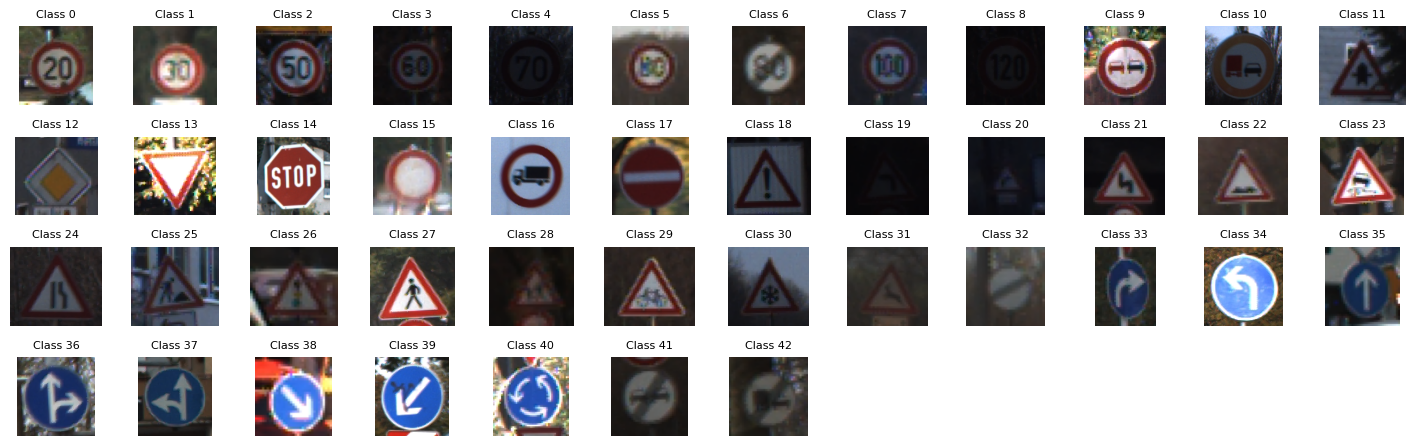

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def visualize_data_samples(root_dir, split='Train', num_classes=43, cols=12, imgs_per_class=1, random_choice=0):
    split_dir = os.path.join(root_dir, split)
    class_ids = [str(i) for i in range(num_classes)]  # bảo đảm thứ tự 0..42

    total_imgs = num_classes * imgs_per_class
    rows = (total_imgs + cols - 1) // cols
    plt.figure(figsize=(cols * 1.2, rows * 1.2))

    plot_idx = 1
    for class_id in class_ids:
        class_dir = os.path.join(split_dir, class_id)
        if not os.path.isdir(class_dir):
            continue

        image_files = [
            f for f in os.listdir(class_dir)
            if f.lower().endswith(('.ppm', '.png', '.jpg', '.jpeg'))
        ]
        if not image_files:
            continue

        if random_choice:
            chosen = random.sample(image_files, min(imgs_per_class, len(image_files)))
        else:
            chosen = image_files[:imgs_per_class]

        for img_file in chosen:
            img_path = os.path.join(class_dir, img_file)
            img = mpimg.imread(img_path)

            plt.subplot(rows, cols, plot_idx)
            plt.imshow(img)
            plt.title(f"Class {class_id}", fontsize=8)
            plt.axis("off")
            plot_idx += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()

visualize_data_samples("/content/", split='Train', num_classes=43, cols=12, imgs_per_class=1, random_choice=1)

# Kiến trúc

## Kiến trúc LeNet-5



1.  **Lớp C1 (Convolutional Layer):**
    *   Nhận đầu vào là ảnh xám 32x32x1.
    *   Sử dụng 6 bộ lọc (kernel) có kích thước 5x5.
    *   Stride = 1, Padding = 0.
    *   Mỗi bộ lọc kết nối với một vùng 5x5 trên ảnh đầu vào.
    *   Đầu ra là 6 feature map có kích thước 28x28.

2.  **Lớp S2 (Subsampling/Pooling Layer):**
    *   Áp dụng phép Average Pooling với cửa sổ 2x2 và stride 2 trên từng feature map của C1.
    *   Giảm kích thước không gian của mỗi feature map.
    *   Đầu ra là 6 feature map có kích thước 14x14.

3.  **Lớp C3 (Convolutional Layer):**
    *   Sử dụng 16 bộ lọc có kích thước 5x5.
    *   Đây là điểm đặc biệt của LeNet-5: mỗi bộ lọc trong C3 chỉ kết nối với một *tập hợp con* các feature map từ lớp S2 (không phải tất cả). Điều này nhằm giảm số lượng kết nối và tham số.
    *   Stride = 1, Padding = 0.
    *   Đầu ra là 16 feature map có kích thước 10x10.

4.  **Lớp S4 (Subsampling/Pooling Layer):**
    *   Tương tự S2, áp dụng Average Pooling với cửa sổ 2x2 và stride 2 trên từng feature map của C3.
    *   Giảm kích thước không gian.
    *   Đầu ra là 16 feature map có kích thước 5x5.

5.  **Lớp C5 (Convolutional Layer):**
    *   Sử dụng 120 bộ lọc có kích thước 5x5.
    *   Mỗi bộ lọc kết nối với *tất cả* các feature map của lớp S4.
    *   Vì kích thước bộ lọc (5x5) bằng kích thước feature map đầu vào (5x5), đây có thể coi là một lớp tích chập đầy đủ hoặc một lớp Fully Connected trên các feature map đã làm phẳng.
    *   Đầu ra là 120 feature map có kích thước 1x1.

6.  **Lớp F6 (Fully Connected Layer):**
    *   Nhận đầu vào từ 120 đơn vị của lớp C5 (làm phẳng thành vector 120 chiều).
    *   Kết nối đầy đủ với 84 đơn vị.
    *   Sử dụng hàm kích hoạt sigmoid hoặc tanh.

7.  **Lớp Output (Fully Connected Layer):**
    *   Nhận đầu vào từ 84 đơn vị của lớp F6.
    *   Kết nối đầy đủ với số lượng đơn vị bằng số lớp đầu ra (ví dụ: 10 cho MNIST).
    *   Sử dụng hàm kích hoạt Euclidean Radial Basis Function (RBF) hoặc Softmax để đưa ra xác suất cho từng lớp.

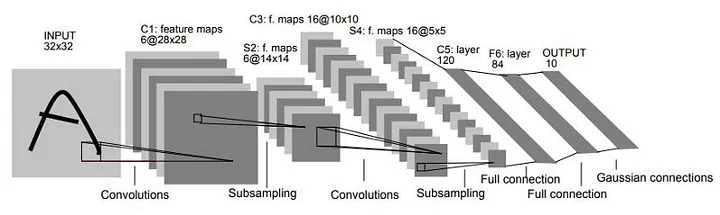

## Điểm khác biệt model của nhóm so với LeNet-5

| Thành phần   | LeNet-5                 | SimpleCNN_Sequential  |
| ------------ | ----------------------- | ---------------------- |
| Conv1        | Conv với 6 filter 5x5   | Conv với 16 filter 3x3 |
| Pool1        | Average Pooling         | Max Pooling            |
| Conv2        | Conv với 16 filter 5x5  | Conv với 32 filter 3x3 |
| Pool2        | Average Pooling         | Max Pooling            |
| FC1          | 120 neurons             | 128 neurons            |
| FC2 + Output | 84 neurons + 10 classes | 128 + 43 classes        |

<br>

Điểm khác biệt là:

- Ảnh đầu vào là ảnh màu thay vì ảnh xám

- LeNet dùng Average Pooling, CNN được dùng ở đây sử dụng Max Pooling hiện đại hơn

- LeNet gốc dùng tanh/sigmoid, CNN được dùng ở đây sử dụng ReLU.

- Filter nhỏ hơn (convolution 3x3 thay vì 5x5).

- Số lượng filters lớn hơn để tăng khả năng trích xuất đặc trưng.

# Import thư viện

In [ ]:
import numpy as np
import cv2
import time

from numba import jit, prange, cuda, float32
import numba as nb
from numba.cuda import local, shared
import math
import pandas as pd

# Data preprocessing

Resize ảnh về 32x32

Chuyển ảnh về kiểu float32 và chuẩn hóa giá trị pixel về khoảng [0, 1], từ kiểu gốc uint8 có giá trị [0, 255]

Chuẩn hóa tiếp ảnh về khoảng [-1, 1] bằng công thức chuẩn hóa chuẩn với giá trị trung bình mean = 0.5, độ lệch chuẩn std = 0.5.

Chuyển thứ tự các chiều ảnh từ HWC → CHW:
- Từ (height, width, channel) → (channel, height, width)
- Đây là định dạng yêu cầu bởi PyTorch khi đưa ảnh vào mô hình (torch.Tensor expects CHW).

In [ ]:
import pandas as pd
import cv2
import numpy as np
import os

def preprocess_image(image_path):
    """Preprocess single image for GTSRB"""
    img = cv2.imread(image_path)
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path '{image_path}' could not be loaded.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32, 32))
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5  # Normalize to [-1, 1]
    img = np.transpose(img, (2, 0, 1))  # CHW format
    return img

def load_gtsrb_split(data_dir, csv_file):
    """Load and preprocess GTSRB split (train or test)"""
    df = pd.read_csv(csv_file)
    images = []
    labels = []

    for _, row in df.iterrows():
        img_path = os.path.join(data_dir, row['Path'])
        img = preprocess_image(img_path)
        images.append(img)
        labels.append(row['ClassId'])

    return np.array(images), np.array(labels)

In [ ]:
train_dir = '/content'
train_csv = 'Train.csv'
X_train, y_train = load_gtsrb_split(train_dir, train_csv)

test_dir = '/content'
test_csv = 'Test.csv'
X_test, y_test = load_gtsrb_split(test_dir, test_csv)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(31367, 3, 32, 32)
(31367,)
(7842, 3, 32, 32)
(7842,)
(12630, 3, 32, 32)
(12630,)


In [ ]:
all_results = pd.DataFrame(columns=['Forward (sec)', 'Speedup (forward)' ,'Backward (sec)', 'Speedup (backward)'])
all_results

,Forward (sec),Speedup (forward),Backward (sec),Speedup (backward)


In [ ]:
def cross_entropy_loss(predictions, targets):
    """Calculate cross-entropy loss."""
    # Avoid log(0)
    predictions = np.clip(predictions, 1e-12, 1 - 1e-12)
    N = predictions.shape[0]
    one_hot_targets = np.zeros_like(predictions)
    one_hot_targets[np.arange(N), targets] = 1
    loss = -np.sum(one_hot_targets * np.log(predictions)) / N
    return loss

def cross_entropy_loss_backward(predictions, targets):
    """Calculate the gradient of the cross-entropy loss with respect to the predictions."""
    N = predictions.shape[0]
    grad = predictions.copy()
    grad[np.arange(N), targets] -= 1
    grad /= N
    return grad

# Các phiên bản

## 1. Phiên bản tuần tự 1 (numpy)

### 1.1 Thiết kế

Phiên bản `SimpleCNN_Sequential_Vec` là triển khai mạng nơ-ron tích chập (CNN) cơ bản sử dụng hoàn toàn các phép toán trên mảng của thư viện NumPy. Thiết kế của mạng bao gồm các lớp phổ biến trong các kiến trúc CNN đơn giản:

1.  **Lớp Tích chập 1 (Conv1):**
    *   Áp dụng 16 bộ lọc có kích thước 3x3.
    *   Đầu vào có 3 kênh màu (RGB).
    *   Sử dụng stride là 1 và padding là 1.
    *   Theo sau là một lớp bias.
    *   Kích thước đầu ra: (Batch Size, 16, 32, 32) từ đầu vào (Batch Size, 3, 32, 32).

2.  **Lớp Kích hoạt 1 (ReLU1):**
    *   Áp dụng hàm kích hoạt ReLU (Rectified Linear Unit) cho đầu ra của lớp Conv1.
    *   Kích thước đầu ra không đổi.

3.  **Lớp Max Pooling 1 (Pool1):**
    *   Thực hiện phép Max Pooling với kernel size 2x2 và stride 2.
    *   Giảm kích thước không gian của đầu ra.
    *   Kích thước đầu ra: (Batch Size, 16, 16, 16).

4.  **Lớp Tích chập 2 (Conv2):**
    *   Áp dụng 32 bộ lọc có kích thước 3x3.
    *   Đầu vào có 16 kênh (từ Pool1).
    *   Sử dụng stride là 1 và padding là 1.
    *   Theo sau là một lớp bias.
    *   Kích thước đầu ra: (Batch Size, 32, 16, 16).

5.  **Lớp Kích hoạt 2 (ReLU2):**
    *   Áp dụng hàm kích hoạt ReLU cho đầu ra của lớp Conv2.
    *   Kích thước đầu ra không đổi.

6.  **Lớp Max Pooling 2 (Pool2):**
    *   Thực hiện phép Max Pooling với kernel size 2x2 và stride 2.
    *   Giảm kích thước không gian của đầu ra.
    *   Kích thước đầu ra: (Batch Size, 32, 8, 8).

7.  **Lớp Làm phẳng (Flatten):**
    *   Chuyển đổi đầu ra từ lớp Pool2 (tensor 4D) thành một vector 1D cho mỗi mẫu trong batch.
    *   Kích thước đầu ra: (Batch Size, 32, 8, 8).

8.  **Lớp Kết nối đầy đủ 1 (FC1):**
    *   Một lớp tuyến tính (Fully Connected) nhận đầu vào từ lớp Flatten.
    *   Số lượng đơn vị (neuron) là 128.
    *   Theo sau là một lớp bias.
    *   Kích thước đầu ra: (Batch Size, 128).

9.  **Lớp Kích hoạt 3 (ReLU - sau FC1):**
    *   Áp dụng hàm kích hoạt ReLU cho đầu ra của lớp FC1.
    *   Kích thước đầu ra không đổi.

10. **Lớp Kết nối đầy đủ 2 (FC2):**
    *   Một lớp tuyến tính (Fully Connected) nhận đầu vào từ lớp ReLU sau FC1.
    *   Số lượng đơn vị (neuron) bằng số lớp đầu ra (43 lớp biển báo giao thông).
    *   Theo sau là một lớp bias.
    *   Kích thước đầu ra: (Batch Size, 43).

11. **Lớp Softmax:**
    *   Áp dụng hàm Softmax cho đầu ra của lớp FC2 để thu được xác suất cho mỗi lớp.
    *   Kích thước đầu ra không đổi.

Mô hình này thực hiện cả quá trình truyền xuôi (forward pass) và lan truyền ngược (backward pass) cho việc huấn luyện, tính toán gradient cho từng tham số (trọng số và bias) của các lớp tích chập và lớp kết nối đầy đủ. Tất cả các phép tính được thực hiện tuần tự trên CPU bằng NumPy.

#### Convolution

<img src='https://drive.google.com/uc?id=1DcirH3-621ykKnNeJrwQEl-K_WGCJYRg'>


**1. Khái niệm**

Convolution (tích chập) là một phép toán được sử dụng trong mạng nơ-ron tích chập (CNN) để trích xuất đặc trưng từ dữ liệu không gian (như ảnh).

* Thay vì kết nối toàn bộ neuron như Fully Connected Layer, convolution sử dụng **bộ lọc (filter/kernel)** có kích thước nhỏ (ví dụ `3×3`, `5×5`) để quét qua toàn bộ ảnh.
* Mỗi filter học được một **đặc trưng cục bộ** (local feature), chẳng hạn như cạnh, góc, hay hoa văn.
* Kết quả của nhiều filter sẽ được chồng lại thành nhiều **channel đặc trưng (feature maps)**.


**2. Các thành phần chính**

* **Input**: tensor có dạng `(Batch, Channels, Height, Width)`.
* **Kernel (Filter)**: ma trận có kích thước `(C_in, K, K)` (áp dụng lên toàn bộ channel của input).
* **Stride (S)**: bước nhảy khi kernel di chuyển (thường là 1).
* **Padding (P)**: số pixel thêm vào viền ảnh (để giữ kích thước hoặc tránh mất thông tin ở biên).
* **Output**: tensor có dạng `(Batch, C_out, H_out, W_out)` với:

  $$
  H_{out} = \frac{H - K + 2P}{S} + 1,\quad W_{out} = \frac{W - K + 2P}{S} + 1
  $$

  và `C_out` chính là số filter được sử dụng.


**3. Quy trình hoạt động từng bước**

Giả sử input `(C_in, H, W)`, kernel `(C_in, K, K)`, stride = 1, padding = P:

1. **Padding**

   * Nếu P > 0, thêm viền zero-padding xung quanh input, làm tăng kích thước thành `(C_in, H + 2P, W + 2P)`.

2. **Đặt kernel**

   * Đặt filter `(C_in, K, K)` lên một vùng nhỏ của input (cùng kích thước với filter).

3. **Nhân và cộng (dot product)**

   * Nhân từng phần tử của filter với vùng tương ứng trên input (theo tất cả các channel).
   * Cộng tất cả các giá trị lại → thu được 1 số thực.

4. **Di chuyển kernel (theo stride)**

   * Kernel dịch sang phải theo bước `S`, tính toán tiếp.
   * Hết 1 hàng → nhảy xuống hàng tiếp theo, lặp lại.

5. **Sinh ra 1 feature map**

   * Sau khi quét xong toàn bộ ảnh, ta thu được 1 ma trận `(H_out, W_out)` → đây là feature map của 1 filter.

6. **Lặp lại với nhiều filter**

   * Nếu có `C_out` filters, ta thu được `C_out` feature maps.
   * Stack chúng lại thành output `(C_out, H_out, W_out)`.

---

Hàm `im2col`

**Input**:

* `x`: tensor input, shape `(B, C_in, H, W)`
* `kH, kW`: kích thước kernel (chiều cao, chiều rộng)
* `stride`: bước nhảy
* `padding`: số pixel zero-padding

**Các bước thực hiện**:

1. **Tính toán kích thước output**:

   ```
   H_out = (H + 2*padding - kH) // stride + 1
   W_out = (W + 2*padding - kW) // stride + 1
   ```

2. **Pad input nếu cần**:

   * Nếu `padding > 0`: mở rộng input bằng cách chèn zero-padding.
   * Ngược lại: giữ nguyên.

   Kết quả là `x_padded` có shape `(B, C_in, H + 2*padding, W + 2*padding)`.

3. **Tạo cửa sổ con bằng sliding window**:

   * Dùng `np.lib.stride_tricks.sliding_window_view` để tạo tất cả cửa sổ có kích thước `(kH, kW)` trên `x_padded`.
   * Sau khi lấy stride, kết quả có shape:

     ```
     (B, C_in, H_out, W_out, kH, kW)
     ```

4. **Reshape thành ma trận cột**:

   * Đưa `C_in, kH, kW` vào một trục duy nhất.
   * Kết quả reshape thành:

     ```
     im2col_matrix shape = (B * H_out * W_out, C_in * kH * kW)
     ```
**Output**:

* `im2col_matrix`: ma trận đã flatten, sẵn sàng cho nhân ma trận.
* `H_out`, `W_out`: kích thước không gian output.

---

Hàm `conv2d_numpy_vec`

**Input**:

* `x`: tensor input, shape `(B, C_in, H, W)`
* `weight`: kernel, shape `(C_out, C_in, kH, kW)`
* `bias`: vector bias, shape `(C_out,)`
* `stride`: bước nhảy (mặc định = 1)
* `padding`: số pixel zero-padding (mặc định = 0)

**Các bước thực hiện**:

1. **Chuẩn bị trọng số**:

   * Reshape kernel:

     ```
     weight_flat shape = (C_out, C_in * kH * kW)
     ```

2. **Chuyển input sang dạng cột (im2col)**:

   * Gọi hàm `im2col`, nhận về:

     * `im2col_matrix`: shape `(B * H_out * W_out, C_in * kH * kW)`
     * `H_out`, `W_out`

3. **Nhân ma trận (matrix multiplication)**:

   * Tính:

     ```
     conv_result_flat = im2col_matrix @ weight_flat.T
     ```
   * Kết quả có shape:

     ```
     (B * H_out * W_out, C_out)
     ```

4. **Cộng bias**:

   * Thêm `bias` (shape `(C_out,)`) vào từng dòng của `conv_result_flat`.

5. **Reshape về output tensor**:

   * Reshape:

     ```
     (B * H_out * W_out, C_out) -> (B, H_out, W_out, C_out)
     ```
   * Transpose để đưa channel ra trước:

     ```
     (B, H_out, W_out, C_out) -> (B, C_out, H_out, W_out)
     ```

**Output**:

* `out`: tensor kết quả convolution, shape `(B, C_out, H_out, W_out)`.


#### ReLU

<img src='https://drive.google.com/uc?id=1rmTCFtU0rEGiNz0v6LeYQ6FjdizD8VQI'>


**Công thức ReLU**

$$
\text{ReLU}(x) = \max(0, x)
$$


* Hàm **ReLU (Rectified Linear Unit)** thay thế tất cả giá trị âm trong input bằng **0**, còn giữ nguyên các giá trị dương.
* Cụ thể:

  * Nếu $x > 0$ thì $\text{ReLU}(x) = x$.
  * Nếu $x \leq 0$ thì $\text{ReLU}(x) = 0$.

---

Hàm `relu`

**Input**:

* Một tensor/mảng `x` (có thể 1D, 2D, 4D…), chứa các giá trị thực.

**Các bước thực hiện**:

1. Cấp phát một mảng `out` có cùng shape với `x`.
2. Với mỗi phần tử $x_i$ trong `x`:

   * Nếu $x_i > 0$, giữ nguyên giá trị: $out_i = x_i$.
   * Nếu $x_i \leq 0$, thay bằng 0: $out_i = 0$.
3. Trả về `out`.

**Output**:

* Tensor `out` đã được áp dụng hàm ReLU cho từng phần tử.




#### Max Pooling


<img src='https://drive.google.com/uc?id=1cYiKWe5yOwYqfH69bN2xOatLPoPY41X5'>


**Max Pooling** thực hiện giảm kích thước (downsampling) của feature map:

* Chia feature map thành các ô nhỏ (window) theo kích thước và stride đã chọn (trên ảnh là kernel 2x2 và stride=2).
* Trong mỗi ô, chọn **giá trị lớn nhất**.
* Ghi giá trị đó vào đầu ra.

Kết quả:

* Giữ lại đặc trưng quan trọng nhất trong vùng (giá trị lớn nhất).
* Giảm chiều dữ liệu → tăng tốc huấn luyện, giảm overfitting.
* Tạo ra tính bất biến với dịch chuyển nhỏ (feature không thay đổi nhiều khi ảnh dịch chuyển một chút).

---

Hàm `max_pool2d_numpy_vec`

**Input**:

* `x`: tensor input, shape `(B, C, H, W)`

  * `B`: batch size
  * `C`: số channel (kênh)
  * `H, W`: chiều cao và chiều rộng input
* `size`: kích thước cửa sổ pooling (ví dụ 2 hoặc 3)
* `stride`: bước nhảy của cửa sổ pooling (mặc định = `size`)


**Các bước thực hiện**:

1. **Xác định kích thước output**:
   Công thức:

   ```
   H_out = (H - size) // stride + 1
   W_out = (W - size) // stride + 1
   ```

2. **Cấp phát bộ nhớ cho output**:
   Tạo tensor `out` có shape `(B, C, H_out, W_out)`.

3. **Tính Max Pooling**:
   Với mỗi batch `b`, mỗi channel `c`, mỗi vị trí `(i, j)` của output:

   * Xác định tọa độ bắt đầu của cửa sổ:

     ```
     h_start = i * stride
     w_start = j * stride
     ```
   * Trích xuất vùng con `window` từ `x[b, c, h_start:h_start+size, w_start:w_start+size]`.
   * Lấy giá trị lớn nhất trong vùng con này:

     ```
     value = max(window)
     ```
   * Gán kết quả vào `out[b, c, i, j] = value`.


**Output**:

* Tensor `out`, shape `(B, C, H_out, W_out)`
* Mỗi phần tử của `out` là giá trị lớn nhất trong một vùng `size × size` của input.



#### Softmax

<img src='https://drive.google.com/uc?id=1iwQzSh0jdWcLfyM1slrPJVevSR2ogR70'>


Như công thức trong ảnh bên trên, hàm **softmax** biến một vector số thực thành một **phân phối xác suất** (tất cả giá trị dương, tổng bằng 1).

Với mỗi phần tử $x_i$:

  * Lấy **hàm mũ** $e^{x_i}$ để đảm bảo giá trị luôn dương và làm nổi bật sự khác biệt.
  * Chia cho tổng tất cả các giá trị mũ của vector để **chuẩn hóa** về khoảng $[0,1]$.

Kết quả: phần tử nào có giá trị lớn hơn trong vector ban đầu thì sau softmax sẽ nhận xác suất cao hơn.

<br>

---
Hàm `softmax_numpy_vec`

**Input**:  
- `x`: ma trận đầu vào có shape `(n_samples, n_features)`, mỗi hàng là một vector đặc trưng.  


**Các bước thực hiện**:

* **Bước 1: Tính mũ và chuẩn hóa theo giá trị lớn nhất từng hàng**  
- Tìm giá trị lớn nhất của mỗi hàng:  
$$ \max\_val = \max(x, \text{axis}=1, \text{keepdims=True}) $$  

- Trừ từng phần tử cho giá trị lớn nhất để tránh tràn số mũ, rồi lấy hàm mũ:  
$$ exp\_vals = e^{\, (x - \max\_val)} $$  


* **Bước 2: Chuẩn hóa bằng tổng theo hàng**  
- Tính tổng của từng hàng:  
$$ sum\_exp = \sum_{j} exp\_vals[j] $$  

- Chia từng phần tử cho tổng:  
$$ out = \frac{exp\_vals}{sum\_exp} $$  


**Output**:  
- `out`: ma trận softmax có cùng shape với `x`, mỗi hàng là một phân phối xác suất.



### 1.2 Cài đặt

In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_backward(grad_output, x):
    grad_x = grad_output * (x > 0)
    return grad_x

def softmax_numpy_vec(x):
    exp_vals = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

def max_pool2d_numpy_vec(x, size=2, stride=2):
    B, C, H, W = x.shape
    out_h = (H - size) // stride + 1
    out_w = (W - size) // stride + 1

    # Use sliding_window_view to create windows
    windows = np.lib.stride_tricks.sliding_window_view(x, (size, size), axis=(2, 3))

    strided_windows = windows[:, :, ::stride, ::stride, :, :]

    # Reshape from (B, C, out_h, out_w, size, size) to (B, C, out_h, out_w, size*size)
    reshaped_windows = strided_windows.reshape(B, C, out_h, out_w, size * size)

    out = np.max(reshaped_windows, axis=-1)

    return out

def max_pool2d_backward_numpy_vec(grad_output, x, size=2, stride=2):
    B, C, H, W = x.shape
    out_h = grad_output.shape[2]
    out_w = grad_output.shape[3]
    grad_x = np.zeros_like(x)

    windows = np.lib.stride_tricks.sliding_window_view(x, (size, size), axis=(2, 3))
    strided_windows = windows[:, :, ::stride, ::stride, :, :]

    reshaped_windows = strided_windows.reshape(B, C, out_h, out_w, size * size)
    max_indices_flat = np.argmax(reshaped_windows, axis=-1) # Shape (B, C, out_h, out_w)

    max_ki = max_indices_flat // size
    max_kj = max_indices_flat % size

    start_h = np.arange(out_h) * stride
    start_w = np.arange(out_w) * stride

    b_grid, c_grid, i_grid, j_grid = np.meshgrid(np.arange(B), np.arange(C), np.arange(out_h), np.arange(out_w), indexing='ij')

    h_idx = i_grid * stride + max_ki
    w_idx = j_grid * stride + max_kj

    np.add.at(grad_x, (b_grid, c_grid, h_idx, w_idx), grad_output[b_grid, c_grid, i_grid, j_grid])

    return grad_x


# Vectorized Convolution using im2col (Image to Column)
def im2col(x, kH, kW, stride, padding):
    B, C_in, H, W = x.shape
    H_out = (H + 2*padding - kH) // stride + 1
    W_out = (W + 2*padding - kW) // stride + 1

    # Pad input
    if padding > 0:
        x_padded = np.pad(x, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant')
    else:
        x_padded = x

    # Get shape of padded input
    H_padded, W_padded = x_padded.shape[2], x_padded.shape[3]

    # Use sliding_window_view to create windows
    # Shape will be (B, C_in, H_out, W_out, kH, kW) after selecting based on stride
    windows = np.lib.stride_tricks.sliding_window_view(x_padded, (kH, kW), axis=(2, 3))
    windows = windows[:, :, ::stride, ::stride, :, :]

    # Reshape windows to columns: (B, H_out, W_out, C_in, kH, kW) -> (B * H_out * W_out, C_in * kH * kW)
    im2col_matrix = windows.transpose(0, 2, 3, 1, 4, 5).reshape(B * H_out * W_out, C_in * kH * kW)

    return im2col_matrix, H_out, W_out

def conv2d_numpy_vec(x, weight, bias, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape

    # Reshape weight for matrix multiplication: (C_out, C_in, kH, kW) -> (C_out, C_in * kH * kW)
    weight_flat = weight.reshape(C_out, -1)

    # Apply im2col
    im2col_matrix, H_out, W_out = im2col(x, kH, kW, stride, padding)

    # Perform matrix multiplication: (B * H_out * W_out, C_in * kH * kW) @ (C_in * kH * kW, C_out).T
    # Result shape: (B * H_out * W_out, C_out)
    conv_result_flat = im2col_matrix @ weight_flat.T

    # Add bias (broadcasting)
    # conv_result_flat shape is (N, C_out) where N = B * H_out * W_out
    conv_result_flat += bias # bias shape is (C_out,)

    # Reshape back to output shape: (B * H_out * W_out, C_out) -> (B, H_out, W_out, C_out) -> (B, C_out, H_out, W_out)
    out = conv_result_flat.reshape(B, H_out, W_out, C_out).transpose(0, 3, 1, 2)

    return out


# Vectorized Convolution Backward
def conv2d_backward_numpy_vec(grad_output, x, weight, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape
    B_out, C_out_out, H_out, W_out = grad_output.shape

    # Reshape grad_output: (B, C_out, H_out, W_out) -> (B, H_out, W_out, C_out) -> (B * H_out * W_out, C_out)
    grad_output_flat = grad_output.transpose(0, 2, 3, 1).reshape(B * H_out * W_out, C_out)

    # Calculate grad_bias: Sum over batch, height, width
    grad_bias = np.sum(grad_output, axis=(0, 2, 3))

    # Calculate grad_weight: im2col(x) @ grad_output_flat
    # im2col(x) shape: (B * H_out * W_out, C_in * kH * kW)
    # grad_output_flat shape: (B * H_out * W_out, C_out)
    # Result shape: (C_in * kH * kW, C_out).T -> (C_out, C_in * kH * kW)
    # Reshape back to (C_out, C_in, kH, kW)
    im2col_matrix, _, _ = im2col(x, kH, kW, stride, padding)
    grad_weight_flat = im2col_matrix.T @ grad_output_flat # Shape (C_in * kH * kW, C_out)
    grad_weight = grad_weight_flat.T.reshape(C_out, C_in, kH, kW)


    # Calculate grad_x: grad_output_flat @ weight_flat (transposed) and then col2im
    # weight_flat shape: (C_out, C_in * kH * kW)
    # grad_output_flat shape: (B * H_out * W_out, C_out)
    # Result shape: (B * H_out * W_out, C_in * kH * kW)
    weight_flat = weight.reshape(C_out, -1)
    grad_im2col_matrix = grad_output_flat @ weight_flat # Shape (B * H_out * W_out, C_in * kH * kW)


    # Col2im (Column to Image) - Reshape back to image
    grad_x_padded = np.zeros((B, C_in, H + 2*padding, W + 2*padding), dtype=grad_output.dtype)

    # Reshape grad_im2col_matrix back to window shape: (B, H_out, W_out, C_in, kH, kW)
    grad_windows = grad_im2col_matrix.reshape(B, H_out, W_out, C_in, kH, kW)

    # Scatter values from windows back to padded image
    for b in range(B):
        for i in range(H_out):
            for j in range(W_out):
                h_start = i * stride
                w_start = j * stride
                # Add the gradient contribution from this window to the padded image
                grad_x_padded[b, :, h_start:h_start+kH, w_start:w_start+kW] += grad_windows[b, i, j]

    # Unpad grad_x
    if padding > 0:
        grad_x = grad_x_padded[:, :, padding:-padding, padding:-padding]
    else:
        grad_x = grad_x_padded


    return grad_x, grad_weight, grad_bias


class SimpleCNN_Sequential_Vec:
    def __init__(self, input_shape=(3, 32, 32), num_classes=43):
        self.params_cpu = {}

        # Layer 1 (Conv1): 3 input channels -> 16 filters of size 3x3
        self.params_cpu['conv1_w'] = np.random.randn(16, 3, 3, 3).astype(np.float32) * np.sqrt(2.0 / (3 * 3 * 3))
        self.params_cpu['conv1_b'] = np.zeros(16, dtype=np.float32)

        # Layer 2 (Conv2): 16 input channels -> 32 filters of size 3x3
        self.params_cpu['conv2_w'] = np.random.randn(32, 16, 3, 3).astype(np.float32) * np.sqrt(2.0 / (16 * 3 * 3))
        self.params_cpu['conv2_b'] = np.zeros(32, dtype=np.float32)

        # FC layers
        flatten_size = 32 * 8 * 8
        self.params_cpu['fc1_w'] = np.random.randn(flatten_size, 128).astype(np.float32) * np.sqrt(2.0 / flatten_size)
        self.params_cpu['fc1_b'] = np.zeros(128, dtype=np.float32)
        self.params_cpu['fc2_w'] = np.random.randn(128, num_classes).astype(np.float32) * np.sqrt(2.0 / 128)
        self.params_cpu['fc2_b'] = np.zeros(num_classes, dtype=np.float32)

        self.layer_timings = {}
        self.intermediate_values = {} # Store values for backward pass

    def _time_layer(self, layer_name, operation, *args, **kwargs):
        start = time.time()
        result = operation(*args, **kwargs)
        end = time.time()
        if layer_name not in self.layer_timings:
            self.layer_timings[layer_name] = {}
        pass_type = 'forward'
        backward_keywords = ['backward', '_bwd', '_grad', '_input', '_weight', '_bias']
        if any(keyword in layer_name for keyword in backward_keywords):
             pass_type = 'backward'

        if pass_type not in self.layer_timings[layer_name]:
             self.layer_timings[layer_name][pass_type] = 0.0

        self.layer_timings[layer_name][pass_type] += (end - start)
        return result

    def forward(self, x):
        self.layer_timings = {}
        self.intermediate_values = {}

        self.intermediate_values['x'] = x

        # Conv1
        conv1_out = self._time_layer(
            'conv1_forward', conv2d_numpy_vec,
            x, self.params_cpu['conv1_w'], self.params_cpu['conv1_b'], stride=1, padding=1
        )
        self.intermediate_values['conv1_out'] = conv1_out

        # ReLU1
        relu1_out = self._time_layer('relu1_forward', relu, conv1_out)
        self.intermediate_values['relu1_out'] = relu1_out

        # Pool1
        pool1_out = self._time_layer('pool1_forward', max_pool2d_numpy_vec, relu1_out)
        self.intermediate_values['pool1_out'] = pool1_out

        # Conv2
        conv2_out = self._time_layer(
            'conv2_forward', conv2d_numpy_vec,
            pool1_out, self.params_cpu['conv2_w'], self.params_cpu['conv2_b'], stride=1, padding=1
        )
        self.intermediate_values['conv2_out'] = conv2_out

        # ReLU2
        relu2_out = self._time_layer('relu2_forward', relu, conv2_out)
        self.intermediate_values['relu2_out'] = relu2_out

        # Pool2
        pool2_out = self._time_layer('pool2_forward', max_pool2d_numpy_vec, relu2_out)
        self.intermediate_values['pool2_out'] = pool2_out

        # Flatten
        flattened_shape = (pool2_out.shape[0], -1)
        x_flat = pool2_out.reshape(flattened_shape)
        self.intermediate_values['flatten_out'] = x_flat

        # FC1
        fc1_linear = x_flat @ self.params_cpu['fc1_w'] + self.params_cpu['fc1_b']
        self.intermediate_values['fc1_linear'] = fc1_linear
        fc1_out = self._time_layer('fc1_forward', relu, fc1_linear)
        self.intermediate_values['fc1_out'] = fc1_out

        # FC2
        fc2_linear = fc1_out @ self.params_cpu['fc2_w'] + self.params_cpu['fc2_b']
        self.intermediate_values['fc2_linear'] = fc2_linear
        output = self._time_layer('fc2_forward', softmax_numpy_vec, fc2_linear)
        self.intermediate_values['output'] = output

        return output

    def backward(self, grad_output):
        grads = {}

        # Backprop through FC2
        grad_fc2_linear = grad_output
        grads['fc2_b'] = self._time_layer('fc2_bias_backward', np.sum, grad_fc2_linear, axis=0)
        grads['fc2_w'] = self._time_layer('fc2_weight_backward', lambda g, x: x.T @ g, grad_fc2_linear, self.intermediate_values['fc1_out'])
        grad_fc1_out = self._time_layer('fc2_input_backward', lambda g, w: g @ w.T, grad_fc2_linear, self.params_cpu['fc2_w'])

        # Backprop through FC1
        grad_fc1_linear = self._time_layer('fc1_relu_backward', relu_backward, grad_fc1_out, self.intermediate_values['fc1_linear'])
        grads['fc1_b'] = self._time_layer('fc1_bias_backward', np.sum, grad_fc1_linear, axis=0)
        grads['fc1_w'] = self._time_layer('fc1_weight_backward', lambda g, x: x.T @ g, grad_fc1_linear, self.intermediate_values['flatten_out'])
        grad_flatten_out = self._time_layer('fc1_input_backward', lambda g, w: g @ w.T, grad_fc1_linear, self.params_cpu['fc1_w'])

        # Reshape
        grad_pool2_out = grad_flatten_out.reshape(self.intermediate_values['pool2_out'].shape)

        # Backprop through Pool2
        grad_relu2_out = self._time_layer('pool2_backward', max_pool2d_backward_numpy_vec, grad_pool2_out, self.intermediate_values['relu2_out'], size=2, stride=2)

        # Backprop through ReLU2
        grad_conv2_out = self._time_layer('relu2_backward', relu_backward, grad_relu2_out, self.intermediate_values['conv2_out'])

        # Backprop through Conv2
        grad_pool1_out, grads['conv2_w'], grads['conv2_b'] = self._time_layer(
            'conv2_backward', conv2d_backward_numpy_vec,
            grad_conv2_out, self.intermediate_values['pool1_out'], self.params_cpu['conv2_w'], stride=1, padding=1
        )

        # Backprop through Pool1
        grad_relu1_out = self._time_layer('pool1_backward', max_pool2d_backward_numpy_vec, grad_pool1_out, self.intermediate_values['relu1_out'], size=2, stride=2)

        # Backprop through ReLU1
        grad_conv1_out = self._time_layer('relu1_backward', relu_backward, grad_relu1_out, self.intermediate_values['conv1_out'])

        # Backprop through Conv1
        grad_x, grads['conv1_w'], grads['conv1_b'] = self._time_layer(
            'conv1_backward', conv2d_backward_numpy_vec,
            grad_conv1_out, self.intermediate_values['x'], self.params_cpu['conv1_w'], stride=1, padding=1
        )

        return grads

    def update(self, grads, learning_rate):
        """Update weights and biases using gradients and learning rate."""
        self.params_cpu['conv1_w'] -= learning_rate * grads['conv1_w']
        self.params_cpu['conv1_b'] -= learning_rate * grads['conv1_b']
        self.params_cpu['conv2_w'] -= learning_rate * grads['conv2_w']
        self.params_cpu['conv2_b'] -= learning_rate * grads['conv2_b']
        self.params_cpu['fc1_w'] -= learning_rate * grads['fc1_w']
        self.params_cpu['fc1_b'] -= learning_rate * grads['fc1_b']
        self.params_cpu['fc2_w'] -= learning_rate * grads['fc2_w']
        self.params_cpu['fc2_b'] -= learning_rate * grads['fc2_b']

    def get_timings_df(self):
        """
        Returns a DataFrame containing the execution time of each layer
        from the last forward/backward pass.
        """
        if not self.layer_timings:
            print("Warning: No timing data available. Run model.forward(data) first.")
            return pd.DataFrame(columns=['Layer', 'Pass', 'Time (s)'])

        df_list = []
        for layer_name, passes in self.layer_timings.items():
            for pass_type, time_taken in passes.items():
                if '_forward' in layer_name:
                    layer_name = layer_name.replace('_forward', '')
                    pass_type = 'forward'
                elif '_backward' in layer_name:
                    layer_name = layer_name.replace('_backward', '')
                    pass_type = 'backward'

                df_list.append({
                    "Layer": layer_name,
                    "Pass": pass_type,
                    "Time (s)": time_taken
                })

        return pd.DataFrame(df_list).round(6)

    def predict(self, x):
        probs = self.forward(x)
        return np.argmax(probs, axis=1)

### 1.3 Đánh giá

Nhằm tiết kiệm thời gian, tất cả phiên bản sẽ chỉ train đúng 1 epoch trên 256 ảnh đầu tiên của dataset
- Thời gian chạy các phiên bản sẽ được lưu vào dataframe để dễ theo dõi và so sánh độ cải thiện.
- Về tính đúng đắn: output của bản tuần tự 1 sẽ được lấy làm chuẩn để so sánh với các phiên bản sau.

Cuối cùng, phiên bản nhanh nhất sẽ được train trên toàn bộ dataset với số epoch lớn hơn ⟶ đánh giá bằng các matric (acc, recall, f1,...)

#### Thời gian chạy

In [ ]:
np.random.seed(42)
model_numpy_seq = SimpleCNN_Sequential_Vec()

# Perform forward and backward pass for each model on a batch
batch_size = 256
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# Sequential CPU (Vectorized NumPy)
print("--- SimpleCNN_Sequential_Vec Timings ---")

start_time_forward = time.time()
predictions_numpy = model_numpy_seq.forward(X_batch)
end_time_forward = time.time()
numpy_time_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
grad_output_numpy = cross_entropy_loss_backward(predictions_numpy, y_batch)
grads_numpy = model_numpy_seq.backward(grad_output_numpy)
end_time_backward = time.time()
numpy_time_backward = end_time_backward - start_time_backward

# Print the timings
df_numpy = model_numpy_seq.get_timings_df()
display(df_numpy)

--- SimpleCNN_Sequential_Vec Timings ---


,Layer,Pass,Time (s)
0,conv1,forward,0.057369
1,relu1,forward,0.006173
2,pool1,forward,0.100436
3,conv2,forward,0.078633
4,relu2,forward,0.003208
5,pool2,forward,0.053200
6,fc1,forward,0.000064
7,fc2,forward,0.000289
8,fc2_bias,backward,0.000030
9,fc2_weight,backward,0.000171


In [ ]:
# Update the index name to reflect vectorized NumPy
all_results.loc['Sequential 1: Numpy', 'Forward (sec)'] = numpy_time_forward
all_results.loc['Sequential 1: Numpy', 'Speedup (forward)'] = None

all_results.loc['Sequential 1: Numpy', 'Backward (sec)'] = numpy_time_backward
all_results.loc['Sequential 1: Numpy', 'Speedup (backward)'] = None

print("\n--- Overall Model Runtime Comparison ---")
display(all_results)


--- Overall Model Runtime Comparison ---


,Forward (sec),Speedup (forward),Backward (sec),Speedup (backward)
Sequential 1: Numpy,0.304777,None,2.616115,None


Phiên bản thuần python sẽ được dùng làm base để đánh giá độ cải thiện hiệu suất của các phiên bản sau. Vì vậy phiên bản numpy sẽ không có dữ liệu ở các cột speedup

## 2. Phiên bản tuần tự 2 (thuần python)

### 2.1 Thiết kế

#### Hàm `conv2d`

**Input**:

* `x`: tensor input, shape `(B, C_in, H, W)`
* `weight`: kernel, shape `(C_out, C_in, kH, kW)`
* `bias`: vector bias, shape `(C_out,)`
* `stride`: bước nhảy của kernel (mặc định = 1)
* `padding`: số pixel zero-padding (mặc định = 0)


**Các bước thực hiện**:

1. **Xác định kích thước output**:

   * Tính chiều cao và chiều rộng output theo công thức:

     ```
     H_out = (H + 2*padding - kH) // stride + 1
     W_out = (W + 2*padding - kW) // stride + 1
     ```

2. **Pad input nếu cần**:

   * Nếu `padding > 0`: tạo tensor `x_padded` với kích thước lớn hơn và chèn `x` vào giữa.
   * Ngược lại: `x_padded = x`.

3. **Cấp phát bộ nhớ cho output**:

   * Tạo `out` có shape `(B, C_out, H_out, W_out)`.

4. **Tính convolution**:

   * Với mỗi batch `b`, mỗi filter `c_out`, mỗi vị trí `(i, j)` của output:

     * Xác định tọa độ bắt đầu của cửa sổ:

       ```
       h_start = i * stride
       w_start = j * stride
       ```
     * Trích xuất vùng con `window` từ `x_padded`.
     * Nhân `window` với kernel `weight[c_out]`, lấy tổng tất cả giá trị.
     * Cộng thêm bias `bias[c_out]`.
     * Gán kết quả vào `out[b, c_out, i, j]`.


**Output**:

* Tensor output, shape `(B, C_out, H_out, W_out)`



#### Hàm `relu`

**Input**:

* Một tensor/mảng `x` (có thể 1D, 2D, 4D…), chứa các giá trị thực.

**Các bước thực hiện**:

1. Cấp phát một mảng `out` có cùng shape với `x`.
2. Với mỗi phần tử $x_i$ trong `x`:

   * Nếu $x_i > 0$, giữ nguyên giá trị: $out_i = x_i$.
   * Nếu $x_i \leq 0$, thay bằng 0: $out_i = 0$.
3. Trả về `out`.

**Output**:

* Tensor `out` đã được áp dụng hàm ReLU cho từng phần tử.



#### Hàm `max_pool2d`

**Input**:

* `x`: tensor input, shape `(B, C, H, W)`
* `size`: kích thước cửa sổ pooling (mặc định = 2)
* `stride`: bước nhảy (mặc định = 2)


**Các bước thực hiện**:

1. **Xác định kích thước output**:

   * Tính số hàng và số cột của output:

     ```
     out_h = (H - size) // stride + 1
     out_w = (W - size) // stride + 1
     ```

2. **Cấp phát bộ nhớ cho output và lưu chỉ số max**:

   * `out`: tensor kết quả pooling, shape `(B, C, out_h, out_w)`
   * `argmax_idx`: lưu vị trí (index) của phần tử max trong mỗi cửa sổ, shape `(B, C, out_h, out_w)`

3. **Thực hiện max pooling**:

   * Với mỗi batch `b`, mỗi channel `c`, và mỗi vị trí `(i, j)` trong output:

     * Xác định vị trí bắt đầu của cửa sổ pooling:

       ```
       h_start = i * stride
       w_start = j * stride
       ```
     * Trích xuất vùng con `window` từ input.
     * Làm phẳng `window` thành vector `flat`.
     * Lấy giá trị lớn nhất (`np.max`) và chỉ số của nó (`np.argmax`).
     * Gán giá trị max vào `out[b, c, i, j]`.
     * Gán index max vào `argmax_idx[b, c, i, j]`.

4. **Tạo cache cho backward**:

   * Lưu `(x.shape, size, stride, argmax_idx)` để sử dụng trong backpropagation.


**Output**:

* `out`: tensor kết quả sau max pooling, shape `(B, C, out_h, out_w)`
* `cache`: tuple chứa thông tin cần thiết cho backward



#### Hàm `softmax`

**Input**:

* `x`: ma trận input, shape `(N, D)`

  * `N`: số lượng mẫu (batch size)
  * `D`: số chiều (số class)


**Các bước thực hiện**:

1. **Khởi tạo output**:

   * Tạo ma trận `out` cùng shape với `x`.

2. **Duyệt từng mẫu** (từng hàng `i` của `x`):

   * Tìm giá trị lớn nhất của hàng: `max_val = np.max(x[i])`.
   - Chuẩn hóa vector bằng cách tính:  

  $$ {exp\_vals} = e^{(x[i] - {max\_val})} $$

  - Tính tổng:  
  $$ {sum\_exp} = \text{np.sum}({exp\_vals}) $$

  - Chuẩn hóa từng phần tử:  

  $$ out[i] = \frac{{exp\_vals}}{{sum\_exp}} $$

**Output**:

* `out`: ma trận kết quả softmax, cùng shape với `x`mỗi hàng là một phân phối xác suất.

### 2.2 Cài đặt

In [ ]:
def softmax(x):
    out = np.zeros_like(x)
    for i in range(x.shape[0]):
        max_val = np.max(x[i])
        exp_vals = np.exp(x[i] - max_val)
        out[i] = exp_vals / np.sum(exp_vals)
    return out

def max_pool2d(x, size=2, stride=2):
    B, C, H, W = x.shape
    out_h = (H - size) // stride + 1
    out_w = (W - size) // stride + 1
    out = np.zeros((B, C, out_h, out_w))
    argmax_idx = np.zeros((B, C, out_h, out_w), dtype=np.int64)

    for b in range(B):
        for c in range(C):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * stride
                    w_start = j * stride
                    window = x[b, c, h_start:h_start+size, w_start:w_start+size]
                    flat = window.reshape(-1)
                    k = np.argmax(flat)  # tie → first index
                    out[b, c, i, j] = flat[k]
                    argmax_idx[b, c, i, j] = k
    cache = (x.shape, size, stride, argmax_idx)
    return out, cache


def max_pool2d_backward(grad_output, cache):
    (B, C, H, W), size, stride, argmax_idx = cache
    grad_x = np.zeros((B, C, H, W))
    out_h, out_w = grad_output.shape[2:]

    for b in range(B):
        for c in range(C):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * stride
                    w_start = j * stride
                    k = argmax_idx[b, c, i, j]
                    r = k // size
                    s = k % size
                    grad_x[b, c, h_start + r, w_start + s] += grad_output[b, c, i, j]
    return grad_x


def conv2d(x, weight, bias, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape
    H_out = (H + 2*padding - kH) // stride + 1
    W_out = (W + 2*padding - kW) // stride + 1

    # Pad input
    if padding > 0:
        x_padded = np.zeros((B, C_in, H + 2*padding, W + 2*padding))
        x_padded[:, :, padding:-padding, padding:-padding] = x
    else:
        x_padded = x

    out = np.zeros((B, C_out, H_out, W_out))

    for b in range(B):
        for c_out in range(C_out):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * stride
                    w_start = j * stride
                    window = x_padded[b, :, h_start:h_start+kH, w_start:w_start+kW]
                    out[b, c_out, i, j] = np.sum(window * weight[c_out]) + bias[c_out]
    return out

def conv2d_backward(grad_output, x, weight, bias=None, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape
    _, _, H_out, W_out = grad_output.shape

    # Initialize grads
    grad_weight = np.zeros_like(weight)
    grad_bias = np.sum(grad_output, axis=(0, 2, 3))

    # Pad input (handle padding=0 properly)
    if padding > 0:
        x_padded = np.zeros((B, C_in, H + 2*padding, W + 2*padding), dtype=x.dtype)
        x_padded[:, :, padding:-padding, padding:-padding] = x
        grad_x_padded = np.zeros_like(x_padded)
    else:
        x_padded = x
        grad_x_padded = np.zeros_like(x)

    # Backprop loops
    for b in range(B):
        for c_out in range(C_out):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * stride
                    w_start = j * stride

                    window = x_padded[b, :, h_start:h_start+kH, w_start:w_start+kW]

                    # dL/dW
                    grad_weight[c_out] += window * grad_output[b, c_out, i, j]

                    # dL/dX
                    grad_x_padded[b, :, h_start:h_start+kH, w_start:w_start+kW] += \
                        weight[c_out] * grad_output[b, c_out, i, j]

    # Unpad grad_x
    if padding > 0:
        grad_x = grad_x_padded[:, :, padding:-padding, padding:-padding]
    else:
        grad_x = grad_x_padded

    return grad_x, grad_weight, grad_bias


class SimpleCNN_Sequential:
    def __init__(self, input_shape=(3, 32, 32), num_classes=43):
        # Xavier initialization
        self.conv1_w = np.random.randn(16, 3, 3, 3).astype(np.float32) * np.sqrt(2.0 / (3 * 3 * 3))
        self.conv1_b = np.zeros(16, dtype=np.float32)
        self.conv2_w = np.random.randn(32, 16, 3, 3).astype(np.float32) * np.sqrt(2.0 / (16 * 3 * 3))
        self.conv2_b = np.zeros(32, dtype=np.float32)

        flatten_size = 32 * 8 * 8
        self.fc1_w = np.random.randn(flatten_size, 128).astype(np.float32) * np.sqrt(2.0 / flatten_size)
        self.fc1_b = np.zeros(128, dtype=np.float32)
        self.fc2_w = np.random.randn(128, num_classes).astype(np.float32) * np.sqrt(2.0 / 128)
        self.fc2_b = np.zeros(num_classes, dtype=np.float32)

        self.layer_timings = {}
        self.intermediate_values = {} # Store values for backward pass

    def _time_layer(self, layer_name, operation, *args, **kwargs):
        start = time.time()
        result = operation(*args, **kwargs)
        end = time.time()
        # Store timings for both forward and backward passes distinctly
        if layer_name not in self.layer_timings:
            self.layer_timings[layer_name] = {}
        # Corrected logic to determine pass type
        pass_type = 'forward'
        # Check for known backward layer names
        backward_keywords = ['backward', '_bwd', '_grad', '_input', '_weight', '_bias']
        if any(keyword in layer_name for keyword in backward_keywords):
             pass_type = 'backward'
        # Removed the problematic check for args in intermediate_values


        if pass_type not in self.layer_timings[layer_name]:
             self.layer_timings[layer_name][pass_type] = 0.0

        self.layer_timings[layer_name][pass_type] += (end - start)
        return result

    def forward(self, x):
        self.layer_timings = {}  # Reset timings
        self.intermediate_values = {} # Reset intermediate values

        self.intermediate_values['x'] = x

        # Conv1
        conv1_out = self._time_layer('conv1_forward', conv2d, x, self.conv1_w, self.conv1_b, stride=1, padding=1)
        self.intermediate_values['conv1_out'] = conv1_out

        # ReLU1
        relu1_out = self._time_layer('relu1_forward', relu, conv1_out)
        self.intermediate_values['relu1_out'] = relu1_out

        # Pool1
        pool1_out, pool1_cache = self._time_layer('pool1_forward', max_pool2d, relu1_out)
        self.intermediate_values['pool1_out'] = pool1_out
        self.intermediate_values['pool1_cache'] = pool1_cache

        # Conv2
        conv2_out = self._time_layer('conv2_forward', conv2d, pool1_out, self.conv2_w, self.conv2_b, stride=1, padding=1)
        self.intermediate_values['conv2_out'] = conv2_out

        # ReLU2
        relu2_out = self._time_layer('relu2_forward', relu, conv2_out)
        self.intermediate_values['relu2_out'] = relu2_out

        # Pool2
        pool2_out, pool2_cache = max_pool2d(relu2_out, size=2, stride=2)
        self.intermediate_values['pool2_out'] = pool2_out
        self.intermediate_values['pool2_cache'] = pool2_cache

        # Flatten
        flattened_shape = (pool2_out.shape[0], -1)
        x_flat = pool2_out.reshape(flattened_shape)
        self.intermediate_values['flatten_out'] = x_flat

        # FC1
        fc1_linear = x_flat @ self.fc1_w + self.fc1_b
        self.intermediate_values['fc1_linear'] = fc1_linear
        fc1_out = self._time_layer('fc1_forward', relu, fc1_linear)
        self.intermediate_values['fc1_out'] = fc1_out

        # FC2
        fc2_linear = fc1_out @ self.fc2_w + self.fc2_b
        self.intermediate_values['fc2_linear'] = fc2_linear
        output = self._time_layer('fc2_forward', softmax, fc2_linear)
        self.intermediate_values['output'] = output

        return output

    def backward(self, grad_output):
        grads = {}

        # Backprop through FC2
        grad_fc2_linear = grad_output
        grads['fc2_b'] = self._time_layer('fc2_bias_backward', np.sum, grad_fc2_linear, axis=0)
        grads['fc2_w'] = self._time_layer('fc2_weight_backward', lambda g, x: x.T @ g, grad_fc2_linear, self.intermediate_values['fc1_out'])
        grad_fc1_out = self._time_layer('fc2_input_backward', lambda g, w: g @ w.T, grad_fc2_linear, self.fc2_w)


        # Backprop through FC1 (ReLU)
        grad_fc1_linear = self._time_layer('fc1_relu_backward', relu_backward, grad_fc1_out, self.intermediate_values['fc1_linear'])
        grads['fc1_b'] = self._time_layer('fc1_bias_backward', np.sum, grad_fc1_linear, axis=0)
        grads['fc1_w'] = self._time_layer('fc1_weight_backward', lambda g, x: x.T @ g, grad_fc1_linear, self.intermediate_values['flatten_out'])
        grad_flatten_out = self._time_layer('fc1_input_backward', lambda g, w: g @ w.T, grad_fc1_linear, self.fc1_w)


        # Reshape grad_flatten_out back to Pool2 shape
        grad_pool2_out = grad_flatten_out.reshape(self.intermediate_values['pool2_out'].shape)

        # Backprop through Pool2
        grad_relu2_out = self._time_layer(
            'pool2_backward',
            max_pool2d_backward,
            grad_pool2_out,
            self.intermediate_values['pool2_cache']
        )


        # Backprop through ReLU2
        grad_conv2_out = self._time_layer('relu2_backward', relu_backward, grad_relu2_out, self.intermediate_values['conv2_out'])

        # Backprop through Conv2
        grad_pool1_out, grads['conv2_w'], grads['conv2_b'] = self._time_layer('conv2_backward', conv2d_backward,
            grad_conv2_out,
            self.intermediate_values['pool1_out'],
            self.conv2_w,
            self.conv2_b,
            stride=1,
            padding=1
        )

        # Backprop through Pool1
        # grad_relu1_out = self._time_layer('pool1_backward', max_pool2d_backward, grad_pool1_out, self.intermediate_values['relu1_out'], size=2, stride=2)
        grad_relu1_out = self._time_layer(
            'pool1_backward',
            max_pool2d_backward,
            grad_pool1_out,
            self.intermediate_values['pool1_cache']
        )

        # Backprop through ReLU1
        grad_conv1_out = self._time_layer('relu1_backward', relu_backward, grad_relu1_out, self.intermediate_values['conv1_out'])

        # Backprop through Conv1
        grad_x, grads['conv1_w'], grads['conv1_b'] = self._time_layer('conv1_backward', conv2d_backward,
            grad_conv1_out,
            self.intermediate_values['x'],
            self.conv1_w,
            self.conv1_b,
            stride=1,
            padding=1
        )

        return grads

    def update(self, grads, learning_rate):
        """Update weights and biases using gradients and learning rate."""
        self.conv1_w -= learning_rate * grads['conv1_w']
        self.conv1_b -= learning_rate * grads['conv1_b']
        self.conv2_w -= learning_rate * grads['conv2_w']
        self.conv2_b -= learning_rate * grads['conv2_b']
        self.fc1_w -= learning_rate * grads['fc1_w']
        self.fc1_b -= learning_rate * grads['fc1_b']
        self.fc2_w -= learning_rate * grads['fc2_w']
        self.fc2_b -= learning_rate * grads['fc2_b']

    def get_timings_df(self):
        """
        Returns a DataFrame containing the execution time of each layer
        from the last forward/backward pass.
        """
        if not self.layer_timings:
            print("Warning: No timing data available. Run model.forward(data) first.")
            return pd.DataFrame(columns=['Layer', 'Pass', 'Time (s)'])

        df_list = []
        for layer_name, passes in self.layer_timings.items():
            for pass_type, time_taken in passes.items():
                if '_forward' in layer_name:
                    layer_name = layer_name.replace('_forward', '')
                    pass_type = 'forward'
                elif '_backward' in layer_name:
                    layer_name = layer_name.replace('_backward', '')
                    pass_type = 'backward'

                df_list.append({
                    "Layer": layer_name,
                    "Pass": pass_type,
                    "Time (s)": time_taken
                })

        return pd.DataFrame(df_list).round(6)

    def predict(self, x):
        probs = self.forward(x)
        return np.argmax(probs, axis=1)

### 2.3 Đánh giá

#### Thời gian chạy

In [ ]:
np.random.seed(42)
model_seq = SimpleCNN_Sequential()

batch_size = 256
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# Sequential CPU
print("--- SimpleCNN_Sequential Timings ---")

start_time_forward = time.time()
predictions_seq = model_seq.forward(X_batch)
end_time_forward = time.time()
seq_time_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
grad_output_seq = cross_entropy_loss_backward(predictions_seq, y_batch)
grads_seq = model_seq.backward(grad_output_seq)
end_time_backward = time.time()
seq_time_backward = end_time_backward - start_time_backward

df_seq = model_seq.get_timings_df()
display(df_seq)

--- SimpleCNN_Sequential Timings ---


,Layer,Pass,Time (s)
0,conv1,forward,29.814972
1,relu1,forward,0.010721
2,pool1,forward,3.165967
3,conv2,forward,15.464556
4,relu2,forward,0.005821
5,fc1,forward,0.000057
6,fc2,forward,0.000288
7,fc2_bias,backward,0.000029
8,fc2_weight,backward,0.000187
9,fc2_input,backward,0.000124


Các layer tốn nhiều thời gian tính toán chủ yếu là convolutiona và max_pooling

 → Cần tập trung vào các layer này

In [ ]:
# Display results in a DataFrame

all_results.loc['Sequential 2: pure python', 'Forward (sec)'] = seq_time_forward
all_results.loc['Sequential 2: pure python', 'Speedup (forward)'] = 1.0  # Base case

all_results.loc['Sequential 2: pure python', 'Backward (sec)'] = seq_time_backward
all_results.loc['Sequential 2: pure python', 'Speedup (backward)'] = 1.0  # Base case

print("\n--- Overall Model Runtime Comparison ---")
display(all_results)


--- Overall Model Runtime Comparison ---


,Forward (sec),Speedup (forward),Backward (sec),Speedup (backward)
Sequential 1: Numpy,0.304777,None,2.616115,None
Sequential 2: pure python,50.067601,1.0,63.509257,1.0


#### Tính đúng đắn

##### Forward

Đối với bài toán phân lớp, chúng ta sẽ lấy những label dự đoán của 1 mẫu nhỏ từ phần cài đặt của phiên bản NumPy để làm gốc, và so với các phiên bản còn lại

In [ ]:
prediction_numpy = model_numpy_seq.predict(X_batch)
predictions_seq = model_seq.predict(X_batch)


# Display the predicted labels for the first few samples
print("Predicted labels (Sequential 1 - NumPy Vectorized):", prediction_numpy[:20])
print("Predicted labels (Sequential 2 - Pure Python):", predictions_seq[:20])

print("\nComparison of predicted labels:")
comparison_df = pd.DataFrame({
    'Sequential 1 (NumPy Vectorized)': prediction_numpy[:20],
    'Sequential 2 - Pure Python': predictions_seq[:20]
})

display(comparison_df)

Predicted labels (Sequential 1 - NumPy Vectorized): [ 2 11 39  7 11  2 10  2  2  7  2  2  2  2 38  7  2 38 38 28]
Predicted labels (Sequential 2 - Pure Python): [ 2 11 39  7 11  2 10  2  2  7  2  2  2  2 38  7  2 38 38 28]

Comparison of predicted labels:


,Sequential 1 (NumPy Vectorized),Sequential 2 - Pure Python
0,2,2
1,11,11
2,39,39
3,7,7
4,11,11
5,2,2
6,10,10
7,2,2
8,2,2
9,7,7


Đồng thời cho thấy độ tương đồng giữa output của các mô hình

In [ ]:
same_prediction_count = (prediction_numpy == predictions_seq).sum()

similarity_percent = (same_prediction_count / len(prediction_numpy)) * 100

print(f"Output similarity: {similarity_percent:.2f}%")

Output similarity: 100.00%


Như ta có thể thấy, kết quả dự đoán của phiên bản này hoàn toàn khớp với bản NumPy


##### Backward

Tiếp theo là so sánh độ tương đồng về gradient nhằm xác định phần backward có được tổ chức đúng hay không.

Nếu giá trị gradient chênh lệch một khoảng bé hơn $e^{-6}$

In [ ]:
def compare_grads(grad1, grad2, rtol=1e-6, atol=1e-5):
    all_close = True
    for key in grad1:
        if key not in grad2:
            print(f"⚠️ Key '{key}' không có trong grad2")
            all_close = False
            continue

        arr1 = np.array(grad1[key], dtype=np.float32)
        arr2 = np.array(grad2[key], dtype=np.float32)

        if arr1.shape != arr2.shape:
            print(f"❌ Key '{key}' khác shape: {arr1.shape} vs {arr2.shape}")
            all_close = False
            continue

        diff = np.abs(arr1 - arr2)
        max_diff = diff.max()
        mean_diff = diff.mean()

        if np.allclose(arr1, arr2, rtol=rtol, atol=atol):
            print(f"✅ {key}: Khớp (max diff={max_diff:.3e}, mean diff={mean_diff:.3e})")
        else:
            print(f"⚠️ {key}: Sai lệch nhỏ (max diff={max_diff:.3e}, mean diff={mean_diff:.3e}) "
                  f"-> có thể chỉ là nhiễu FP32")
            all_close = False

    return all_close

In [ ]:
compare_grads(grads_numpy, grads_seq, rtol=1e-6, atol=1e-5)

✅ fc2_b: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ fc2_w: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ fc1_b: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ fc1_w: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ conv2_w: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ conv2_b: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ conv1_w: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ conv1_b: Khớp (max diff=0.000e+00, mean diff=0.000e+00)


True

Bản này khớp hoàn toàn với NumPy

## 3. Phiên bản tuần tự 3: dùng Numba để biên dịch hàm Python ra mã máy và chạy tuần tự trên CPU/host

### 3.1 Thiết kế

Phiên bản `SimpleCNN_SequentialNumba` có cùng cấu trúc mạng (số lớp, kích thước kernel, stride, padding, số neuron) như `SimpleCNN_Sequential`. Điểm khác biệt chính nằm ở việc triển khai các phép toán cơ bản (như `conv2d`, `max_pool2d`, `relu`, `softmax` và các phiên bản `_backward` tương ứng) sử dụng thêm thư viện Numba với decorator `@jit(nopython=True)`.

Decorator `@jit(nopython=True)` của Numba biên dịch các hàm Python sang mã máy hiệu quả, loại bỏ overhead của trình thông dịch Python và thường mang lại cải thiện đáng kể về tốc độ thực thi trên CPU.

Thiết kế mạng vẫn bao gồm các lớp:

1.  **Lớp Tích chập 1 (Conv1) - Numba JIT:** Áp dụng hàm `conv2d` đã được JIT.
2.  **Lớp Kích hoạt 1 (ReLU1) - Numba JIT:** Áp dụng hàm `relu` đã được JIT.
3.  **Lớp Max Pooling 1 (Pool1) - Numba JIT:** Áp dụng hàm `max_pool2d` đã được JIT.
4.  **Lớp Tích chập 2 (Conv2) - Numba JIT:** Áp dụng hàm `conv2d` đã được JIT.
5.  **Lớp Kích hoạt 2 (ReLU2) - Numba JIT:** Áp dụng hàm `relu` đã được JIT.
6.  **Lớp Max Pooling 2 (Pool2) - Numba JIT:** Áp dụng hàm `max_pool2d` đã được JIT.
7.  **Lớp Làm phẳng (Flatten):** Vẫn sử dụng thao tác `reshape` của NumPy (thường đủ nhanh).
8.  **Lớp Kết nối đầy đủ 1 (FC1):** Sử dụng phép nhân ma trận `@` của NumPy (đã được Numba tối ưu hóa khi dùng `@jit`). Áp dụng hàm `relu` đã được JIT sau đó.
9.  **Lớp Kết nối đầy đủ 2 (FC2):** Sử dụng phép nhân ma trận `@` của NumPy. Áp dụng hàm `softmax` đã được JIT sau đó.

Tương tự, quá trình lan truyền ngược (`backward`) cũng sử dụng các hàm `_backward` tương ứng đã được JIT hóa bởi Numba. Việc biên dịch này giúp cải thiện hiệu suất tính toán trên CPU so với phiên bản NumPy thuần túy.

### 3.2 Cài đặt

In [ ]:
@jit(nopython=True)
def relu_numba(x):
    return np.maximum(0, x)

@jit(nopython=True)
def softmax_numba(x):
    out = np.zeros_like(x)
    for i in range(x.shape[0]):
        max_val = np.max(x[i])
        exp_vals = np.exp(x[i] - max_val)
        out[i] = exp_vals / np.sum(exp_vals)
    return out

@jit(nopython=True)
def max_pool2d_numba(x, size=2, stride=2):
    B, C, H, W = x.shape
    out_h = (H - size) // stride + 1
    out_w = (W - size) // stride + 1
    out = np.zeros((B, C, out_h, out_w))

    for b in range(B):
        for c in range(C):
            for i in range(0, H - size + 1, stride):
                for j in range(0, W - size + 1, stride):
                    max_val = x[b, c, i, j]
                    for ki in range(size):
                        for kj in range(size):
                            val = x[b, c, i + ki, j + kj]
                            if val > max_val:
                                max_val = val
                    out[b, c, i//stride, j//stride] = max_val
    return out

@jit(nopython=True)
def conv2d_numba(x, weight, bias, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape
    H_out = (H + 2*padding - kH) // stride + 1
    W_out = (W + 2*padding - kW) // stride + 1

    # Create padded input
    x_padded = np.zeros((B, C_in, H + 2*padding, W + 2*padding))
    for b in range(B):
        for c in range(C_in):
            for i in range(H):
                for j in range(W):
                    x_padded[b, c, i + padding, j + padding] = x[b, c, i, j]

    out = np.zeros((B, C_out, H_out, W_out))

    for b in range(B):
        for c_out in range(C_out):
            for i in range(H_out):
                for j in range(W_out):
                    conv_sum = 0.0
                    for c_in in range(C_in):
                        for ki in range(kH):
                            for kj in range(kW):
                                h_idx = i * stride + ki
                                w_idx = j * stride + kj
                                conv_sum += x_padded[b, c_in, h_idx, w_idx] * weight[c_out, c_in, ki, kj]
                    out[b, c_out, i, j] = conv_sum + bias[c_out]
    return out

@jit(nopython=True)
def relu_numba_backward(grad_output, x):
    grad_x = np.zeros_like(grad_output)
    for i in range(grad_output.size):
        if x.flat[i] > 0:
            grad_x.flat[i] = grad_output.flat[i]
    return grad_x

@jit(nopython=True)
def max_pool2d_numba_backward(grad_output, x, size=2, stride=2):
    B, C, H, W = x.shape
    out_h = grad_output.shape[2]
    out_w = grad_output.shape[3]
    grad_x = np.zeros_like(x)

    for b in range(B):
        for c in range(C):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * stride
                    w_start = j * stride
                    max_val = -np.inf # Use negative infinity for max_val init
                    max_i_local, max_j_local = 0, 0
                    for ki in range(size):
                        for kj in range(size):
                            current_h = h_start + ki
                            current_w = w_start + kj
                            if current_h < H and current_w < W:
                                val = x[b, c, current_h, current_w]
                                if val > max_val:
                                    max_val = val
                                    max_i_local, max_j_local = ki, kj
                    # Propagate gradient to the location of the maximum value
                    # Need to handle potential multiple max values - broadcasting correctly
                    grad_x[b, c, h_start + max_i_local, w_start + max_j_local] += grad_output[b, c, i, j]
    return grad_x

@jit(nopython=True)
def conv2d_backward_numba(grad_output, x, weight, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape
    B_out, C_out_out, H_out, W_out = grad_output.shape

    grad_x = np.zeros_like(x)
    grad_weight = np.zeros_like(weight)

    # Pad input and grad_x for easier calculation
    x_padded = np.zeros((B, C_in, H + 2*padding, W + 2*padding))
    for b in range(B):
        for c in range(C_in):
            for i in range(H):
                for j in range(W):
                    x_padded[b, c, i + padding, j + padding] = x[b, c, i, j]

    grad_x_padded = np.zeros_like(x_padded)

    for b in range(B):
        for c_out in range(C_out):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * stride
                    w_start = j * stride
                    # Calculate grad_weight
                    for c_in in range(C_in):
                         for ki in range(kH):
                             for kj in range(kW):
                                 grad_weight[c_out, c_in, ki, kj] += x_padded[b, c_in, h_start + ki, w_start + kj] * grad_output[b, c_out, i, j]

                    # Calculate grad_x_padded
                    for c_in in range(C_in):
                        for ki in range(kH):
                            for kj in range(kW):
                                grad_x_padded[b, c_in, h_start + ki, w_start + kj] += weight[c_out, c_in, ki, kj] * grad_output[b, c_out, i, j]

    # Unpad grad_x
    grad_x = grad_x_padded[:, :, padding:-padding, padding:-padding]

    return grad_x, grad_weight

@jit(nopython=True)
def compute_grad_bias(grad_output):
    """Compute gradient with respect to bias for Conv2d/FC (parallel CPU)."""
    if grad_output.ndim == 2: # For FC layers
        return np.sum(grad_output, axis=0)
    elif grad_output.ndim == 4: # For Conv layers
         # Sum sequentially over axes 0, 2, and 3
         sum_batch = np.sum(grad_output, axis=0)
         sum_h = np.sum(sum_batch, axis=1)
         sum_w = np.sum(sum_h, axis=1)
         return sum_w
    else:
        # Handle other dimensions if necessary, or raise an error
        return np.zeros(grad_output.shape[1], dtype=grad_output.dtype)


# Modify SimpleCNN_CPU to store intermediate values and implement backward
class SimpleCNN_SequentialNumba:
    def __init__(self, input_shape=(3, 32, 32), num_classes=43):
        # Xavier initialization
        self.conv1_w = np.random.randn(16, 3, 3, 3).astype(np.float32) * np.sqrt(2.0 / (3 * 3 * 3))
        self.conv1_b = np.zeros(16, dtype=np.float32)
        self.conv2_w = np.random.randn(32, 16, 3, 3).astype(np.float32) * np.sqrt(2.0 / (16 * 3 * 3))
        self.conv2_b = np.zeros(32, dtype=np.float32)
        self.layer_timings = {}
        self.intermediate_values = {} # Store values for backward pass

        # Calculate flatten size: 32x32 -> 16x16 -> 8x8 with 32 channels
        flatten_size = 32 * 8 * 8
        self.fc1_w = np.random.randn(flatten_size, 128).astype(np.float32) * np.sqrt(2.0 / flatten_size)
        self.fc1_b = np.zeros(128, dtype=np.float32)
        self.fc2_w = np.random.randn(128, num_classes).astype(np.float32) * np.sqrt(2.0 / 128)
        self.fc2_b = np.zeros(num_classes, dtype=np.float32)

    def _time_layer(self, layer_name, operation, *args, **kwargs):
        start = time.time()
        result = operation(*args, **kwargs)
        end = time.time()

        if layer_name not in self.layer_timings:
            self.layer_timings[layer_name] = {}

        # Determine pass type based solely on layer name
        pass_type = 'forward'
        if any(keyword in layer_name for keyword in ['backward', '_bwd', '_grad']):
            pass_type = 'backward'
        elif any(keyword in layer_name for keyword in ['_input', '_weight', '_bias']):
            pass_type = 'backward'

        if pass_type not in self.layer_timings[layer_name]:
            self.layer_timings[layer_name][pass_type] = 0.0

        self.layer_timings[layer_name][pass_type] += (end - start)
        return result

    def forward(self, x):
        self.layer_timings = {}  # Reset timings
        self.intermediate_values = {} # Reset intermediate values

        self.intermediate_values['x'] = x

        # Conv1
        x = self._time_layer('conv1_forward', conv2d_numba, x, self.conv1_w, self.conv1_b, stride=1, padding=1)
        self.intermediate_values['conv1_out'] = x

        # ReLU1
        x = self._time_layer('relu1_forward', relu_numba, x)
        self.intermediate_values['relu1_out'] = x

        # Pool1
        x = self._time_layer('pool1_forward', max_pool2d_numba, x)
        self.intermediate_values['pool1_out'] = x

        # Conv2
        x = self._time_layer('conv2_forward', conv2d_numba, x, self.conv2_w, self.conv2_b, stride=1, padding=1)
        self.intermediate_values['conv2_out'] = x

        # ReLU2
        x = self._time_layer('relu2_forward', relu_numba, x)
        self.intermediate_values['relu2_out'] = x

        # Pool2
        x = self._time_layer('pool2_forward', max_pool2d_numba, x)
        self.intermediate_values['pool2_out'] = x

        # Flatten
        flattened_shape = (x.shape[0], -1)
        x_flat = x.reshape(flattened_shape)
        self.intermediate_values['flatten_out'] = x_flat

        # FC1
        fc1_linear = x_flat @ self.fc1_w + self.fc1_b
        self.intermediate_values['fc1_linear'] = fc1_linear
        x = self._time_layer('fc1_forward', relu_numba, fc1_linear)
        self.intermediate_values['fc1_out'] = x

        # FC2
        fc2_linear = x @ self.fc2_w + self.fc2_b
        self.intermediate_values['fc2_linear'] = fc2_linear
        output = self._time_layer('fc2_forward', softmax_numba, fc2_linear)
        self.intermediate_values['output'] = output

        return output

    def backward(self, grad_output):
        grads = {}

        # Backprop through FC2
        grad_fc2_linear = grad_output
        grads['fc2_b'] = self._time_layer('fc2_bias_backward', compute_grad_bias, grad_fc2_linear)
        grads['fc2_w'] = self._time_layer('fc2_weight_backward', lambda g, x: x.T @ g, grad_fc2_linear, self.intermediate_values['fc1_out'])
        grad_fc1_out = self._time_layer('fc2_input_backward', lambda g, w: g @ w.T, grad_fc2_linear, self.fc2_w)

        # Backprop through FC1 (ReLU)
        grad_fc1_linear = self._time_layer('fc1_relu_backward', relu_numba_backward, grad_fc1_out, self.intermediate_values['fc1_linear'])
        grads['fc1_b'] = compute_grad_bias(grad_fc1_linear)
        grads['fc1_w'] = self._time_layer('fc1_weight_backward', self.intermediate_values['flatten_out'].T.__matmul__, grad_fc1_linear) # Using __matmul__ for Numba compatibility
        grad_flatten_out = self._time_layer('fc1_input_backward', grad_fc1_linear.__matmul__, self.fc1_w.T) # Using __matmul__ for Numba compatibility


        # Reshape grad_flatten_out back to Pool2 shape
        grad_pool2_out = grad_flatten_out.reshape(self.intermediate_values['pool2_out'].shape)

        # Backprop through Pool2
        grad_relu2_out = self._time_layer('pool2_backward', max_pool2d_numba_backward, grad_pool2_out, self.intermediate_values['relu2_out'], size=2, stride=2)

        # Backprop through ReLU2
        grad_conv2_out = self._time_layer('relu2_backward', relu_numba_backward, grad_relu2_out, self.intermediate_values['conv2_out'])

        # Backprop through Conv2
        grad_pool1_out, grads['conv2_w'] = self._time_layer('conv2_weight_input_backward', conv2d_backward_numba,
            grad_conv2_out,
            self.intermediate_values['pool1_out'],
            self.conv2_w,
            stride=1,
            padding=1
        )
        grads['conv2_b'] = self._time_layer('conv2_bias_backward', compute_grad_bias, grad_conv2_out)

        # Backprop through Pool1
        grad_relu1_out = self._time_layer('pool1_backward', max_pool2d_numba_backward, grad_pool1_out, self.intermediate_values['relu1_out'], size=2, stride=2)

        # Backprop through ReLU1
        grad_conv1_out = self._time_layer('relu1_backward', relu_numba_backward, grad_relu1_out, self.intermediate_values['conv1_out'])

        # Backprop through Conv1
        # The gradient to the input of the first convolution layer comes from the output of the first ReLU layer's backward pass
        grad_x, grads['conv1_w'] = self._time_layer('conv1_weight_input_backward', conv2d_backward_numba,
            grad_conv1_out, # Use the gradient from the ReLU layer's backward pass
            self.intermediate_values['x'],
            self.conv1_w,
            stride=1,
            padding=1
        )
        grads['conv1_b'] = compute_grad_bias(grad_conv1_out)

        return grads

    def update(self, grads, learning_rate):
        """Update weights and biases using gradients and learning rate."""
        self.conv1_w -= learning_rate * grads['conv1_w']
        self.conv1_b -= learning_rate * grads['conv1_b']
        self.conv2_w -= learning_rate * grads['conv2_w']
        self.conv2_b -= learning_rate * grads['conv2_b']
        self.fc1_w -= learning_rate * grads['fc1_w']
        self.fc1_b -= learning_rate * grads['fc1_b']
        self.fc2_w -= learning_rate * grads['fc2_w']
        self.fc2_b -= learning_rate * grads['fc2_b']

    def get_timings_df(self):
        """
        Returns a DataFrame containing the execution time of each layer
        from the last forward/backward pass.
        """
        if not self.layer_timings:
            print("Warning: No timing data available. Run model.forward(data) first.")
            return pd.DataFrame(columns=['Layer', 'Pass', 'Time (s)'])

        df_list = []
        for layer_name, passes in self.layer_timings.items():
            for pass_type, time_taken in passes.items():
                if '_forward' in layer_name:
                    layer_name = layer_name.replace('_forward', '')
                    pass_type = 'forward'
                elif '_backward' in layer_name:
                    layer_name = layer_name.replace('_backward', '')
                    pass_type = 'backward'

                df_list.append({
                    "Layer": layer_name,
                    "Pass": pass_type,
                    "Time (s)": time_taken
                })

        return pd.DataFrame(df_list).round(6)



    def predict(self, x):
        probs = self.forward(x)
        return np.argmax(probs, axis=1)

### 3.3 Đánh giá

#### Thời gian chạy

Chạy với data nhỏ để compile code

In [ ]:
np.random.seed(42)
model_seq_numba = SimpleCNN_SequentialNumba()

# Perform forward and backward pass for each model on a batch
batch_size = 1
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# Sequential CPU
print("--- SimpleCNN_Sequential_Numba Timings ---")

start_time_forward = time.time()
predictions_seq_numba = model_seq_numba.forward(X_batch)
end_time_forward = time.time()
seq_time_numba_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
grad_output_seq_numba = cross_entropy_loss_backward(predictions_seq_numba, y_batch)
grads_seq_numba = model_seq_numba.backward(grad_output_seq_numba)
end_time_backward = time.time()
seq_time_numba_backward = end_time_backward - start_time_backward

df_numba = model_seq_numba.get_timings_df()
display(df_numba)

--- SimpleCNN_Sequential_Numba Timings ---


,Layer,Pass,Time (s)
0,conv1,forward,0.397256
1,relu1,forward,0.176743
2,pool1,forward,0.203074
3,conv2,forward,0.406754
4,relu2,forward,0.000020
5,pool2,forward,0.000016
6,fc1,forward,0.133403
7,fc2,forward,0.420670
8,fc2_bias,backward,1.023341
9,fc2_weight,backward,0.000060


In [ ]:
np.random.seed(42)
model_seq_numba = SimpleCNN_SequentialNumba()

# Perform forward and backward pass for each model on a batch
batch_size = 256
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# Sequential CPU
print("--- SimpleCNN_Sequential_Numba Timings ---")

start_time_forward = time.time()
predictions_seq_numba = model_seq_numba.forward(X_batch)
end_time_forward = time.time()
seq_time_numba_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
grad_output_seq_numba = cross_entropy_loss_backward(predictions_seq_numba, y_batch)
grads_seq_numba = model_seq_numba.backward(grad_output_seq_numba)
end_time_backward = time.time()
seq_time_numba_backward = end_time_backward - start_time_backward

df_numba = model_seq_numba.get_timings_df()
display(df_numba)

--- SimpleCNN_Sequential_Numba Timings ---


,Layer,Pass,Time (s)
0,conv1,forward,0.216393
1,relu1,forward,0.007027
2,pool1,forward,0.005905
3,conv2,forward,0.561570
4,relu2,forward,0.004077
5,pool2,forward,0.004900
6,fc1,forward,0.000048
7,fc2,forward,0.000295
8,fc2_bias,backward,0.000017
9,fc2_weight,backward,0.000183


Chạy với data lớn hơn

In [ ]:
all_results.loc['Sequential 3: @jit', 'Forward (sec)'] = seq_time_numba_forward
all_results.loc['Sequential 3: @jit', 'Speedup (forward)'] = seq_time_forward/seq_time_numba_forward

all_results.loc['Sequential 3: @jit', 'Backward (sec)'] = seq_time_numba_backward
all_results.loc['Sequential 3: @jit', 'Speedup (backward)'] = seq_time_backward/seq_time_numba_backward

print("\n--- Overall Model Runtime Comparison ---")
display(all_results)
print("\n\n")


--- Overall Model Runtime Comparison ---


,Forward (sec),Speedup (forward),Backward (sec),Speedup (backward)
Sequential 1: Numpy,0.304777,None,2.616115,None
Sequential 2: pure python,50.067601,1.0,63.509257,1.0
Sequential 3: @jit,0.804727,62.216889,2.173613,29.218287


* So với **pure Python**: tốc độ tăng rất mạnh, cả forward lẫn backward đều nhanh hơn hàng chục lần (trên 60x với forward và gần 30x với backward). Điều này cho thấy việc JIT compile giúp loại bỏ overhead của vòng lặp Python và tối ưu tính toán ở mức thấp.

* So với **NumPy**:

  * **Forward**: vẫn chậm hơn một chút so với NumPy (vì NumPy đã dùng BLAS/LAPACK tối ưu sẵn cho vectorization).
  * **Backward**: lại nhỉnh hơn một chút, chứng tỏ JIT có lợi thế trong các phép tính phức tạp nhiều vòng lặp, nơi NumPy khó vector hóa hoàn toàn.

→ JIT mang lại cải thiện cực lớn so với Python thuần, và trong một số trường hợp (backward) còn có thể vượt NumPy, nhưng nhìn chung forward thì vẫn kém NumPy một chút.


#### Tính đúng đắn

##### Forward

In [ ]:
pred_seq_numba = model_seq_numba.predict(X_batch)

print("Predicted labels (Sequential 3 - Sequential_Numba):", pred_seq_numba[:20])

comparison_df['Sequential 3 (Sequential_Numba)'] = pred_seq_numba[:20]

display(comparison_df)

Predicted labels (Sequential 3 - Sequential_Numba): [ 2 11 39  7 11  2 10  2  2  7  2  2  2  2 38  7  2 38 38 28]


,Sequential 1 (NumPy Vectorized),Sequential 2 - Pure Python,Sequential 3 (Sequential_Numba)
0,2,2,2
1,11,11,11
2,39,39,39
3,7,7,7
4,11,11,11
5,2,2,2
6,10,10,10
7,2,2,2
8,2,2,2
9,7,7,7


In [ ]:
same_prediction_count = (prediction_numpy == pred_seq_numba).sum()

similarity_percent = (same_prediction_count / len(prediction_numpy)) * 100

print(f"Output similarity: {similarity_percent:.2f}%")

Output similarity: 100.00%


##### Backward

In [ ]:
compare_grads(grads_numpy, grads_seq_numba, rtol=1e-6, atol=1e-5)

✅ fc2_b: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ fc2_w: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ fc1_b: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ fc1_w: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ conv2_w: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ conv2_b: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ conv1_w: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ conv1_b: Khớp (max diff=0.000e+00, mean diff=0.000e+00)


True

## 4. Phiên bản song song 1 : dùng Numba để biên dịch hàm Python ra mã máy và chạy song song trên CPU/host

### 4.1 Thiết kế

Phiên bản `SimpleCNN_CPU` dựa trên `SimpleCNN_SequentialNumba` nhưng tận dụng khả năng song song hóa trên CPU của Numba bằng cách thêm tùy chọn `parallel=True` vào decorator `@jit`. Các hàm toán tử (như `conv2d_parallel`, `max_pool2d_parallel`, `relu_parallel`, `softmax_parallel` và các phiên bản `_backward_parallel`) được thiết kế để Numba có thể phân phối công việc trên nhiều lõi CPU.

Chỉ có hai điểm thay đổi:
  
  - thêm `parallel=True` và decorator `@jit`
  - thay range trong các vòng lặp thành prange

### 4.2 Cài đặt

In [ ]:
from numba import config
config.THREADING_LAYER = 'omp'

# Numba JIT functions (already defined)
@jit(nopython=True, parallel=True)
def relu_parallel(x):
    return np.maximum(0, x)

@jit(nopython=True, parallel=True)
def softmax_parallel(x):
    out = np.zeros_like(x)
    for i in prange(x.shape[0]):
        max_val = np.max(x[i])
        exp_vals = np.exp(x[i] - max_val)
        out[i] = exp_vals / np.sum(exp_vals)
    return out

@jit(nopython=True, parallel=True)
def max_pool2d_parallel(x, size=2, stride=2):
    B, C, H, W = x.shape
    out_h = (H - size) // stride + 1
    out_w = (W - size) // stride + 1
    out = np.zeros((B, C, out_h, out_w))

    for b in prange(B):
        for c in prange(C):
            for i in range(0, H - size + 1, stride):
                for j in range(0, W - size + 1, stride):
                    max_val = x[b, c, i, j]
                    for ki in range(size):
                        for kj in range(size):
                            val = x[b, c, i + ki, j + kj]
                            if val > max_val:
                                max_val = val
                    out[b, c, i//stride, j//stride] = max_val
    return out

@jit(nopython=True, parallel=True)
def conv2d_parallel(x, weight, bias, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape
    H_out = (H + 2*padding - kH) // stride + 1
    W_out = (W + 2*padding - kW) // stride + 1

    # Create padded input
    x_padded = np.zeros((B, C_in, H + 2*padding, W + 2*padding))
    for b in prange(B):
        for c in range(C_in):
            for i in range(H):
                for j in range(W):
                    x_padded[b, c, i + padding, j + padding] = x[b, c, i, j]

    out = np.zeros((B, C_out, H_out, W_out))

    for b in prange(B):
        for c_out in prange(C_out):
            for i in range(H_out):
                for j in range(W_out):
                    conv_sum = 0.0
                    for c_in in range(C_in):
                        for ki in range(kH):
                            for kj in range(kW):
                                h_idx = i * stride + ki
                                w_idx = j * stride + kj
                                conv_sum += x_padded[b, c_in, h_idx, w_idx] * weight[c_out, c_in, ki, kj]
                    out[b, c_out, i, j] = conv_sum + bias[c_out]
    return out

@jit(nopython=True, parallel=True)
def relu_backward_parallel(grad_output, x):
    grad_x = np.zeros_like(grad_output)
    for i in prange(grad_output.size):
        if x.flat[i] > 0:
            grad_x.flat[i] = grad_output.flat[i]
    return grad_x

@jit(nopython=True, parallel=True)
def max_pool2d_backward_parallel(grad_output, x, size=2, stride=2):
    B, C, H, W = x.shape
    out_h = grad_output.shape[2]
    out_w = grad_output.shape[3]
    grad_x = np.zeros_like(x)

    for b in prange(B):
        for c in prange(C):
            for i in range(out_h):
                for j in range(out_w):
                    h_start = i * stride
                    w_start = j * stride
                    max_val = -np.inf # Use negative infinity for max_val init
                    max_i_local, max_j_local = 0, 0
                    for ki in range(size):
                        for kj in range(size):
                            current_h = h_start + ki
                            current_w = w_start + kj
                            if current_h < H and current_w < W:
                                val = x[b, c, current_h, current_w]
                                if val > max_val:
                                    max_val = val
                                    max_i_local, max_j_local = ki, kj
                    # Propagate gradient to the location of the maximum value
                    # Need to handle potential multiple max values - broadcasting correctly
                    grad_x[b, c, h_start + max_i_local, w_start + max_j_local] += grad_output[b, c, i, j]
    return grad_x

@jit(nopython=True, parallel=True)
def conv2d_backward_parallel(grad_output, x, weight, stride=1, padding=0):
    B, C_in, H, W = x.shape
    C_out, _, kH, kW = weight.shape
    B_out, C_out_out, H_out, W_out = grad_output.shape

    grad_x = np.zeros_like(x)
    grad_weight = np.zeros_like(weight)

    # Pad input and grad_x for easier calculation
    x_padded = np.zeros((B, C_in, H + 2*padding, W + 2*padding))
    for b in prange(B):
        for c in range(C_in):
            for i in range(H):
                for j in range(W):
                    x_padded[b, c, i + padding, j + padding] = x[b, c, i, j]

    grad_x_padded = np.zeros_like(x_padded)

    for b in prange(B):
        for c_out in range(C_out):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * stride
                    w_start = j * stride
                    # Calculate grad_weight
                    for c_in in range(C_in):
                         for ki in range(kH):
                             for kj in range(kW):
                                 grad_weight[c_out, c_in, ki, kj] += x_padded[b, c_in, h_start + ki, w_start + kj] * grad_output[b, c_out, i, j]

                    # Calculate grad_x_padded
                    for c_in in range(C_in):
                        for ki in range(kH):
                            for kj in range(kW):
                                grad_x_padded[b, c_in, h_start + ki, w_start + kj] += weight[c_out, c_in, ki, kj] * grad_output[b, c_out, i, j]

    # Unpad grad_x
    grad_x = grad_x_padded[:, :, padding:-padding, padding:-padding]

    return grad_x, grad_weight

@jit(nopython=True, parallel=True)
def compute_grad_bias_parallel(grad_output):
    """Compute gradient with respect to bias for Conv2d/FC (parallel CPU)."""
    if grad_output.ndim == 2: # For FC layers
        return np.sum(grad_output, axis=0)
    elif grad_output.ndim == 4: # For Conv layers
         # Sum sequentially over axes 0, 2, and 3
         sum_batch = np.sum(grad_output, axis=0)
         sum_h = np.sum(sum_batch, axis=1)
         sum_w = np.sum(sum_h, axis=1)
         return sum_w
    else:
        # Handle other dimensions if necessary, or raise an error
        return np.zeros(grad_output.shape[1], dtype=grad_output.dtype)


# Modify SimpleCNN_CPU to store intermediate values and implement backward
class SimpleCNN_CPU:
    def __init__(self, input_shape=(3, 32, 32), num_classes=43):
        # Xavier initialization
        self.conv1_w = np.random.randn(16, 3, 3, 3).astype(np.float32) * np.sqrt(2.0 / (3 * 3 * 3))
        self.conv1_b = np.zeros(16, dtype=np.float32)
        self.conv2_w = np.random.randn(32, 16, 3, 3).astype(np.float32) * np.sqrt(2.0 / (16 * 3 * 3))
        self.conv2_b = np.zeros(32, dtype=np.float32)
        self.layer_timings = {}
        self.intermediate_values = {} # Store values for backward pass

        # Calculate flatten size: 32x32 -> 16x16 -> 8x8 with 32 channels
        flatten_size = 32 * 8 * 8
        self.fc1_w = np.random.randn(flatten_size, 128).astype(np.float32) * np.sqrt(2.0 / flatten_size)
        self.fc1_b = np.zeros(128, dtype=np.float32)
        self.fc2_w = np.random.randn(128, num_classes).astype(np.float32) * np.sqrt(2.0 / 128)
        self.fc2_b = np.zeros(num_classes, dtype=np.float32)

    def _time_layer(self, layer_name, operation, *args, **kwargs):
        start = time.time()
        result = operation(*args, **kwargs)
        end = time.time()

        if layer_name not in self.layer_timings:
            self.layer_timings[layer_name] = {}

        # Determine pass type based solely on layer name
        pass_type = 'forward'
        if any(keyword in layer_name for keyword in ['backward', '_bwd', '_grad']):
            pass_type = 'backward'
        elif any(keyword in layer_name for keyword in ['_input', '_weight', '_bias']):
            pass_type = 'backward'

        if pass_type not in self.layer_timings[layer_name]:
            self.layer_timings[layer_name][pass_type] = 0.0

        self.layer_timings[layer_name][pass_type] += (end - start)
        return result

    def forward(self, x):
        self.layer_timings = {}  # Reset timings
        self.intermediate_values = {} # Reset intermediate values

        self.intermediate_values['x'] = x

        # Conv1
        x = self._time_layer('conv1_forward', conv2d_parallel, x, self.conv1_w, self.conv1_b, stride=1, padding=1)
        self.intermediate_values['conv1_out'] = x

        # ReLU1
        x = self._time_layer('relu1_forward', relu_parallel, x)
        self.intermediate_values['relu1_out'] = x

        # Pool1
        x = self._time_layer('pool1_forward', max_pool2d_parallel, x)
        self.intermediate_values['pool1_out'] = x

        # Conv2
        x = self._time_layer('conv2_forward', conv2d_parallel, x, self.conv2_w, self.conv2_b, stride=1, padding=1)
        self.intermediate_values['conv2_out'] = x

        # ReLU2
        x = self._time_layer('relu2_forward', relu_parallel, x)
        self.intermediate_values['relu2_out'] = x

        # Pool2
        x = self._time_layer('pool2_forward', max_pool2d_parallel, x)
        self.intermediate_values['pool2_out'] = x

        # Flatten
        flattened_shape = (x.shape[0], -1)
        x_flat = x.reshape(flattened_shape)
        self.intermediate_values['flatten_out'] = x_flat

        # FC1
        fc1_linear = x_flat @ self.fc1_w + self.fc1_b
        self.intermediate_values['fc1_linear'] = fc1_linear
        x = self._time_layer('fc1_forward', relu_parallel, fc1_linear)
        self.intermediate_values['fc1_out'] = x

        # FC2
        fc2_linear = x @ self.fc2_w + self.fc2_b
        self.intermediate_values['fc2_linear'] = fc2_linear
        output = self._time_layer('fc2_forward', softmax_parallel, fc2_linear)
        self.intermediate_values['output'] = output

        return output

    def backward(self, grad_output):
        grads = {}

        # Backprop through FC2
        grad_fc2_linear = grad_output
        grads['fc2_b'] = self._time_layer('fc2_bias_backward', compute_grad_bias, grad_fc2_linear)
        grads['fc2_w'] = self._time_layer('fc2_weight_backward', lambda g, x: x.T @ g, grad_fc2_linear, self.intermediate_values['fc1_out'])
        grad_fc1_out = self._time_layer('fc2_input_backward', lambda g, w: g @ w.T, grad_fc2_linear, self.fc2_w)

        # Backprop through FC1 (ReLU)
        grad_fc1_linear = self._time_layer('fc1_relu_backward', relu_backward, grad_fc1_out, self.intermediate_values['fc1_linear'])
        grads['fc1_b'] = compute_grad_bias(grad_fc1_linear)
        grads['fc1_w'] = self._time_layer('fc1_weight_backward', self.intermediate_values['flatten_out'].T.__matmul__, grad_fc1_linear) # Using __matmul__ for Numba compatibility
        grad_flatten_out = self._time_layer('fc1_input_backward', grad_fc1_linear.__matmul__, self.fc1_w.T) # Using __matmul__ for Numba compatibility


        # Reshape grad_flatten_out back to Pool2 shape
        grad_pool2_out = grad_flatten_out.reshape(self.intermediate_values['pool2_out'].shape)

        # Backprop through Pool2
        grad_relu2_out = self._time_layer('pool2_backward', max_pool2d_backward_parallel, grad_pool2_out, self.intermediate_values['relu2_out'], size=2, stride=2)

        # Backprop through ReLU2
        grad_conv2_out = self._time_layer('relu2_backward', relu_backward, grad_relu2_out, self.intermediate_values['conv2_out'])

        # Backprop through Conv2
        grad_pool1_out, grads['conv2_w'] = self._time_layer('conv2_weight_input_backward', conv2d_backward_numba,
            grad_conv2_out,
            self.intermediate_values['pool1_out'],
            self.conv2_w,
            stride=1,
            padding=1
        )
        grads['conv2_b'] = self._time_layer('conv2_bias_backward', compute_grad_bias, grad_conv2_out)

        # Backprop through Pool1
        grad_relu1_out = self._time_layer('pool1_backward', max_pool2d_backward_parallel, grad_pool1_out, self.intermediate_values['relu1_out'], size=2, stride=2)

        # Backprop through ReLU1
        grad_conv1_out = self._time_layer('relu1_backward', relu_backward, grad_relu1_out, self.intermediate_values['conv1_out'])

        # Backprop through Conv1
        # The gradient to the input of the first convolution layer comes from the output of the first ReLU layer's backward pass
        grad_x, grads['conv1_w'] = self._time_layer('conv1_weight_input_backward', conv2d_backward_numba,
            grad_conv1_out, # Use the gradient from the ReLU layer's backward pass
            self.intermediate_values['x'],
            self.conv1_w,
            stride=1,
            padding=1
        )
        grads['conv1_b'] = compute_grad_bias(grad_conv1_out)

        return grads

        return grads

    def update(self, grads, learning_rate):
        """Update weights and biases using gradients and learning rate."""
        self.conv1_w -= learning_rate * grads['conv1_w']
        self.conv1_b -= learning_rate * grads['conv1_b']
        self.conv2_w -= learning_rate * grads['conv2_w']
        self.conv2_b -= learning_rate * grads['conv2_b']
        self.fc1_w -= learning_rate * grads['fc1_w']
        self.fc1_b -= learning_rate * grads['fc1_b']
        self.fc2_w -= learning_rate * grads['fc2_w']
        self.fc2_b -= learning_rate * grads['fc2_b']

    def get_timings_df(self):
        """
        Returns a DataFrame containing the execution time of each layer
        from the last forward/backward pass.
        """
        if not self.layer_timings:
            print("Warning: No timing data available. Run model.forward(data) first.")
            return pd.DataFrame(columns=['Layer', 'Pass', 'Time (s)'])

        df_list = []
        for layer_name, passes in self.layer_timings.items():
            for pass_type, time_taken in passes.items():
                if '_forward' in layer_name:
                    layer_name = layer_name.replace('_forward', '')
                    pass_type = 'forward'
                elif '_backward' in layer_name:
                    layer_name = layer_name.replace('_backward', '')
                    pass_type = 'backward'

                df_list.append({
                    "Layer": layer_name,
                    "Pass": pass_type,
                    "Time (s)": time_taken
                })

        return pd.DataFrame(df_list).round(6)

    def predict(self, x):
        probs = self.forward(x)
        return np.argmax(probs, axis=1)

### 4.3 Đánh giá

#### Thời gian chạy

In [ ]:
!uv pip install -q --system numba-cuda==0.4.0
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [ ]:
# Initialize models
np.random.seed(42)
model_cpu = SimpleCNN_CPU()

# Perform forward and backward pass for each model on a batch
batch_size = 1
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# Parallel CPU (Numba)
print("--- SimpleCNN_CPU Timings ---")

start_time_forward = time.time()
predictions_cpu = model_cpu.forward(X_batch)
end_time_forward = time.time()
cpu_time_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
grad_output_cpu = cross_entropy_loss_backward(predictions_cpu, y_batch)
grads_cpu = model_cpu.backward(grad_output_cpu)
end_time_backward = time.time()
cpu_time_backward = end_time_backward - start_time_backward

df_cpu = model_cpu.get_timings_df()
display(df_cpu)

--- SimpleCNN_CPU Timings ---


,Layer,Pass,Time (s)
0,conv1,forward,2.428013
1,relu1,forward,0.749838
2,pool1,forward,2.020287
3,conv2,forward,3.125772
4,relu2,forward,0.000022
5,pool2,forward,0.000055
6,fc1,forward,0.407059
7,fc2,forward,1.009880
8,fc2_bias,backward,0.000013
9,fc2_weight,backward,0.000029


In [ ]:
# Initialize models
np.random.seed(42)
model_cpu = SimpleCNN_CPU()

# Perform forward and backward pass for each model on a batch
batch_size = 256
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# Parallel CPU (Numba)
print("--- SimpleCNN_CPU Timings ---")

start_time_forward = time.time()
predictions_cpu = model_cpu.forward(X_batch)
end_time_forward = time.time()
cpu_time_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
grad_output_cpu = cross_entropy_loss_backward(predictions_cpu, y_batch)
grads_cpu = model_cpu.backward(grad_output_cpu)
end_time_backward = time.time()
cpu_time_backward = end_time_backward - start_time_backward

df_cpu = model_cpu.get_timings_df()
display(df_cpu)

--- SimpleCNN_CPU Timings ---


,Layer,Pass,Time (s)
0,conv1,forward,0.233513
1,relu1,forward,0.005298
2,pool1,forward,0.006577
3,conv2,forward,0.545339
4,relu2,forward,0.006655
5,pool2,forward,0.002618
6,fc1,forward,0.002333
7,fc2,forward,0.006914
8,fc2_bias,backward,0.000017
9,fc2_weight,backward,0.006592


In [ ]:
# Display results in a DataFrame

all_results.loc['Parallel 1: @jit(parallel=True)', 'Forward (sec)'] = cpu_time_forward
all_results.loc['Parallel 1: @jit(parallel=True)', 'Speedup (forward)'] = seq_time_forward / cpu_time_forward

all_results.loc['Parallel 1: @jit(parallel=True)', 'Backward (sec)'] = cpu_time_backward
all_results.loc['Parallel 1: @jit(parallel=True)', 'Speedup (backward)'] = seq_time_backward / cpu_time_backward

print("\n--- Overall Model Runtime Comparison ---")
display(all_results)


--- Overall Model Runtime Comparison ---


,Forward (sec),Speedup (forward),Backward (sec),Speedup (backward)
Sequential 1: Numpy,0.304777,None,2.616115,None
Sequential 2: pure python,50.067601,1.0,63.509257,1.0
Sequential 3: @jit,0.804727,62.216889,2.173613,29.218287
Parallel 1: @jit(parallel=True),0.820626,61.011507,2.186315,29.048538


* **So với pure Python**: bản `@jit(parallel=True)` vẫn nhanh vượt trội, với speedup hàng chục lần ở cả forward và backward, tương tự như bản `@jit` thông thường.

* **So với `@jit`**: hiệu năng gần như tương đương, không có khác biệt rõ rệt. Điều này cho thấy ở workload hiện tại, việc bật `parallel=True` không mang lại thêm lợi ích đáng kể, có thể do khối lượng tính toán chưa đủ lớn hoặc các vòng lặp chưa thật sự phù hợp để song song hóa.

→ Bật `parallel=True` vẫn giữ hiệu năng cao so với Python thuần, nhưng không cải thiện thêm so với `@jit` thường.


#### Tính đúng đắn

##### Forward

In [ ]:
pred_cpu = model_cpu.predict(X_batch)

print("Predicted labels (Parallel 1: @jit(parallel=True)):", pred_cpu[:20])

comparison_df['Parallel 1: @jit(parallel=True)'] = pred_cpu[:20]

display(comparison_df)

Predicted labels (Parallel 1: @jit(parallel=True)): [ 2 11 39  7 11  2 10  2  2  7  2  2  2  2 38  7  2 38 38 28]


,Sequential 1 (NumPy Vectorized),Sequential 2 - Pure Python,Sequential 3 (Sequential_Numba),Parallel 1: @jit(parallel=True)
0,2,2,2,2
1,11,11,11,11
2,39,39,39,39
3,7,7,7,7
4,11,11,11,11
5,2,2,2,2
6,10,10,10,10
7,2,2,2,2
8,2,2,2,2
9,7,7,7,7


In [ ]:
same_prediction_count = (prediction_numpy == pred_seq_numba).sum()

similarity_percent = (same_prediction_count / len(prediction_numpy)) * 100

print(f"Output similarity: {similarity_percent:.2f}%")

Output similarity: 100.00%


##### Backward

In [ ]:
compare_grads(grads_numpy, grads_cpu, rtol=1e-6, atol=1e-5)

✅ fc2_b: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ fc2_w: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ fc1_b: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ fc1_w: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ conv2_w: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ conv2_b: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ conv1_w: Khớp (max diff=0.000e+00, mean diff=0.000e+00)
✅ conv1_b: Khớp (max diff=0.000e+00, mean diff=0.000e+00)


True

## 5. Phiên bản song song 2: dùng Numba để biên dịch hàm Python ra mã máy và chạy song song trên GPU

### 5.1 Thiết kế

Phiên bản `SimpleCNN_GPU` được thiết kế để thực thi các phép toán của mạng CNN hoàn toàn trên GPU bằng cách sử dụng **Numba CUDA**, bao gồm cả **Fully Connected (FC)** layers – vốn trước đây được xử lý trên CPU ở phiên bản song song 1. Việc tối ưu này giúp giảm chi phí truyền dữ liệu giữa CPU-GPU và tận dụng khả năng song song hóa cao của GPU.


#### Hàm `conv2d_cuda_kernel`

* **Thiết kế Kernel**: Tính toán tích chập giữa tensor đầu vào (đã được padding) và kernel, cộng thêm bias để tạo ra feature map đầu ra.

* **Phân chia công việc**:

  * **Mỗi thread** chịu trách nhiệm tính giá trị **tại 1 vị trí (i, j)** trong **một feature map đầu ra (c\_out)** của **một mẫu (b)**.


- **Grid và Block:**
    - `threads_per_block_2d = (16, 16)`: Mỗi block xử lý một vùng 16x16 trên không gian đầu ra.
    - `grid = (B, C_out, blocks_h * blocks_w)`:
      - `gridDim.x` (Batch Size - B): Mỗi block grid ở chiều x xử lý một mẫu trong batch.
      - `gridDim.y` (Output Channels - C_out): Mỗi block grid ở chiều y xử lý một feature map đầu ra.
      - `gridDim.z` (Spatial Blocks - `blocks_h * blocks_w`): Mỗi block grid ở chiều z xử lý một khối không gian 16x16 của feature map đầu ra.

- **Nhiệm vụ của Thread:** Mỗi thread (xác định bởi `cuda.blockIdx`, `cuda.threadIdx`) tính tổng tích chập bằng cách lặp qua tất cả các kênh đầu vào (`C_in`) và tất cả các vị trí trong kernel (`kH`, `kW`), truy cập các giá trị tương ứng từ tensor đầu vào đã được padding (`x_padded`) và tensor trọng số (`weight`), sau đó cộng thêm giá trị bias (`bias`).

#### Hàm `relu_cuda`

* **Thiết kế Kernel**: Áp dụng hàm ReLU (`max(0, x)`) cho từng phần tử của tensor.

* **Phân chia công việc**:

  * **Mỗi thread** xử lý một phần tử duy nhất trong tensor đầu vào.
  * Với chỉ số `i` xác định bởi `cuda.grid(1)`:

    * Nếu `x[i] > 0`: giữ nguyên
    * Ngược lại: gán `out[i] = 0.0`

* **Grid và Block**:

  * `threads_per_block_1d = 256`
  * `grid = (total_elements + 255) // 256`

#### Hàm `max_pool2d_cuda_kernel`

* **Thiết kế Kernel**: Tính toán giá trị lớn nhất trong cửa sổ pooling (ở đây là 2×2), trên từng channel và vị trí không gian.

* **Phân chia công việc**:

  * **Mỗi thread** xử lý **1 vùng (i, j)** trong **1 channel (c)** của **1 mẫu (b)**.
  * Tìm giá trị lớn nhất trong vùng `size × size` (ví dụ 2×2) có chỉ số bắt đầu tại `(i * stride, j * stride)` và lưu vào output.

* **Grid và Block**:

  * `threads_per_block_2d = (16, 16)`
  * `grid = (blocks_w, blocks_h, B * C)`:

    * `gridDim.z`: mỗi block theo chiều z xử lý 1 kênh của 1 mẫu.

#### Hàm `matmul_forward_cuda_1D`

 * **Thiết kế Kernel**: Nhân ma trận A @ B = C.

 * **Phân chia công việc**:

   * **Mỗi thread** xử lý **1 phần tử C\[i, j]**

 * **Grid và Block**:

   * `threads_per_block_1d = 256`
   * `grid = (C.size + 255) // 256`

#### Hàm `matmul_add_bias_cuda_1D`

 * **Thiết kế Kernel**: Thêm vector bias vào mỗi dòng của ma trận.

 * **Phân chia công việc**:

  * **Mỗi thread** xử lý một phần tử `out[i, j] = A[i, j] + b[j]`

 * **Grid và Block**:

   * Giống `matmul_forward_cuda_1D`

#### Hàm Softmax
Thực hiện trên CPU bằng ***NumPy*** vì ở các phiên bản trước cho thấy việc song song hóa trên GPU ở lớp này không thực sự mang lại hiệu quả (số phần tử cần tính toán quá ít - 43 phần tử đại diện cho xác suất của 43 lớp)

#### Hàm `conv2d_weight_backward_cuda`

**Mục tiêu:**
Tính gradient theo **trọng số** $W$ của convolution layer.

$$
\frac{\partial L}{\partial W_{co,ci,kh,kw}} = \sum_{n,h_o,w_o} \; \frac{\partial L}{\partial Y_{n,co,h_o,w_o}} \cdot X_{n,ci,(h_o\cdot stride + kh),(w_o \cdot stride + kw)}
$$

**Chiến thuật:**

* **Grid mapping:**

  * Mỗi **thread block** xử lý một "tile" trên mặt phẳng kernel $(K_h, K_w)$.
  * **`blockIdx.z = co`** → mỗi output channel độc lập.
  * **`threadIdx.x, threadIdx.y`** → tọa độ $(kh, kw)$ trong kernel.
  * Như vậy, **một thread ứng với một phần tử của filter** $(co, ci, kh, kw)$ cho từng `ci`.

* **Vòng lặp bên trong (sequential accumulation):**

  * Thread đó duyệt qua **tất cả batch $N$**,
    **tất cả spatial positions $(h_o, w_o)$**,
    và **tất cả input channels $C_{in}$** để tính tích chập đóng góp vào một phần tử weight.

* **Atomic Add:**

  * Vì nhiều threads (từ nhiều block CI khác nhau) có thể cộng dồn vào cùng `grad_w[co,ci,kh,kw]`,
  * Dùng `cuda.atomic.add` để đảm bảo kết quả đúng khi song song hóa.

**Ý tưởng cốt lõi:**
Mỗi thread **tính một gradient phần tử filter** bằng cách quét toàn bộ batch + spatial, rồi **atomic-add** vào weight gradient toàn cục.

#### Hàm `conv2d_bias_backward_cuda`

**Mục tiêu:**
Tính gradient theo **bias** $b$.

$$
\frac{\partial L}{\partial b_{co}} = \sum_{n,h_o,w_o} \frac{\partial L}{\partial Y_{n,co,h_o,w_o}}
$$

**Chiến thuật:**

* **Grid mapping (1D):**

  * Flatten toàn bộ không gian $(N, C_{out}, H_{out}, W_{out})$ thành một dải 1D.
  * Mỗi thread xử lý nhiều phần tử (dùng stride loop `idx += stride`) để cover toàn bộ batch.

* **Unravel index:**
  Từ `idx` tách ra $(n, co, h, w)$ → xác định đúng output gradient.

* **Atomic Add theo channel:**

  * Mỗi `grad_out[n, co, h, w]` đóng góp vào bias tương ứng `grad_b[co]`.
  * Vì nhiều threads có thể cộng vào cùng channel, dùng `cuda.atomic.add`.

**Ý tưởng cốt lõi:**
Bias gradient = **tổng của toàn bộ grad\_out theo từng channel**. Kernel này ánh xạ trực tiếp mỗi phần tử output gradient vào channel của nó, rồi cộng dồn bằng atomic.

---

**So sánh chiến thuật**

* **Weight backward:** mapping threads theo $(co, kh, kw)$, quét batch + spatial để tính filter gradients.
* **Bias backward:** mapping threads theo tất cả output elements, mỗi thread chỉ cần atomic-add theo channel.

### 5.2 Cài đặt

In [ ]:
# ===================================================================
# ======================= CUDA KERNELS ==============================
# ===================================================================

@cuda.jit
def relu_cuda(x, out):
    i = cuda.grid(1)
    if i < x.size:
        out.flat[i] = max(0.0, x.flat[i])

@cuda.jit
def pad2d_cuda_kernel(x, out, p):
    """
    Pads a 4D tensor `x` with `p` pixels of zero-padding on height and width.
    The result is stored in `out`.
    """
    idx = cuda.grid(1)

    if idx >= out.size:
        return

    j = idx % out.shape[3]
    i = (idx // out.shape[3]) % out.shape[2]
    c = (idx // (out.shape[3] * out.shape[2])) % out.shape[1]
    b = idx // (out.shape[3] * out.shape[2] * out.shape[1])
    i_in, j_in = i - p, j - p

    if (0 <= i_in < x.shape[2]) and (0 <= j_in < x.shape[3]):
        out[b, c, i, j] = x[b, c, i_in, j_in]
    else:
        out[b, c, i, j] = 0.0

@cuda.jit
def matmul_forward_cuda_1D(A, B, C):
    """
    Performs matrix multiplication C = A @ B.
    All matrices are 2D and in row-major format.
    """
    idx = cuda.grid(1)
    if idx >= C.size:
        return
    j = idx % C.shape[1]
    i = idx // C.shape[1]

    tmp = 0.0
    for k in range(A.shape[1]):
        tmp += A[i, k] * B[k, j]
    C[i, j] = tmp

@cuda.jit
def matmul_add_bias_cuda_1D(A, b, out):
    """
    Adds a bias vector `b` to each row of matrix `A` and stores in `out`.
    """
    idx = cuda.grid(1)

    if idx >= out.size:
        return

    j = idx % out.shape[1]
    i = idx // out.shape[1]
    out[i, j] = A[i, j] + b[j]

@cuda.jit
def conv2d_cuda_kernel(x_padded, weight, bias, out, stride):
    """
    2D convolution kernel with padding already applied to input.
    Computes the output activation map `out` using `weight` and `bias`.
    """
    j = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    i = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    b_c_flat = cuda.blockIdx.z
    b = b_c_flat // out.shape[1]
    c_out = b_c_flat % out.shape[1]

    if b < out.shape[0] and c_out < out.shape[1] and i < out.shape[2] and j < out.shape[3]:
        conv_sum = 0.0
        for c_in in range(weight.shape[1]):
            for ki in range(weight.shape[2]):
                for kj in range(weight.shape[3]):
                    h_idx = i * stride + ki
                    w_idx = j * stride + kj
                    conv_sum += x_padded[b, c_in, h_idx, w_idx] * weight[c_out, c_in, ki, kj]
        out[b, c_out, i, j] = conv_sum + bias[c_out]

@cuda.jit
def max_pool2d_cuda_kernel(x, out, size, stride):
    """
    Performs 2D max pooling over the input tensor `x`.
    """
    j = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    i = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    b_c_flat = cuda.blockIdx.z
    b = b_c_flat // out.shape[1]
    c = b_c_flat % out.shape[1]

    if b < out.shape[0] and c < out.shape[1] and i < out.shape[2] and j < out.shape[3]:
        max_val = -float32(1e9)
        for ki in range(size):
            for kj in range(size):
                h_idx = i * stride + ki
                w_idx = j * stride + kj
                if h_idx < x.shape[2] and w_idx < x.shape[3]:
                    val = x[b, c, h_idx, w_idx]
                    if val > max_val:
                        max_val = val
        out[b, c, i, j] = max_val

@cuda.jit
def conv2d_input_backward_cuda(grad_out, weight, grad_in_padded, stride):
    j = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    i = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    b_c_flat = cuda.blockIdx.z
    b = b_c_flat // grad_in_padded.shape[1]  # B * C_in
    c_in = b_c_flat % grad_in_padded.shape[1]

    if (b < grad_in_padded.shape[0] and c_in < grad_in_padded.shape[1] and
        i < grad_in_padded.shape[2] and j < grad_in_padded.shape[3]):

        grad_val = 0.0
        for c_out in range(weight.shape[0]):
            for ki in range(weight.shape[2]):
                for kj in range(weight.shape[3]):
                    out_i = i - ki
                    out_j = j - kj
                    if (out_i % stride == 0 and out_j % stride == 0):
                        oi = out_i // stride
                        oj = out_j // stride
                        if (oi >= 0 and oj >= 0 and
                            oi < grad_out.shape[2] and
                            oj < grad_out.shape[3]):
                            grad_val += grad_out[b, c_out, oi, oj] * weight[c_out, c_in, ki, kj]

        grad_in_padded[b, c_in, i, j] = grad_val

@cuda.jit
def relu_backward_cuda(grad_out, x, grad_in):
    i = cuda.grid(1)
    if i < grad_in.size:
        if x.flat[i] > 0.0:
            grad_in.flat[i] = grad_out.flat[i]
        else:
            grad_in.flat[i] = 0.0

@cuda.jit
def zero_init_kernel(arr):
    i = cuda.grid(1)
    if i < arr.size:
        arr.flat[i] = 0.0

@cuda.jit
def max_pool2d_backward_cuda(grad_out, x, grad_in, size, stride):
    j = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    i = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    b_c_flat = cuda.blockIdx.z
    b = b_c_flat // grad_in.shape[1]
    c = b_c_flat % grad_in.shape[1]

    if (b < grad_in.shape[0] and c < grad_in.shape[1] and
        i < grad_out.shape[2] and j < grad_out.shape[3]):

        max_val = -1e9
        max_idx = (0, 0)
        for ki in range(size):
            for kj in range(size):
                h_idx = i * stride + ki
                w_idx = j * stride + kj
                if (h_idx < x.shape[2] and w_idx < x.shape[3]):
                    val = x[b, c, h_idx, w_idx]
                    if val > max_val:
                        max_val = val
                        max_idx = (h_idx, w_idx)

        hi, wi = max_idx
        if hi < grad_in.shape[2] and wi < grad_in.shape[3]:
            grad_in[b, c, hi, wi] += grad_out[b, c, i, j]

def _unpad_tensor_gpu(tensor_padded_gpu, padding):
    """
    Remove zero-padding from a GPU tensor.
    """
    B, C, H_p, W_p = tensor_padded_gpu.shape
    H = H_p - 2 * padding
    W = W_p - 2 * padding
    out_gpu = cuda.device_array((B, C, H, W), dtype=np.float32)

    # Copy slices directly (GPU to GPU copy via host roundtrip for simplicity)
    out_cpu = tensor_padded_gpu[:, :, padding:-padding, padding:-padding]
    out_cpu = np.ascontiguousarray(out_cpu, dtype=np.float32)

    return out_cpu

@cuda.jit
def conv2d_weight_backward_cuda(grad_out, x_padded, grad_w, stride):
    """
    grad_out: (N, C_out, H_out, W_out)   float32
    x_padded: (N, C_in, H_in, W_in)      float32   (already padded)
    grad_w:   (C_out, C_in, K_h, K_w)    float32   (accumulate with atomics)
    stride:   int (use 1 for your current setup)
    """
    N, C_out, H_out, W_out = grad_out.shape
    _, C_in, H_in, W_in     = x_padded.shape
    K_h = grad_w.shape[2]
    K_w = grad_w.shape[3]

    # grid: (ceil(K_h/TPB.x), ceil(K_w/TPB.y), C_out)
    co = cuda.blockIdx.z
    kh = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    kw = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

    if co >= C_out or kh >= K_h or kw >= K_w:
        return

    # For each input channel, accumulate the scalar contribution for (co, ci, kh, kw)
    # and then atomic-add it into global grad_w.
    for ci in range(C_in):
        acc = 0.0
        # Sum over batch and all output spatial locations
        for n in range(N):
            for ho in range(H_out):
                hi = ho * stride
                for wo in range(W_out):
                    wi = wo * stride
                    # Note: x_padded is indexed at [hi + kh, wi + kw]
                    acc += grad_out[n, co, ho, wo] * x_padded[n, ci, hi + kh, wi + kw]

        # Safe accumulation into global memory
        cuda.atomic.add(grad_w, (co, ci, kh, kw), acc)


@cuda.jit
def conv2d_bias_backward_cuda(grad_out, grad_b):
    """
    grad_out: (N, C_out, H_out, W_out)
    grad_b:   (C_out,)
    """
    N, C_out, H_out, W_out = grad_out.shape

    # 1D grid over total elements except the channel dimension
    # We’ll map linear idx -> (n, co, h, w) and atomic-add per channel.
    idx = cuda.grid(1)
    stride = cuda.gridsize(1)

    total = N * C_out * H_out * W_out
    while idx < total:
        # unravel
        tmp = idx
        w = tmp % W_out;  tmp //= W_out
        h = tmp % H_out;  tmp //= H_out
        co = tmp % C_out; tmp //= C_out
        n  = tmp

        cuda.atomic.add(grad_b, co, grad_out[n, co, h, w])
        idx += stride
# ===================================================================
# =================== SimpleCNN_GPU CLASS ===========================
# ===================================================================

class SimpleCNN_GPU:
    def __init__(self, input_shape=(3, 32, 32), num_classes=43):
        self.num_classes = num_classes
        self.params = {}

        self.params['conv1_w'] = np.random.randn(16, 3, 3, 3).astype(np.float32) * np.sqrt(2.0 / (3 * 3 * 3))
        self.params['conv1_b'] = np.zeros(16, dtype=np.float32)
        self.params['conv2_w'] = np.random.randn(32, 16, 3, 3).astype(np.float32) * np.sqrt(2.0 / (16 * 3 * 3))
        self.params['conv2_b'] = np.zeros(32, dtype=np.float32)

        flatten_size = 32 * 8 * 8
        self.params['fc1_w'] = np.random.randn(flatten_size, 128).astype(np.float32) * np.sqrt(2.0 / flatten_size)
        self.params['fc1_b'] = np.zeros(128, dtype=np.float32)
        self.params['fc2_w'] = np.random.randn(128, num_classes).astype(np.float32) * np.sqrt(2.0 / 128)
        self.params['fc2_b'] = np.zeros(num_classes, dtype=np.float32)


        self.intermediate_values = {}
        self.layer_timings = {}

    def _log_and_time_kernel(self, kernel_name, kernel, blockspergrid, threadsperblock, *args):
        start = time.time()

        # ensure all np.ndarray are converted to C-contiguous and float32
        safe_args = []
        for a in args:
            if isinstance(a, np.ndarray):
                # If it's a view / non-contiguous or dtype other than float32 -> create a contiguous float32 copy
                if (not a.flags['C_CONTIGUOUS']) or (a.dtype != np.float32):
                    a = np.ascontiguousarray(a, dtype=np.float32)
            safe_args.append(a)

        try:
            kernel[blockspergrid, threadsperblock](*safe_args)
        except cuda.CudaSupportError as e:
            raise RuntimeError(f"CUDA support error in {kernel_name}: {e}")
        except Exception as e:
            # add argument type info for debugging if needed
            arg_infos = []
            for a in safe_args:
                try:
                    arg_infos.append(f"{getattr(a,'shape',None)} {getattr(a,'dtype',None)}")
                except:
                    arg_infos.append(str(type(a)))
            raise RuntimeError(f"Unexpected error in {kernel_name}: {e}. Arg infos: {arg_infos}")
        end = time.time()

        self.layer_timings[kernel_name] = self.layer_timings.get(kernel_name, 0) + (end - start)

    def forward(self, x_cpu):
        self.layer_timings = {}
        batch_size = x_cpu.shape[0]

        TPB_2D = (16, 16)
        THREADS_1D = 256

        # ---------- Layer 1: Conv1 + ReLU + MaxPool ----------
        conv1_padded = cuda.device_array((batch_size, 3, 34, 34), np.float32)
        grid_1d_pad1 = (conv1_padded.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('pad1_forward', pad2d_cuda_kernel, grid_1d_pad1, THREADS_1D, x_cpu, conv1_padded, 1)
        self.intermediate_values['conv1_input_padded'] = conv1_padded

        conv1_out = cuda.device_array((batch_size, 16, 32, 32), np.float32)
        grid_conv1 = ((32 + 15) // 16, (32 + 15) // 16, batch_size * 16)
        self._log_and_time_kernel('conv1_forward', conv2d_cuda_kernel, grid_conv1, TPB_2D, conv1_padded, self.params['conv1_w'], self.params['conv1_b'], conv1_out, 1)
        self.intermediate_values['conv1_out'] = conv1_out

        relu1_out = cuda.device_array_like(conv1_out)
        grid_relu1 = (relu1_out.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu1_forward', relu_cuda, grid_relu1, THREADS_1D, conv1_out, relu1_out)
        self.intermediate_values['relu1_out'] = relu1_out

        pool1_out = cuda.device_array((batch_size, 16, 16, 16), np.float32)
        grid_pool1 = ((16 + 15) // 16, (16 + 15) // 16, batch_size * 16)
        self._log_and_time_kernel('pool1_forward', max_pool2d_cuda_kernel, grid_pool1, TPB_2D, relu1_out, pool1_out, 2, 2)
        self.intermediate_values['pool1_out'] = pool1_out

        # ---------- Layer 2: Conv2 + ReLU + MaxPool ----------
        conv2_padded = cuda.device_array((batch_size, 16, 18, 18), np.float32)
        grid_1d_pad2 = (conv2_padded.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('pad2_forward', pad2d_cuda_kernel, grid_1d_pad2, THREADS_1D, pool1_out, conv2_padded, 1)
        self.intermediate_values['conv2_input_padded'] = conv2_padded

        conv2_out = cuda.device_array((batch_size, 32, 16, 16), np.float32)
        grid_conv2 = ((16 + 15) // 16, (16 + 15) // 16, batch_size * 32)
        self._log_and_time_kernel('conv2_forward', conv2d_cuda_kernel, grid_conv2, TPB_2D, conv2_padded, self.params['conv2_w'], self.params['conv2_b'], conv2_out, 1)
        self.intermediate_values['conv2_out'] = conv2_out

        relu2_out = cuda.device_array_like(conv2_out)
        grid_relu2 = (relu2_out.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu2_forward', relu_cuda, grid_relu2, THREADS_1D, conv2_out, relu2_out)
        self.intermediate_values['relu2_out'] = relu2_out

        pool2_out = cuda.device_array((batch_size, 32, 8, 8), np.float32)
        grid_pool2 = ((8 + 15) // 16, (8 + 15) // 16, batch_size * 32)
        self._log_and_time_kernel('pool2_forward', max_pool2d_cuda_kernel, grid_pool2, TPB_2D, relu2_out, pool2_out, 2, 2)
        self.intermediate_values['pool2_out'] = pool2_out

        # ---------- Fully Connected Layers ----------
        flatten_out = pool2_out.reshape(batch_size, -1)
        self.intermediate_values['flatten_out'] = flatten_out

        fc1_linear = cuda.device_array((batch_size, 128), np.float32)
        grid_fc1 = (fc1_linear.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('fc1_matmul_forward', matmul_forward_cuda_1D, grid_fc1, THREADS_1D, flatten_out, self.params['fc1_w'], fc1_linear)

        fc1_with_bias = cuda.device_array_like(fc1_linear)
        self._log_and_time_kernel('fc1_bias_add_forward', matmul_add_bias_cuda_1D, grid_fc1, THREADS_1D, fc1_linear, self.params['fc1_b'], fc1_with_bias)
        self.intermediate_values['fc1_linear'] = fc1_with_bias

        fc1_out = cuda.device_array_like(fc1_with_bias)
        grid_relu3 = (fc1_out.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu3_forward', relu_cuda, grid_relu3, THREADS_1D, fc1_with_bias, fc1_out)
        self.intermediate_values['fc1_out'] = fc1_out

        fc2_linear = cuda.device_array((batch_size, self.num_classes), np.float32)
        grid_fc2 = (fc2_linear.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('fc2_matmul_forward', matmul_forward_cuda_1D, grid_fc2, THREADS_1D, fc1_out, self.params['fc2_w'], fc2_linear)

        fc2_with_bias = cuda.device_array_like(fc2_linear)
        self._log_and_time_kernel('fc2_bias_add_forward', matmul_add_bias_cuda_1D, grid_fc2, THREADS_1D, fc2_linear, self.params['fc2_b'], fc2_with_bias)
        self.intermediate_values['fc2_linear'] = fc2_with_bias

        # ---------- Softmax on CPU ----------
        start_softmax = time.time()
        logits = fc2_with_bias
        exp = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probs = exp / np.sum(exp, axis=1, keepdims=True)
        end_softmax = time.time()
        self.layer_timings['softmax_forward'] = end_softmax - start_softmax

        return probs

    def backward(self, grad_output):
        grads = {}

        TPB_2D = (16, 16)
        THREADS_1D = 256

        grad_output = np.ascontiguousarray(grad_output).astype(np.float32)

        # ---------- FC2 backward ----------
        fc1_out = np.ascontiguousarray(self.intermediate_values['fc1_out']).astype(np.float32)
        grads['fc2_w'] = (fc1_out.T @ grad_output).astype(np.float32)
        grads['fc2_b'] = np.sum(grad_output, axis=0).astype(np.float32)
        grad_fc1_out = grad_output @ self.params['fc2_w'].T

        # ---------- FC1 ReLU backward ----------
        grad_fc1_linear = self.intermediate_values['fc1_linear']
        # NOTE: relu kernel writes into grad_fc1_linear; make sure this buffer is safe to overwrite
        grid_relu_fc1 = (grad_fc1_linear.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu_fc1_backward', relu_backward_cuda, grid_relu_fc1, THREADS_1D,
                                  grad_fc1_out, grad_fc1_linear, grad_fc1_linear)

        flatten_out = np.ascontiguousarray(self.intermediate_values['flatten_out'])
        grad_fc1_lin = np.ascontiguousarray(grad_fc1_linear)
        grads['fc1_w'] = (flatten_out.T @ grad_fc1_lin).astype(np.float32)
        grads['fc1_b'] = np.sum(grad_fc1_lin, axis=0).astype(np.float32)

        grad_flatten_out = grad_fc1_lin @ self.params['fc1_w'].T
        grad_pool2_out = grad_flatten_out.reshape(self.intermediate_values['pool2_out'].shape)

        # ---------- Pool2 backward ----------
        # create a fresh buffer for grad_relu2_out (do NOT reuse activation array)
        grad_relu2_out = cuda.device_array_like(self.intermediate_values['relu2_out'])
        # zero it
        blocks_zero = (grad_relu2_out.size + THREADS_1D - 1) // THREADS_1D
        zero_init_kernel[blocks_zero, THREADS_1D](grad_relu2_out)

        pool2_shape = grad_pool2_out.shape
        grid_pool2_bwd = ((pool2_shape[2] + 15)//16,
                          (pool2_shape[3] + 15)//16,
                          pool2_shape[0]*pool2_shape[1])
        self._log_and_time_kernel('pool2_backward', max_pool2d_backward_cuda, grid_pool2_bwd, TPB_2D,
                                  grad_pool2_out, self.intermediate_values['relu2_out'],
                                  grad_relu2_out, 2, 2)

        # ---------- ReLU2 backward ----------
        # allocate fresh buffer for grad_conv2_out (can't reuse conv2_out)
        grad_conv2_out = cuda.device_array_like(self.intermediate_values['conv2_out'])
        grid_relu2_bwd = (grad_conv2_out.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu2_backward', relu_backward_cuda, grid_relu2_bwd, THREADS_1D,
                                  grad_relu2_out, self.intermediate_values['conv2_out'],
                                  grad_conv2_out)

        # ---------- Conv2 weight & bias backward (kernel calls) ----------
        grad_conv2_w = cuda.device_array_like(self.params['conv2_w'])
        if 'conv2_b' in self.params:
            grad_conv2_b = cuda.device_array_like(self.params['conv2_b'])
        else:
            grad_conv2_b = cuda.device_array((self.params['conv2_w'].shape[0],), dtype=np.float32)

        # zero-init grads
        blocks_w = (grad_conv2_w.size + THREADS_1D - 1) // THREADS_1D
        zero_init_kernel[blocks_w, THREADS_1D](grad_conv2_w)
        blocks_b = (grad_conv2_b.size + THREADS_1D - 1) // THREADS_1D
        zero_init_kernel[blocks_b, THREADS_1D](grad_conv2_b)
        cuda.synchronize()

        TPB_2D = (16, 16)
        K_h, K_w = self.params['conv2_w'].shape[2], self.params['conv2_w'].shape[3]
        grid = ((K_h + TPB_2D[0] - 1) // TPB_2D[0],
                (K_w + TPB_2D[1] - 1) // TPB_2D[1],
                self.params['conv2_w'].shape[0])  # C_out


        self._log_and_time_kernel(
            'conv2_weight_backward',
            conv2d_weight_backward_cuda, grid, TPB_2D,
            grad_conv2_out, self.intermediate_values['conv2_input_padded'],
            grad_conv2_w, 1  # stride
        )


        TPB_2D = (16, 16)
        K_h, K_w = self.params['conv2_w'].shape[2], self.params['conv2_w'].shape[3]
        grid = ((K_h + TPB_2D[0] - 1) // TPB_2D[0],
                (K_w + TPB_2D[1] - 1) // TPB_2D[1],
                self.params['conv2_w'].shape[0])  # C_out


        # grid_conv2_b_bwd = ( (grad_conv2_b.size + THREADS_1D - 1)//THREADS_1D, )
        # self._log_and_time_kernel('conv2_bias_backward', conv2d_bias_backward_cuda, grid_conv2_b_bwd, THREADS_1D,
        #                           grad_conv2_out, grad_conv2_b)

        THREADS_1D = 256
        total = (grad_conv2_out.size)  # N*C_out*H_out*W_out
        blocks = (total + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel(
            'conv2_bias_backward',
            conv2d_bias_backward_cuda, blocks, THREADS_1D,
            grad_conv2_out, grad_conv2_b
        )

        cuda.synchronize()
        grads['conv2_w'] = grad_conv2_w.copy_to_host()
        grads['conv2_b'] = grad_conv2_b.copy_to_host()

        # ---------- Conv2 input backward (to get grad for previous layer) ----------
        # Use a fresh buffer for grad_conv2_input_padded to avoid accidental reuse
        grad_conv2_input_padded = cuda.device_array_like(self.intermediate_values['conv2_input_padded'])
        grid_conv2_in_bwd = ((grad_conv2_input_padded.shape[2] + 15)//16,
                            (grad_conv2_input_padded.shape[3] + 15)//16,
                            grad_conv2_input_padded.shape[0] * grad_conv2_input_padded.shape[1])
        self._log_and_time_kernel('conv2_input_backward', conv2d_input_backward_cuda, grid_conv2_in_bwd, TPB_2D,
                                  grad_conv2_out, self.params['conv2_w'],
                                  grad_conv2_input_padded, 1)

        grad_pool1_out = _unpad_tensor_gpu(grad_conv2_input_padded, 1)

        # ---------- Pool1 backward ----------
        grad_relu1_out = cuda.device_array_like(self.intermediate_values['relu1_out'])
        blocks_zero1 = (grad_relu1_out.size + THREADS_1D - 1) // THREADS_1D
        zero_init_kernel[blocks_zero1, THREADS_1D](grad_relu1_out)

        pool1_shape = grad_pool1_out.shape
        grid_pool1_bwd = ((pool1_shape[2] + 15)//16,
                          (pool1_shape[3] + 15)//16,
                          pool1_shape[0]*pool1_shape[1])
        self._log_and_time_kernel('pool1_backward', max_pool2d_backward_cuda, grid_pool1_bwd, TPB_2D,
                                  grad_pool1_out, self.intermediate_values['relu1_out'],
                                  grad_relu1_out, 2, 2)

        # ---------- ReLU1 backward ----------
        grad_conv1_out = cuda.device_array_like(self.intermediate_values['conv1_out'])
        grid_relu1_bwd = (grad_conv1_out.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu1_backward', relu_backward_cuda, grid_relu1_bwd, THREADS_1D,
                                  grad_relu1_out, self.intermediate_values['conv1_out'],
                                  grad_conv1_out)

        # ---------- Conv1 weight & bias backward (kernel calls) ----------
        grad_conv1_w = cuda.device_array_like(self.params['conv1_w'])
        if 'conv1_b' in self.params:
            grad_conv1_b = cuda.device_array_like(self.params['conv1_b'])
        else:
            grad_conv1_b = cuda.device_array((self.params['conv1_w'].shape[0],), dtype=np.float32)

        blocks_w1 = (grad_conv1_w.size + THREADS_1D - 1) // THREADS_1D
        zero_init_kernel[blocks_w1, THREADS_1D](grad_conv1_w)
        blocks_b1 = (grad_conv1_b.size + THREADS_1D - 1) // THREADS_1D
        zero_init_kernel[blocks_b1, THREADS_1D](grad_conv1_b)
        cuda.synchronize()

        k_h1 = self.params['conv1_w'].shape[2]
        k_w1 = self.params['conv1_w'].shape[3]
        out_c1 = self.params['conv1_w'].shape[0]
        grid_conv1_w_bwd = ((k_h1 + 15)//16, (k_w1 + 15)//16, out_c1)
        self._log_and_time_kernel('conv1_weight_backward', conv2d_weight_backward_cuda, grid_conv1_w_bwd, TPB_2D,
                                  grad_conv1_out, self.intermediate_values['conv1_input_padded'],
                                  grad_conv1_w, 1)

        grid_conv1_b_bwd = ( (grad_conv1_b.size + THREADS_1D - 1)//THREADS_1D, )
        self._log_and_time_kernel('conv1_bias_backward', conv2d_bias_backward_cuda, grid_conv1_b_bwd, THREADS_1D,
                                  grad_conv1_out, grad_conv1_b)

        cuda.synchronize()
        grads['conv1_w'] = grad_conv1_w.copy_to_host()
        grads['conv1_b'] = grad_conv1_b.copy_to_host()

        # ---------- Conv1 input backward (to get grad_input) ----------
        grad_conv1_input_padded = cuda.device_array_like(self.intermediate_values['conv1_input_padded'])
        grid_conv1_in_bwd = ((grad_conv1_input_padded.shape[2] + 15)//16,
                            (grad_conv1_input_padded.shape[3] + 15)//16,
                            grad_conv1_input_padded.shape[0] * grad_conv1_input_padded.shape[1])
        self._log_and_time_kernel('conv1_input_backward', conv2d_input_backward_cuda, grid_conv1_in_bwd, TPB_2D,
                                  grad_conv1_out, self.params['conv1_w'],
                                  grad_conv1_input_padded, 1)

        return grads



    def update(self, grads, learning_rate):
        """Update weights and biases using gradients and learning rate"""
        for name in grads:
            self.params[name] -= learning_rate * grads[name]

    def get_timings_df(self):
        """
        Returns a DataFrame containing the execution time of each layer
        from the last forward pass.
        """
        if not self.layer_timings:
            print("Warning: No timing data available. Run model.forward(data) first.")
            return pd.DataFrame(columns=['Layer', 'Pass', 'Time (s)'])

        df_list = []
        for layer, time_taken in self.layer_timings.items():
            pass_type = 'unknown'
            layer_name = layer

            if '_forward' in layer:
                layer_name = layer.replace('_forward', '')
                pass_type = 'forward'
            elif '_backward' in layer:
                layer_name = layer.replace('_backward', '')
                pass_type = 'backward'

            df_list.append({'Layer': layer_name, 'Pass': pass_type, 'Time (s)': time_taken})

        return pd.DataFrame(df_list).round(6)

    def predict(self, x):
        """
        Predicts the class label from input x using forward pass.
        """
        probs = self.forward(x)
        return np.argmax(probs, axis=1)

### 5.3 Đánh giá

#### Thời gian chạy

Chạy với data nhỏ để compile code

In [ ]:
# Initialize models
np.random.seed(42)
model_gpu = SimpleCNN_GPU()

# Perform forward and backward pass for each model on a batch
batch_size = 1
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# GPU (CUDA)
print("--- SimpleCNN_GPU Timings ---")

start_time_forward = time.time()
predictions_gpu = model_gpu.forward(X_batch)
end_time_forward = time.time()
gpu_time_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
predictions_gpu_for_loss = predictions_gpu
grad_output_gpu = cross_entropy_loss_backward(predictions_gpu_for_loss, y_batch)
grads_gpu = model_gpu.backward(grad_output_gpu)
end_time_backward = time.time()
gpu_time_backward = end_time_backward - start_time_backward

df_gpu = model_gpu.get_timings_df()
display(df_gpu)

--- SimpleCNN_GPU Timings ---


/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 14 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Gr

,Layer,Pass,Time (s)
0,pad1,forward,0.146682
1,conv1,forward,0.210152
2,relu1,forward,0.046966
3,pool1,forward,0.167817
4,pad2,forward,0.000392
5,conv2,forward,0.002562
6,relu2,forward,0.000134
7,pool2,forward,0.000087
8,fc1_matmul,forward,0.106280
9,fc1_bias_add,forward,0.065564


In [ ]:
# Initialize models
np.random.seed(42)
model_gpu = SimpleCNN_GPU()

# Perform forward and backward pass for each model on a batch
batch_size = 256
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# GPU (CUDA)
print("--- SimpleCNN_GPU Timings ---")

start_time_forward = time.time()
predictions_gpu = model_gpu.forward(X_batch)
end_time_forward = time.time()
gpu_time_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
predictions_gpu_for_loss = predictions_gpu
grad_output_gpu = cross_entropy_loss_backward(predictions_gpu_for_loss, y_batch)
grads_gpu = model_gpu.backward(grad_output_gpu)
end_time_backward = time.time()
gpu_time_backward = end_time_backward - start_time_backward

df_gpu = model_gpu.get_timings_df()
display(df_gpu)

/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 43 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


--- SimpleCNN_GPU Timings ---


,Layer,Pass,Time (s)
0,pad1,forward,0.002600
1,conv1,forward,0.006730
2,relu1,forward,0.000148
3,pool1,forward,0.000149
4,pad2,forward,0.000116
5,conv2,forward,0.015539
6,relu2,forward,0.000325
7,pool2,forward,0.000251
8,fc1_matmul,forward,0.005155
9,fc1_bias_add,forward,0.000436


Chạy với data lớn hơn để test

In [ ]:
if gpu_time_forward is not None:
    all_results.loc['Parallel 2: @cuda.jit', 'Forward (sec)'] = gpu_time_forward
    all_results.loc['Parallel 2: @cuda.jit', 'Speedup (forward)'] = seq_time_forward / gpu_time_forward

if gpu_time_backward is not None:
    all_results.loc['Parallel 2: @cuda.jit', 'Backward (sec)'] = gpu_time_backward
    all_results.loc['Parallel 2: @cuda.jit', 'Speedup (backward)'] = seq_time_backward / gpu_time_backward

print("\n--- Overall Model Runtime Comparison ---")
display(all_results)
print("\n")


--- Overall Model Runtime Comparison ---


,Forward (sec),Speedup (forward),Backward (sec),Speedup (backward)
Sequential 1: Numpy,0.304777,None,2.616115,None
Sequential 2: pure python,50.067601,1.0,63.509257,1.0
Sequential 3: @jit,0.804727,62.216889,2.173613,29.218287
Parallel 1: @jit(parallel=True),0.820626,61.011507,2.186315,29.048538
Parallel 2: @cuda.jit,0.035701,1402.403721,0.530722,119.665739


* **So với pure Python**: bản `@cuda.jit` vượt trội tuyệt đối, tăng tốc hơn cả nghìn lần ở forward và hơn trăm lần ở backward. Đây là bước nhảy vọt lớn nhất trong toàn bộ so sánh.

* **So với `@jit` (cả thường lẫn song song)**: GPU cho kết quả áp đảo, đặc biệt ở forward nhanh hơn hàng chục lần. Ở backward cũng nhanh gấp nhiều lần, chứng tỏ GPU xử lý khối lượng tính toán lặp lại cực kỳ hiệu quả.

→ `@cuda.jit` mang lại cải thiện vượt bậc so với cả Python thuần lẫn JIT CPU, cho thấy sức mạnh rõ rệt của GPU trong việc tăng tốc các phép tính deep learning.


#### Tính đúng đắn

##### Forward

In [ ]:
predictions_gpu = model_gpu.predict(X_batch)

print("Predicted labels (Parallel 2: @cuda.jit()):", predictions_gpu[:20])

comparison_df['Parallel 2: @cuda.jit()'] = predictions_gpu[:20]

display(comparison_df)

Predicted labels (Parallel 2: @cuda.jit()): [ 2 11 39  7 11  2 10  2  2  7  2  2  2  2 38  7  2 38 38 28]


/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


,Sequential 1 (NumPy Vectorized),Sequential 2 - Pure Python,Sequential 3 (Sequential_Numba),Parallel 1: @jit(parallel=True),Parallel 2: @cuda.jit()
0,2,2,2,2,2
1,11,11,11,11,11
2,39,39,39,39,39
3,7,7,7,7,7
4,11,11,11,11,11
5,2,2,2,2,2
6,10,10,10,10,10
7,2,2,2,2,2
8,2,2,2,2,2
9,7,7,7,7,7


In [ ]:
same_prediction_count = (prediction_numpy == predictions_gpu).sum()

similarity_percent = (same_prediction_count / len(prediction_numpy)) * 100

print(f"Output similarity: {similarity_percent:.2f}%")

Output similarity: 100.00%


##### Backward

In [ ]:
compare_grads(grads_numpy, grads_gpu, rtol=1e-6, atol=1e-5)

✅ fc2_b: Khớp (max diff=2.980e-08, mean diff=4.899e-09)
✅ fc2_w: Khớp (max diff=8.941e-08, mean diff=2.016e-09)
✅ fc1_b: Khớp (max diff=1.304e-08, mean diff=1.829e-09)
✅ fc1_w: Khớp (max diff=1.043e-07, mean diff=1.061e-09)
✅ conv2_w: Khớp (max diff=1.490e-08, mean diff=6.792e-10)
✅ conv2_b: Khớp (max diff=7.451e-09, mean diff=5.757e-10)
✅ conv1_w: Khớp (max diff=1.490e-08, mean diff=1.016e-09)
✅ conv1_b: Khớp (max diff=1.490e-08, mean diff=1.892e-09)


True

##6. Phiên bản song song được tối ưu hóa 1

### 6.1 Thiết kế

Phiên bản `SimpleCNN_GPU_Opti1` được thiết kế để thực thi các phép toán trên bộ xử lý đồ họa (GPU) sử dụng Numba CUDA. Điều này đòi hỏi việc chuyển dữ liệu (đầu vào, trọng số, bias, gradient) giữa CPU (host) và GPU (device) một cách thủ công, và triển khai các kernel CUDA (`@cuda.jit`) cho các phép toán chính.

Các hàm kernel và cấu trúc mạng cơ bản vẫn tương tự phiên bản song song 2

Tuy nhiên việc **quản lý bộ nhớ** được thực hiện một cách thủ công trọng số và bias được sao chép sang bộ nhớ GPU khi khởi tạo mô hình (`cuda.to_device`).
 * Dữ liệu đầu vào cũng được chuyển sang GPU trước forward pass, sau đó copy vector xác suất trở lại host sau khi đã tính toán forward xong. Các giá trị trung gian và gradient cũng được lưu trữ trên GPU khi có thể.
 * Tương tự với backward

### 6.2 Cài đặt

In [ ]:
# ===================================================================
# =================== SimpleCNN_GPU_OPTI1 CLASS =====================
# ===================================================================

class SimpleCNN_GPU_Opti1:
    def __init__(self, input_shape=(3, 32, 32), num_classes=43):
        """
        Initialize a simple CNN model with 2 convolutional layers and 2 FC layers.
        All parameters are initialized on CPU then transferred to GPU.
        """
        self.num_classes = num_classes
        self.params_cpu = {}
        self.params_gpu = {}

        # Layer 1 (Conv1): 3 input channels -> 16 filters of size 3x3
        self.params_cpu['conv1_w'] = np.random.randn(16, 3, 3, 3).astype(np.float32) * np.sqrt(2.0 / (3 * 3 * 3))
        self.params_cpu['conv1_b'] = np.zeros(16, dtype=np.float32)

        # Layer 2 (Conv2): 16 input channels -> 32 filters of size 3x3
        self.params_cpu['conv2_w'] = np.random.randn(32, 16, 3, 3).astype(np.float32) * np.sqrt(2.0 / (16 * 3 * 3))
        self.params_cpu['conv2_b'] = np.zeros(32, dtype=np.float32)

        # FC layers
        flatten_size = 32 * 8 * 8
        self.params_cpu['fc1_w'] = np.random.randn(flatten_size, 128).astype(np.float32) * np.sqrt(2.0 / flatten_size)
        self.params_cpu['fc1_b'] = np.zeros(128, dtype=np.float32)
        self.params_cpu['fc2_w'] = np.random.randn(128, num_classes).astype(np.float32) * np.sqrt(2.0 / 128)
        self.params_cpu['fc2_b'] = np.zeros(num_classes, dtype=np.float32)

        # Transfer weights to GPU
        for name, param in self.params_cpu.items():
            self.params_gpu[name] = cuda.to_device(param)

        self.intermediate_values_gpu = {}
        self.layer_timings = {}

    def _log_and_time_kernel(self, kernel_name, kernel, blockspergrid, threadsperblock, *args):
        import time
        from numba import cuda

        start = time.time()
        try:
            kernel[blockspergrid, threadsperblock](*args)
        except cuda.CudaSupportError as e:
            raise RuntimeError(f"CUDA support error in {kernel_name}: {e}")
        except Exception as e:
            raise RuntimeError(f"Unexpected error in {kernel_name}: {e}")
        end = time.time()

        self.layer_timings[kernel_name] = self.layer_timings.get(kernel_name, 0) + (end - start)

    def forward(self, x_cpu):
        """
        Performs the forward pass of the CNN model on GPU.
        Returns the softmax output probabilities (on CPU).
        """
        self.layer_timings = {}
        self.intermediate_values_gpu = {}

        x_gpu = cuda.to_device(x_cpu)
        self.intermediate_values_gpu['x'] = x_gpu
        batch_size = x_cpu.shape[0]

        TPB_2D = (16, 16)     # Threads per block (2D kernels)
        THREADS_1D = 256      # Threads per block (1D kernels)

        # ---------- Layer 1: Conv1 + ReLU + MaxPool ----------
        conv1_padded = cuda.device_array((batch_size, 3, 34, 34), np.float32)
        grid_1d_pad1 = (conv1_padded.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('pad1_forward', pad2d_cuda_kernel, grid_1d_pad1, THREADS_1D, x_gpu, conv1_padded, 1)
        self.intermediate_values_gpu['conv1_input_padded'] = conv1_padded

        conv1_out = cuda.device_array((batch_size, 16, 32, 32), np.float32)
        grid_conv1 = ((32 + 15) // 16, (32 + 15) // 16, batch_size * 16)
        self._log_and_time_kernel('conv1_forward', conv2d_cuda_kernel, grid_conv1, TPB_2D, conv1_padded, self.params_gpu['conv1_w'], self.params_gpu['conv1_b'], conv1_out, 1)
        self.intermediate_values_gpu['conv1_out'] = conv1_out

        relu1_out = cuda.device_array_like(conv1_out)
        grid_relu1 = (relu1_out.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu1_forward', relu_cuda, grid_relu1, THREADS_1D, conv1_out, relu1_out)
        self.intermediate_values_gpu['relu1_out'] = relu1_out

        pool1_out = cuda.device_array((batch_size, 16, 16, 16), np.float32)
        grid_pool1 = ((16 + 15) // 16, (16 + 15) // 16, batch_size * 16)
        self._log_and_time_kernel('pool1_forward', max_pool2d_cuda_kernel, grid_pool1, TPB_2D, relu1_out, pool1_out, 2, 2)
        self.intermediate_values_gpu['pool1_out'] = pool1_out

        # ---------- Layer 2: Conv2 + ReLU + MaxPool ----------
        conv2_padded = cuda.device_array((batch_size, 16, 18, 18), np.float32)
        grid_1d_pad2 = (conv2_padded.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('pad2_forward', pad2d_cuda_kernel, grid_1d_pad2, THREADS_1D, pool1_out, conv2_padded, 1)
        self.intermediate_values_gpu['conv2_input_padded'] = conv2_padded

        conv2_out = cuda.device_array((batch_size, 32, 16, 16), np.float32)
        grid_conv2 = ((16 + 15) // 16, (16 + 15) // 16, batch_size * 32)
        self._log_and_time_kernel('conv2_forward', conv2d_cuda_kernel, grid_conv2, TPB_2D, conv2_padded, self.params_gpu['conv2_w'], self.params_gpu['conv2_b'], conv2_out, 1)
        self.intermediate_values_gpu['conv2_out'] = conv2_out

        relu2_out = cuda.device_array_like(conv2_out)
        grid_relu2 = (relu2_out.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu2_forward', relu_cuda, grid_relu2, THREADS_1D, conv2_out, relu2_out)
        self.intermediate_values_gpu['relu2_out'] = relu2_out

        pool2_out = cuda.device_array((batch_size, 32, 8, 8), np.float32)
        grid_pool2 = ((8 + 15) // 16, (8 + 15) // 16, batch_size * 32)
        self._log_and_time_kernel('pool2_forward', max_pool2d_cuda_kernel, grid_pool2, TPB_2D, relu2_out, pool2_out, 2, 2)
        self.intermediate_values_gpu['pool2_out'] = pool2_out

        # ---------- Fully Connected Layers ----------
        flatten_out = pool2_out.reshape(batch_size, -1)
        self.intermediate_values_gpu['flatten_out'] = flatten_out

        fc1_linear = cuda.device_array((batch_size, 128), np.float32)
        grid_fc1 = (fc1_linear.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('fc1_matmul_forward', matmul_forward_cuda_1D, grid_fc1, THREADS_1D, flatten_out, self.params_gpu['fc1_w'], fc1_linear)

        fc1_with_bias = cuda.device_array_like(fc1_linear)
        self._log_and_time_kernel('fc1_bias_add_forward', matmul_add_bias_cuda_1D, grid_fc1, THREADS_1D, fc1_linear, self.params_gpu['fc1_b'], fc1_with_bias)
        self.intermediate_values_gpu['fc1_linear'] = fc1_with_bias

        fc1_out = cuda.device_array_like(fc1_with_bias)
        grid_relu3 = (fc1_out.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu3_forward', relu_cuda, grid_relu3, THREADS_1D, fc1_with_bias, fc1_out)
        self.intermediate_values_gpu['fc1_out'] = fc1_out

        fc2_linear = cuda.device_array((batch_size, self.num_classes), np.float32)
        grid_fc2 = (fc2_linear.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('fc2_matmul_forward', matmul_forward_cuda_1D, grid_fc2, THREADS_1D, fc1_out, self.params_gpu['fc2_w'], fc2_linear)

        fc2_with_bias = cuda.device_array_like(fc2_linear)
        self._log_and_time_kernel('fc2_bias_add_forward', matmul_add_bias_cuda_1D, grid_fc2, THREADS_1D, fc2_linear, self.params_gpu['fc2_b'], fc2_with_bias)
        self.intermediate_values_gpu['fc2_linear'] = fc2_with_bias

        # ---------- Softmax on CPU ----------
        start_softmax = time.time()
        logits = fc2_with_bias.copy_to_host()
        exp = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probs = exp / np.sum(exp, axis=1, keepdims=True)
        end_softmax = time.time()
        self.layer_timings['softmax_forward'] = end_softmax - start_softmax

        return probs

    def backward(self, grad_output_cpu):
        grads = {}
        THREADS_1D = 256
        TPB_2D = (16, 16)

        grad_output_cpu = np.ascontiguousarray(grad_output_cpu).astype(np.float32)
        grad_output_gpu = cuda.to_device(grad_output_cpu)

        # ---------- FC2 backward ----------
        fc1_out_cpu = np.ascontiguousarray(self.intermediate_values_gpu['fc1_out'].copy_to_host()).astype(np.float32)
        grads['fc2_w'] = (fc1_out_cpu.T @ grad_output_cpu).astype(np.float32)
        grads['fc2_b'] = np.sum(grad_output_cpu, axis=0).astype(np.float32)
        grad_fc1_out_cpu = grad_output_cpu @ self.params_cpu['fc2_w'].T
        grad_fc1_out_gpu = cuda.to_device(np.ascontiguousarray(grad_fc1_out_cpu))

        # ---------- FC1 ReLU backward ----------
        fc1_linear_gpu = self.intermediate_values_gpu['fc1_linear']
        grad_fc1_linear_gpu = cuda.device_array_like(fc1_linear_gpu)
        grid_relu_fc1 = (grad_fc1_linear_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu_fc1_backward', relu_backward_cuda, grid_relu_fc1, THREADS_1D,
                                grad_fc1_out_gpu, fc1_linear_gpu, grad_fc1_linear_gpu)

        flatten_out_cpu = np.ascontiguousarray(self.intermediate_values_gpu['flatten_out'].copy_to_host())
        grad_fc1_lin_cpu = np.ascontiguousarray(grad_fc1_linear_gpu.copy_to_host())
        grads['fc1_w'] = (flatten_out_cpu.T @ grad_fc1_lin_cpu).astype(np.float32)
        grads['fc1_b'] = np.sum(grad_fc1_lin_cpu, axis=0).astype(np.float32)

        grad_flatten_out_cpu = grad_fc1_lin_cpu @ self.params_cpu['fc1_w'].T
        grad_pool2_out_cpu = grad_flatten_out_cpu.reshape(self.intermediate_values_gpu['pool2_out'].shape)
        grad_pool2_out_gpu = cuda.to_device(np.ascontiguousarray(grad_pool2_out_cpu).astype(np.float32))


        # ---------- Pool2 backward ----------
        grad_relu2_out_gpu = cuda.device_array_like(self.intermediate_values_gpu['relu2_out'])
        grid_zero2 = (grad_relu2_out_gpu.size + THREADS_1D - 1)//THREADS_1D
        self._log_and_time_kernel('zero_init_pool2', zero_init_kernel, grid_zero2, THREADS_1D, grad_relu2_out_gpu)

        pool2_shape = grad_pool2_out_gpu.shape
        grid_pool2_bwd = ((pool2_shape[2] + 15)//16,
                          (pool2_shape[3] + 15)//16,
                          pool2_shape[0]*pool2_shape[1])
        self._log_and_time_kernel('pool2_backward', max_pool2d_backward_cuda, grid_pool2_bwd, TPB_2D,
                                grad_pool2_out_gpu, self.intermediate_values_gpu['relu2_out'],
                                grad_relu2_out_gpu, 2, 2)

        # ---------- ReLU2 backward ----------
        grad_conv2_out_gpu = cuda.device_array_like(self.intermediate_values_gpu['conv2_out'])
        grid_relu2_bwd = (grad_conv2_out_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu2_backward', relu_backward_cuda, grid_relu2_bwd, THREADS_1D,
                                grad_relu2_out_gpu, self.intermediate_values_gpu['conv2_out'],
                                grad_conv2_out_gpu)

        # ---------- Conv2 weight & bias backward ----------
        grad_conv2_w_gpu = cuda.device_array_like(self.params_gpu['conv2_w'])
        threads = 256
        blocks = (grad_conv2_w_gpu.size + threads - 1) // threads
        zero_init_kernel[blocks, threads](grad_conv2_w_gpu)
        cuda.synchronize()


        grad_conv2_b_gpu = cuda.device_array((self.params_gpu['conv2_w'].shape[0],), dtype=np.float32)

        grid_conv2_w_bwd = ((self.params_gpu['conv2_w'].shape[2] + 15)//16,
                            (self.params_gpu['conv2_w'].shape[3] + 15)//16,
                            self.params_gpu['conv2_w'].shape[0])

        self._log_and_time_kernel('conv2_weight_backward', conv2d_weight_backward_cuda, grid_conv2_w_bwd, TPB_2D,
                                  grad_conv2_out_gpu, self.intermediate_values_gpu['conv2_input_padded'],
                                  grad_conv2_w_gpu, 1)

        grid_conv2_b_bwd = (grad_conv2_b_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('conv2_bias_backward', conv2d_bias_backward_cuda, grid_conv2_b_bwd, THREADS_1D,
                                  grad_conv2_out_gpu, grad_conv2_b_gpu)

        grads['conv2_w'] = grad_conv2_w_gpu.copy_to_host()
        grads['conv2_b'] = grad_conv2_b_gpu.copy_to_host()


        # ---------- Conv2 input backward ----------
        conv2_input_padded_gpu = self.intermediate_values_gpu['conv2_input_padded']
        grad_conv2_input_padded_gpu = cuda.device_array_like(conv2_input_padded_gpu)
        grid_conv2_in_bwd = ((conv2_input_padded_gpu.shape[2] + 15)//16,
                            (conv2_input_padded_gpu.shape[3] + 15)//16,
                            conv2_input_padded_gpu.shape[0] * conv2_input_padded_gpu.shape[1])
        self._log_and_time_kernel('conv2_input_backward', conv2d_input_backward_cuda, grid_conv2_in_bwd, TPB_2D,
                                grad_conv2_out_gpu, self.params_gpu['conv2_w'],
                                grad_conv2_input_padded_gpu, 1)

        grad_pool1_out_gpu = cuda.to_device(np.ascontiguousarray(_unpad_tensor_gpu(grad_conv2_input_padded_gpu, 1)))

        # ---------- Pool1 backward ----------
        grad_relu1_out_gpu = cuda.device_array_like(self.intermediate_values_gpu['relu1_out'])
        grid_zero1 = (grad_relu1_out_gpu.size + THREADS_1D - 1)//THREADS_1D
        self._log_and_time_kernel('zero_init_pool1', zero_init_kernel, grid_zero1, THREADS_1D, grad_relu1_out_gpu)

        pool1_shape = grad_pool1_out_gpu.shape
        grid_pool1_bwd = ((pool1_shape[2] + 15)//16,
                          (pool1_shape[3] + 15)//16,
                          pool1_shape[0]*pool1_shape[1])
        self._log_and_time_kernel('pool1_backward', max_pool2d_backward_cuda, grid_pool1_bwd, TPB_2D,
                                grad_pool1_out_gpu, self.intermediate_values_gpu['relu1_out'],
                                grad_relu1_out_gpu, 2, 2)

        # ---------- ReLU1 backward ----------
        grad_conv1_out_gpu = cuda.device_array_like(self.intermediate_values_gpu['conv1_out'])
        grid_relu1_bwd = (grad_conv1_out_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu1_backward', relu_backward_cuda, grid_relu1_bwd, THREADS_1D,
                                grad_relu1_out_gpu, self.intermediate_values_gpu['conv1_out'],
                                grad_conv1_out_gpu)

        # ---------- Conv1 weight & bias backward ----------
        grad_conv1_w_gpu = cuda.device_array_like(self.params_gpu['conv1_w'])
        threads = 256
        blocks = (grad_conv1_w_gpu.size + threads - 1) // threads
        zero_init_kernel[blocks, threads](grad_conv1_w_gpu)
        cuda.synchronize()

        grad_conv1_b_gpu = cuda.device_array((self.params_gpu['conv1_w'].shape[0],), dtype=np.float32)

        grid_conv1_w_bwd = ((self.params_gpu['conv1_w'].shape[2] + 15)//16,
                            (self.params_gpu['conv1_w'].shape[3] + 15)//16,
                            self.params_gpu['conv1_w'].shape[0])

        self._log_and_time_kernel('conv1_weight_backward', conv2d_weight_backward_cuda, grid_conv1_w_bwd, TPB_2D,
                                  grad_conv1_out_gpu, self.intermediate_values_gpu['conv1_input_padded'],
                                  grad_conv1_w_gpu, 1)

        grid_conv1_b_bwd = (grad_conv1_b_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('conv1_bias_backward', conv2d_bias_backward_cuda, grid_conv1_b_bwd, THREADS_1D,
                                  grad_conv1_out_gpu, grad_conv1_b_gpu)

        grads['conv1_w'] = grad_conv1_w_gpu.copy_to_host()
        grads['conv1_b'] = grad_conv1_b_gpu.copy_to_host()


        # ---------- Conv1 input backward ----------
        conv1_input_padded_gpu = self.intermediate_values_gpu['conv1_input_padded']
        grad_conv1_input_padded_gpu = cuda.device_array_like(conv1_input_padded_gpu)
        grid_conv1_in_bwd = ((conv1_input_padded_gpu.shape[2] + 15)//16,
                            (conv1_input_padded_gpu.shape[3] + 15)//16,
                            conv1_input_padded_gpu.shape[0] * conv1_input_padded_gpu.shape[1])
        self._log_and_time_kernel('conv1_input_backward', conv2d_input_backward_cuda, grid_conv1_in_bwd, TPB_2D,
                                grad_conv1_out_gpu, self.params_gpu['conv1_w'],
                                grad_conv1_input_padded_gpu, 1)

        return grads

    def update(self, grads, learning_rate):
      """Update weights and biases using gradients and sync to GPU."""
      for name in grads:
          self.params_cpu[name] -= learning_rate * grads[name]
          self.params_gpu[name].copy_to_device(self.params_cpu[name])


    def get_timings_df(self):
        """
        Returns a DataFrame containing the execution time of each layer
        from the last forward pass.
        """
        if not self.layer_timings:
            print("Warning: No timing data available. Run model.forward(data) first.")
            return pd.DataFrame(columns=['Layer', 'Pass', 'Time (s)'])

        df_list = []
        for layer, time_taken in self.layer_timings.items():
            pass_type = 'unknown'
            layer_name = layer

            if '_forward' in layer:
                layer_name = layer.replace('_forward', '')
                pass_type = 'forward'
            elif '_backward' in layer:
                layer_name = layer.replace('_backward', '')
                pass_type = 'backward'

            df_list.append({'Layer': layer_name, 'Pass': pass_type, 'Time (s)': time_taken})

        return pd.DataFrame(df_list).round(6)


    def predict(self, x):
        """
        Predicts the class label from input x using forward pass.
        """
        probs = self.forward(x)
        return np.argmax(probs, axis=1)


### 6.3 Đánh giá

#### Thời gian chạy

Chạy với data nhỏ để compile code

In [ ]:
# Initialize models
np.random.seed(42)
model_gpu_opti1 = SimpleCNN_GPU_Opti1()

# Perform forward and backward pass for each model on a batch
batch_size = 1
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# GPU (CUDA)
print("--- SimpleCNN_GPU_Opti1 Timings ---")

start_time_forward = time.time()
# Forward pass (returns CPU softmax probs)
predictions_gpu_opti1 = model_gpu_opti1.forward(X_batch)
end_time_forward = time.time()
gpu_time_opti1_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
# Compute gradient of loss w.r.t. softmax output (CPU array)
grad_output_gpu_opti1 = cross_entropy_loss_backward(predictions_gpu_opti1, y_batch)
# Backward pass (expects CPU gradient)
grads_gpu_opti1 = model_gpu_opti1.backward(grad_output_gpu_opti1)
end_time_backward = time.time()
gpu_time_opti1_backward = end_time_backward - start_time_backward

# Display timings
df_gpu_opti1 = model_gpu_opti1.get_timings_df()
display(df_gpu_opti1)

--- SimpleCNN_GPU_Opti1 Timings ---


/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


,Layer,Pass,Time (s)
0,pad1,forward,0.000228
1,conv1,forward,0.346513
2,relu1,forward,0.000143
3,pool1,forward,0.000131
4,pad2,forward,0.000163
5,conv2,forward,0.000140
6,relu2,forward,0.000088
7,pool2,forward,0.000095
8,fc1_matmul,forward,0.162502
9,fc1_bias_add,forward,0.000167


In [ ]:
np.random.seed(42)
model_gpu_opti1 = SimpleCNN_GPU_Opti1()

batch_size = 256
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# GPU (CUDA)
print("--- SimpleCNN_GPU_Opti1 Timings ---")

start_time_forward = time.time()
predictions_gpu_opti1 = model_gpu_opti1.forward(X_batch)
end_time_forward = time.time()
gpu_time_opti1_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
grad_output_gpu_opti1 = cross_entropy_loss_backward(predictions_gpu_opti1, y_batch)
grads_gpu_opti1 = model_gpu_opti1.backward(grad_output_gpu_opti1)
end_time_backward = time.time()
gpu_time_opti1_backward = end_time_backward - start_time_backward

# Display timings
df_gpu_opti1 = model_gpu_opti1.get_timings_df()
display(df_gpu_opti1)

--- SimpleCNN_GPU_Opti1 Timings ---


,Layer,Pass,Time (s)
0,pad1,forward,0.000201
1,conv1,forward,0.000223
2,relu1,forward,0.000150
3,pool1,forward,0.000155
4,pad2,forward,0.000122
5,conv2,forward,0.000150
6,relu2,forward,0.000136
7,pool2,forward,0.000116
8,fc1_matmul,forward,0.000119
9,fc1_bias_add,forward,0.000134


Chạy với data lớn hơn để test

In [ ]:
if gpu_time_opti1_forward is not None:
    all_results.loc['Parallel optimize 1: @cuda.jit + explicit copy', 'Forward (sec)'] = gpu_time_opti1_forward
    all_results.loc['Parallel optimize 1: @cuda.jit + explicit copy', 'Speedup (forward)'] = seq_time_forward / gpu_time_opti1_forward

if gpu_time_opti1_backward is not None:
    all_results.loc['Parallel optimize 1: @cuda.jit + explicit copy', 'Backward (sec)'] = gpu_time_opti1_backward
    all_results.loc['Parallel optimize 1: @cuda.jit + explicit copy', 'Speedup (backward)'] = seq_time_backward / gpu_time_opti1_backward

print("\n--- Overall Model Runtime Comparison ---")
display(all_results)
print("\n")


--- Overall Model Runtime Comparison ---


,Forward (sec),Speedup (forward),Backward (sec),Speedup (backward)
Sequential 1: Numpy,0.304777,None,2.616115,None
Sequential 2: pure python,50.067601,1.0,63.509257,1.0
Sequential 3: @jit,0.804727,62.216889,2.173613,29.218287
Parallel 1: @jit(parallel=True),0.820626,61.011507,2.186315,29.048538
Parallel 2: @cuda.jit,0.035701,1402.403721,0.530722,119.665739
Parallel optimize 1: @cuda.jit + explicit copy,0.028275,1770.766477,0.460435,137.93312


* **So với pure Python**: bản `@cuda.jit + explicit copy` vẫn nhanh gấp hàng nghìn lần ở forward và hơn trăm lần ở backward, giữ vững lợi thế vượt trội của GPU.

* **So với `@cuda.jit` thường**: có cải thiện rõ rệt hơn nữa, đặc biệt ở forward nhanh hơn thêm một mức đáng kể, còn backward cũng giảm thời gian xuống một chút. Việc **quản lý copy dữ liệu tường minh** giúp loại bỏ overhead không cần thiết, tận dụng GPU hiệu quả hơn.

→ Tối ưu với `explicit copy` giúp GPU đạt hiệu năng cao nhất trong tất cả các bản, vượt cả `@cuda.jit` thường ở cả forward và backward.


#### Tính đúng đắn

##### Forward

In [ ]:
predictions_gpu_opti1 = model_gpu_opti1.predict(X_batch)

print("Predicted labels (Parallel optimize 1: @cuda.jit + explicit copy):", predictions_gpu_opti1[:20])

comparison_df['Parallel optimize 1: @cuda.jit + explicit copy'] = predictions_gpu_opti1[:20]

display(comparison_df)

Predicted labels (Parallel optimize 1: @cuda.jit + explicit copy): [ 2 11 39  7 11  2 10  2  2  7  2  2  2  2 38  7  2 38 38 28]


,Sequential 1 (NumPy Vectorized),Sequential 2 - Pure Python,Sequential 3 (Sequential_Numba),Parallel 1: @jit(parallel=True),Parallel 2: @cuda.jit(),Parallel optimize 1: @cuda.jit + explicit copy
0,2,2,2,2,2,2
1,11,11,11,11,11,11
2,39,39,39,39,39,39
3,7,7,7,7,7,7
4,11,11,11,11,11,11
5,2,2,2,2,2,2
6,10,10,10,10,10,10
7,2,2,2,2,2,2
8,2,2,2,2,2,2
9,7,7,7,7,7,7


In [ ]:
same_prediction_count = (prediction_numpy == predictions_gpu_opti1).sum()

similarity_percent = (same_prediction_count / len(prediction_numpy)) * 100

print(f"Output similarity: {similarity_percent:.2f}%")

Output similarity: 100.00%


##### Backward

In [ ]:
compare_grads(grads_numpy, grads_gpu_opti1, rtol=1e-6, atol=1e-5)

✅ fc2_b: Khớp (max diff=2.980e-08, mean diff=5.114e-09)
✅ fc2_w: Khớp (max diff=7.451e-08, mean diff=1.950e-09)
✅ fc1_b: Khớp (max diff=2.235e-08, mean diff=1.997e-09)
✅ fc1_w: Khớp (max diff=1.043e-07, mean diff=1.009e-09)
✅ conv2_w: Khớp (max diff=1.490e-08, mean diff=3.746e-10)
✅ conv2_b: Khớp (max diff=3.725e-07, mean diff=6.273e-08)
✅ conv1_w: Khớp (max diff=1.490e-08, mean diff=6.342e-10)
✅ conv1_b: Khớp (max diff=6.557e-07, mean diff=2.026e-07)


True

## 7. Phiên bản song song được tối ưu hóa 2

### 7.1 Phân tích

Trước tiên ta sẽ tìm hiểu một chút về shared memory

 **1. Khái niệm cơ bản**

* **Global memory**: dung lượng lớn, nhưng latency cao (400–800 chu kỳ GPU clock).
* **Shared memory**: dung lượng nhỏ (\~48 KB mỗi SM), nhưng latency thấp hơn hàng chục lần (\~1–2 chu kỳ).
  → Dùng shared memory hiệu quả nếu:

  1. Dữ liệu được **tái sử dụng nhiều lần** trong một block.
  2. Khối lượng tính toán **lớn hơn** so với chi phí nạp dữ liệu vào shared memory.

→ Trong số các hàm đã làm, chỉ có hàm mat_mul và conv2d phù hợp để áp dụng shared memory.

<br>

**2. Vì sao matmul và conv2d được lợi từ shared memory**

**Matmul**

* **Truy xuất dữ liệu ban đầu**:

  * Mỗi phần tử của ma trận A, B có thể được **nhiều thread** trong cùng block dùng lại.

* **Khi dùng shared memory**:
  * Ta load **một tile A** và **một tile B** vào shared mem.
  * Sau đó mỗi thread trong block dùng tile đó để tính nhiều tích–cộng.
  * Tỉ lệ **số lần dùng lại / số lần load từ global** rất cao.

* **Arithmetic intensity** cao:

  * Với tile 16×16, một lần load \~256 giá trị nhưng tạo ra \~4096 phép nhân–cộng → GPU bù được chi phí load.

**Conv2D**

* Mỗi patch ảnh (18×18) của một block output được **tái sử dụng** cho 16×16 vị trí output pixel.
* Kernel 3×3 và stride 1 → mỗi pixel input được dùng **9 lần** cho các output khác nhau trong block.
* Tỉ lệ **reuse** cao, số phép nhân–cộng lớn, nên việc load vào shared memory rồi tính toán nhiều lần rất có lợi.

<br>

**3. Vì sao các hàm khác không nhanh hơn**

**MaxPool**

* Max pooling chỉ lấy **max trên một cửa sổ nhỏ** (thường 2×2 hoặc 3×3).
* Mỗi giá trị input được dùng **rất ít lần** (thường đúng 1 lần nếu stride = size).
* Chi phí copy vào shared memory **không được bù** bằng lượng tính toán.
* Ngoài ra, max pooling ít phép tính (chỉ so sánh), nên **bound bởi memory bandwidth**, không phải compute-bound → dùng shared memory chỉ thêm overhead.

**Pad**

* Chỉ là thao tác copy dữ liệu từ tensor gốc sang tensor pad.
* Không có tính toán, không có reuse.
* Bound hoàn toàn bởi memory copy → shared memory không giúp tăng tốc, thậm chí làm chậm do phải load vào shared mem rồi lại ghi ra global.

**ReLU**

* Chỉ 1 phép so sánh và 1 phép ghi/đọc mỗi phần tử.
* Không reuse dữ liệu, không nhiều phép tính → hoàn toàn memory-bound.
* Overhead của shared memory load > lợi ích → chạy chậm hơn.

### 7.2 Thiết kế

#### Mục đích dùng shared memory

Shared memory trên GPU là vùng nhớ tốc độ cao nằm ngay trong SM (Streaming Multiprocessor), chia sẻ cho tất cả threads trong **một block**.

* **Ưu điểm:** Latency chỉ vài chu kỳ clock (giống register), nhanh hơn global memory hàng chục lần.
* **Nhược điểm:** Dung lượng nhỏ (thường 48KB hoặc 96KB/block tùy GPU), chỉ dùng được trong phạm vi một block.

Với các phép toán như **matrix multiplication** hay **convolution**, các threads thường phải đọc lại cùng một vùng dữ liệu nhiều lần từ global memory. Nếu không cache lại trong shared memory, mỗi lần đọc đều chậm.
→ Ta dùng shared memory như một **tile cache**: load một mảnh (tile) dữ liệu vào shared memory, tất cả threads trong block dùng lại, giảm truy cập global memory.


#### Hàm `conv2d_cuda_shared_mem`

**Ý tưởng chính**

* Trong convolution, một ô output dùng chung rất nhiều pixel input với ô output bên cạnh.
* Nếu mỗi thread đọc pixel từ global memory, sẽ trùng lặp rất nhiều.
* Dùng shared memory để load **patch input mở rộng (có cả padding)**, sau đó mọi thread dùng lại để tính nhiều output.

**Luồng hoạt động**

1. **Phân chia threads/block**

   * Thường block xử lý một tile 2D của output feature map (ví dụ 16×16 ô output).
   * Kích thước shared memory phải **lớn hơn tile output** để chứa cả **halo/padding** (ví dụ kernel 3×3 → tile input = (16+2)×(16+2)).

2. **Load dữ liệu vào shared memory**

   * Mỗi thread trong block phụ trách load 1 hoặc nhiều phần tử từ global memory vào shared memory `s_input`.
   * Bao gồm cả phần viền (padding) để threads biên vẫn tính được convolution đầy đủ.
   * Đồng bộ `cuda.syncthreads()`.

3. **Tính convolution**

   * Mỗi thread lấy patch con từ `s_input` tương ứng vị trí output của mình.
   * Nhân với kernel filter từ global memory (hoặc từ shared memory nếu kernel nhỏ và reuse nhiều).
   * Cộng dồn kết quả vào accumulator.

4. **Ghi kết quả**

   * Sau khi tính xong, ghi giá trị output ra global memory.

#### Hàm `matmul_forward_shared_mem`

**Ý tưởng chính**

* Thay vì để mỗi thread đọc toàn bộ một hàng của A và một cột của B từ global memory, ta chia ma trận thành **tile nhỏ** (ví dụ 16×16).
* Mỗi block sẽ tính **một tile của ma trận C**.
* Các threads trong block **cùng nhau load** tile tương ứng của A và B vào shared memory → đồng bộ → tính kết quả.

**Luồng hoạt động**

1. **Phân chia threads/block**

   * Mỗi thread tính **một phần tử C\[row, col]** trong tile.
   * Kích thước block = `(TPB, TPB)` (ví dụ 16×16).
2. **Vòng lặp tile (loop theo k)**

   * Lặp qua các tile dọc theo chiều chung giữa A và B.
   * Mỗi thread trong block:

     * Load `A[row, k_tile + tx]` vào shared memory `sA[ty, tx]`.
     * Load `B[k_tile + ty, col]` vào shared memory `sB[ty, tx]`.
   * Đồng bộ `cuda.syncthreads()` để tất cả threads chắc chắn đã load xong tile.
   * Mỗi thread nhân từng cặp phần tử trong hàng của `sA` và cột của `sB`, cộng vào biến `acc`.
3. **Ghi kết quả ra global memory**

   * Sau khi duyệt hết các tile, `acc` chứa giá trị cuối cùng của C\[row, col].
   * Ghi `acc` ra `C[row, col]` trong global memory.

#### Cải thiện hàm conv2d_weight_backward_cuda

Phiên bản `conv2d_weight_backward_cuda` (explicit copy + atomic add)

* **Chiến thuật**:

  * Mỗi block/thread tính toán trực tiếp cho một `(co, kh, kw)` nhất định.
  * Sau đó duyệt toàn bộ batch `N`, tất cả vị trí `H_out × W_out`, và tất cả `C_in`.
  * Tích lũy kết quả vào `grad_w[co, ci, kh, kw]` bằng **atomic add** để đảm bảo không xung đột khi nhiều thread cùng ghi.

* **Ưu điểm**: đơn giản, dễ cài đặt, đúng chức năng.

* **Nhược điểm**:

  * Sử dụng **atomic add nhiều lần** vào bộ nhớ toàn cục ⇒ rất chậm.
  * Tốn nhiều truy cập bộ nhớ toàn cục (global mem).
  * Không khai thác được tính song song bên trong tính toán (mỗi thread làm gần như toàn bộ công việc).

---
Phiên bản `conv2d_weight_backward_shared` (sử dụng shared memory + reduction)

* **Chiến thuật**:

  * Gán mỗi block cho một bộ `(co, ci, kh, kw)` cố định.
  * Trong block, các thread song song duyệt theo từng tile `(ho, wo)` của đầu ra.
  * Mỗi thread tính **một phần tích lũy riêng** (`partial`) = `grad_out * x_padded`.
  * Sau đó, các `partial` của thread trong block được lưu vào **shared memory** (`smem`).
  * Thực hiện **song song reduction trong shared memory** để cộng dồn lại thành một giá trị duy nhất.
  * Chỉ **1 thread** cuối cùng ghi kết quả ra `grad_w[co, ci, kh, kw]` (không cần atomic).

* **Ưu điểm**:

  * Giảm mạnh số lần ghi global memory (chỉ 1 lần / weight thay vì hàng nghìn lần).
  * Truy cập dữ liệu được tổ chức thành tile → tăng locality và giảm cache miss.
  * Tích lũy trong shared memory nhanh hơn nhiều so với atomic add trong global memory.
  * Khai thác song song toàn block hiệu quả.

* **Nhược điểm**:

  * Cần thiết kế **reduction logic** (phức tạp hơn).
  * Cần cân nhắc giới hạn shared memory (ở đây `TPB_X × TPB_Y = 16×16 = 256` thread/block ⇒ cần 256 float = 1KB).

---

1. Phiên bản atomic add (conv2d_weight_backward_cuda)
```
       grad_out + x_padded
   ┌───────────────────────────┐
   │   Thread 0: loop toàn bộ  │───► atomic add → grad_w[co,ci,kh,kw]
   │   Thread 1: loop toàn bộ  │───► atomic add → grad_w[co,ci,kh,kw]
   │   Thread 2: loop toàn bộ  │───► atomic add → grad_w[co,ci,kh,kw]
   │           ...             │
   └───────────────────────────┘
```

2. Phiên bản shared memory reduction (conv2d_weight_backward_shared)
```
Block (co, ci, kh, kw)
   ┌──────────────────────────────────────────────┐
   │ Thread (0,0): partial sum over a tile        │
   │ Thread (0,1): partial sum over a tile        │
   │ Thread (1,0): partial sum over a tile        │
   │ Thread (1,1): partial sum over a tile        │
   │                  ...                         │
   └──────────────────────────────────────────────┘
                     │
     ┌───────────────┴───────────────┐
     │  Shared Memory (smem array)   │
     │ [ t0_partial, t1_partial, ... ]  
     └───────────────┬───────────────┘
                     │  (reduction)
                     ▼
          smem[0] = tổng tất cả partial
                     │
                     ▼
            Ghi 1 lần duy nhất ra
             grad_w[co,ci,kh,kw]
```

In [ ]:
@cuda.jit
def conv2d_weight_backward_shared(grad_out, x_padded, grad_w, stride):
    N, C_out, H_out, W_out = grad_out.shape
    _, C_in,  H_in,  W_in  = x_padded.shape
    K_h = grad_w.shape[2]
    K_w = grad_w.shape[3]

    kh = cuda.blockIdx.x
    kw = cuda.blockIdx.y
    z  = cuda.blockIdx.z
    co = z // C_in
    ci = z %  C_in

    if co >= C_out or ci >= C_in or kh >= K_h or kw >= K_w:
        return

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bdx = cuda.blockDim.x
    bdy = cuda.blockDim.y

    partial = 0.0

    for ho_tile in range(0, H_out, bdx):
        for wo_tile in range(0, W_out, bdy):
            ho0 = ho_tile + tx
            wo0 = wo_tile + ty

            if ho0 < H_out and wo0 < W_out:
                for n in range(N):
                    hi = ho0 * stride + kh
                    wi = wo0 * stride + kw
                    go = grad_out[n, co, ho0, wo0]
                    x  = x_padded[n, ci, hi, wi]
                    partial += go * x

    # Flatten thread index into 1D lane
    lane = tx * bdy + ty
    block_elems = bdx * bdy

    # NOTE: shape must be a tuple; dtype use numba.float32 (or imported float32)
    smem = cuda.shared.array((256,), dtype=float32)
    smem[lane] = partial
    cuda.syncthreads()

    stride_red = block_elems // 2
    while stride_red > 0:
        if lane < stride_red:
            smem[lane] += smem[lane + stride_red]
        cuda.syncthreads()
        stride_red //= 2

    if lane == 0:
        grad_w[co, ci, kh, kw] = smem[0]

### 7.2 Cài đặt

In [ ]:
# ===================================================================
# ===================== CUDA SHARED MEMORY KERNELS ==================
# ===================================================================
@cuda.jit
def conv2d_cuda_shared_mem(x_padded, weight, bias, out, stride):
    """
    Final optimized 2D convolution kernel using shared memory for BOTH
    input data tiles and weight tiles.
    """
    # --- Shared Memory Declaration ---
    # Shape must be a constant literal tuple.
    # Input tile is (16+3-1)x(16+3-1) = 18x18
    s_x = cuda.shared.array(shape=(18, 18), dtype=float32)
    # Weight tile is 3x3 for one filter
    s_w = cuda.shared.array(shape=(3, 3), dtype=float32)

    # --- Thread and Block Indexing ---
    tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    bx, by, b_c_flat = cuda.blockIdx.x, cuda.blockIdx.y, cuda.blockIdx.z

    b = b_c_flat // out.shape[1]
    c_out = b_c_flat % out.shape[1]

    # Top-left corner of the output tile this block computes
    start_row_out = by * 16
    start_col_out = bx * 16

    # Corresponding top-left corner in the (already padded) input
    start_row_in = start_row_out * stride
    start_col_in = start_col_out * stride # Corrected typo here

    conv_sum = float32(0.0)
    thread_idx_flat = ty * 16 + tx

    # --- Main Loop over Input Channels ---
    for c_in in range(x_padded.shape[1]):
        # 1. Collaboratively load the input tile into s_x
        num_threads = 16 * 16
        for i in range(thread_idx_flat, 18 * 18, num_threads):
            s_row = i // 18
            s_col = i % 18
            g_row = start_row_in + s_row
            g_col = start_col_in + s_col
            if g_row < x_padded.shape[2] and g_col < x_padded.shape[3]:
                s_x[s_row, s_col] = x_padded[b, c_in, g_row, g_col]
            else:
                s_x[s_row, s_col] = 0.0

        # 2. Collaboratively load the weight tile into s_w
        # The weight tile is small (3x3=9), so we only need the first 9 threads.
        if thread_idx_flat < 9:
            ki = thread_idx_flat // 3
            kj = thread_idx_flat % 3
            s_w[ki, kj] = weight[c_out, c_in, ki, kj]

        # 3. Synchronize to ensure both tiles are fully loaded
        cuda.syncthreads()

        # 4. Perform computation using only fast shared memory
        i_out = start_row_out + ty
        j_out = start_col_out + tx
        if i_out < out.shape[2] and j_out < out.shape[3]:
            for ki in range(3):
                for kj in range(3):
                    conv_sum += s_x[ty + ki, tx + kj] * s_w[ki, kj]

        # 5. Synchronize before loading the next channel's tiles
        cuda.syncthreads()

    if i_out < out.shape[2] and j_out < out.shape[3]:
        out[b, c_out, i_out, j_out] = conv_sum + bias[c_out]


@cuda.jit
def matmul_forward_shared_mem(A, B, C):
    """
    Performs matrix multiplication C = A @ B using shared memory tiling.
    """
    # The shape for cuda.shared.array MUST be a literal constant tuple.
    sA = cuda.shared.array(shape=(16, 17), dtype=float32) # Bank conflict resolved
    sB = cuda.shared.array(shape=(16, 17), dtype=float32)

    tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    bx, by = cuda.blockIdx.x, cuda.blockIdx.y

    row = by * 16 + ty
    col = bx * 16 + tx
    acc = float32(0.0)

    # Loop over the tiles of A and B required to compute the C tile
    for i in range((A.shape[1] + 15) // 16):
        # Load tiles from global to shared memory
        if row < A.shape[0] and (i * 16 + tx) < A.shape[1]:
            sA[ty, tx] = A[row, i * 16 + tx]
        else:
            sA[ty, tx] = 0.0

        if col < B.shape[1] and (i * 16 + ty) < B.shape[0]:
            sB[ty, tx] = B[i * 16 + ty, col]
        else:
            sB[ty, tx] = 0.0

        cuda.syncthreads() # Wait for all threads to finish loading

        # Multiply the two tiles from shared memory
        for k in range(16):
            acc += sA[ty, k] * sB[k, tx]
        cuda.syncthreads() # Wait for all threads to finish computing

    # Write the final result to global memory
    if row < C.shape[0] and col < C.shape[1]:
        C[row, col] = acc

@cuda.jit
def matmul_backward_A_shared_mem(grad_C, B, grad_A):
    """
    Backward pass for matrix multiplication w.r.t. A: grad_A = grad_C @ B.T
    """
    sGradC = cuda.shared.array(shape=(16, 17), dtype=float32)
    sB = cuda.shared.array(shape=(16, 17), dtype=float32)

    tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    bx, by = cuda.blockIdx.x, cuda.blockIdx.y

    row = by * 16 + ty
    col = bx * 16 + tx
    acc = float32(0.0)

    for i in range((grad_C.shape[1] + 15) // 16):
        # Load grad_C tile
        if row < grad_C.shape[0] and (i * 16 + tx) < grad_C.shape[1]:
            sGradC[ty, tx] = grad_C[row, i * 16 + tx]
        else:
            sGradC[ty, tx] = 0.0

        # Load B.T tile (transpose B while loading)
        if col < B.shape[0] and (i * 16 + ty) < B.shape[1]:
            sB[ty, tx] = B[col, i * 16 + ty]
        else:
            sB[ty, tx] = 0.0

        cuda.syncthreads()

        for k in range(16):
            acc += sGradC[ty, k] * sB[k, tx]
        cuda.syncthreads()

    if row < grad_A.shape[0] and col < grad_A.shape[1]:
        grad_A[row, col] = acc

@cuda.jit
def matmul_backward_B_shared_mem(A, grad_C, grad_B):
    """
    Backward pass for matrix multiplication w.r.t. B: grad_B = A.T @ grad_C
    """
    sA = cuda.shared.array(shape=(16, 17), dtype=float32)
    sGradC = cuda.shared.array(shape=(16, 17), dtype=float32)

    tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    bx, by = cuda.blockIdx.x, cuda.blockIdx.y

    row = by * 16 + ty
    col = bx * 16 + tx
    acc = float32(0.0)

    for i in range((A.shape[0] + 15) // 16):
        # Load A.T tile (transpose A while loading)
        if row < A.shape[1] and (i * 16 + tx) < A.shape[0]:
            sA[ty, tx] = A[i * 16 + tx, row]
        else:
            sA[ty, tx] = 0.0

        # Load grad_C tile
        if col < grad_C.shape[1] and (i * 16 + ty) < grad_C.shape[0]:
            sGradC[ty, tx] = grad_C[i * 16 + ty, col]
        else:
            sGradC[ty, tx] = 0.0

        cuda.syncthreads()

        for k in range(16):
            acc += sA[ty, k] * sGradC[k, tx]
        cuda.syncthreads()

    if row < grad_B.shape[0] and col < grad_B.shape[1]:
        grad_B[row, col] = acc


@cuda.jit
def zero_like_kernel(a):
    i = cuda.grid(1)
    if i < a.size:
        a.flat[i] = 0.0

# ===================================================================
# =================== SimpleCNN_GPU CLASS ===========================
# ===================================================================

class SimpleCNN_GPU_Opti2():
    def __init__(self, input_shape=(3, 32, 32), num_classes=43):
        """
        Initialize a simple CNN model with 2 convolutional layers and 2 FC layers.
        All parameters are initialized on CPU then transferred to GPU.
        """
        self.num_classes = num_classes
        self.params_cpu = {}
        self.params_gpu = {}
        self.gradients_gpu = {}

        # Layer 1 (Conv1): 3 input channels -> 16 filters of size 3x3
        self.params_cpu['conv1_w'] = np.random.randn(16, 3, 3, 3).astype(np.float32) * np.sqrt(2.0 / (3 * 3 * 3))
        self.params_cpu['conv1_b'] = np.zeros(16, dtype=np.float32)

        # Layer 2 (Conv2): 16 input channels -> 32 filters of size 3x3
        self.params_cpu['conv2_w'] = np.random.randn(32, 16, 3, 3).astype(np.float32) * np.sqrt(2.0 / (16 * 3 * 3))
        self.params_cpu['conv2_b'] = np.zeros(32, dtype=np.float32)

        # FC layers
        flatten_size = 32 * 8 * 8
        self.params_cpu['fc1_w'] = np.random.randn(flatten_size, 128).astype(np.float32) * np.sqrt(2.0 / flatten_size)
        self.params_cpu['fc1_b'] = np.zeros(128, dtype=np.float32)
        self.params_cpu['fc2_w'] = np.random.randn(128, num_classes).astype(np.float32) * np.sqrt(2.0 / 128)
        self.params_cpu['fc2_b'] = np.zeros(num_classes, dtype=np.float32)

        # Transfer weights to GPU
        for name, param in self.params_cpu.items():
            self.params_gpu[name] = cuda.to_device(param)
            self.gradients_gpu['grad_' + name] = cuda.device_array_like(self.params_gpu[name])

        self.intermediate_values_gpu = {}
        self.layer_timings = {}

    def _log_and_time_kernel(self, kernel_name, kernel, blockspergrid, threadsperblock, *args):
        """
        Utility to measure execution time of a CUDA kernel.
        Stores time in `self.layer_timings`.
        """
        start = time.time()
        kernel[blockspergrid, threadsperblock](*args)
        #cuda.synchronize()
        end = time.time()
        self.layer_timings[kernel_name] = self.layer_timings.get(kernel_name, 0) + (end - start)

    def forward(self, x_cpu):
        self.layer_timings = {}
        self.intermediate_values_gpu = {}

        x_gpu = cuda.to_device(x_cpu)
        self.intermediate_values_gpu['x'] = x_gpu
        batch_size = x_cpu.shape[0]

        TPB_2D_SHARED = (16, 16)
        THREADS_1D = 256

        # --- Layer 1: Conv1 (Shared) + ReLU + MaxPool ---
        conv1_padded = cuda.device_array((batch_size, 3, 34, 34), np.float32)
        grid_1d_pad1 = (conv1_padded.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('pad1_forward', pad2d_cuda_kernel, grid_1d_pad1, THREADS_1D, x_gpu, conv1_padded, 1)
        self.intermediate_values_gpu['conv1_input_padded'] = conv1_padded

        conv1_out = cuda.device_array((batch_size, 16, 32, 32), np.float32)
        grid_conv1 = ((32 + 15) // 16, (32 + 15) // 16, batch_size * 16)
        self._log_and_time_kernel('conv1_forward_shared', conv2d_cuda_shared_mem, grid_conv1, TPB_2D_SHARED, conv1_padded, self.params_gpu['conv1_w'], self.params_gpu['conv1_b'], conv1_out, 1)
        self.intermediate_values_gpu['conv1_out'] = conv1_out

        relu1_out = cuda.device_array_like(conv1_out)
        grid_relu1 = (relu1_out.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu1_forward', relu_cuda, grid_relu1, THREADS_1D, conv1_out, relu1_out)
        self.intermediate_values_gpu['relu1_out'] = relu1_out

        pool1_out = cuda.device_array((batch_size, 16, 16, 16), np.float32)
        grid_pool1 = ((16 + 15) // 16, (16 + 15) // 16, batch_size * 16)
        self._log_and_time_kernel('pool1_forward', max_pool2d_cuda_kernel, grid_pool1, TPB_2D_SHARED, relu1_out, pool1_out, 2, 2)
        self.intermediate_values_gpu['pool1_out'] = pool1_out

        # --- Layer 2: Conv2 (Shared) + ReLU + MaxPool ---
        conv2_padded = cuda.device_array((batch_size, 16, 18, 18), np.float32)
        grid_1d_pad2 = (conv2_padded.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('pad2_forward', pad2d_cuda_kernel, grid_1d_pad2, THREADS_1D, pool1_out, conv2_padded, 1)
        self.intermediate_values_gpu['conv2_input_padded'] = conv2_padded

        conv2_out = cuda.device_array((batch_size, 32, 16, 16), np.float32)
        grid_conv2 = ((16 + 15) // 16, (16 + 15) // 16, batch_size * 32)
        self._log_and_time_kernel('conv2_forward_shared', conv2d_cuda_shared_mem, grid_conv2, TPB_2D_SHARED, conv2_padded, self.params_gpu['conv2_w'], self.params_gpu['conv2_b'], conv2_out, 1)
        self.intermediate_values_gpu['conv2_out'] = conv2_out

        relu2_out = cuda.device_array_like(conv2_out)
        grid_relu2 = (relu2_out.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu2_forward', relu_cuda, grid_relu2, THREADS_1D, conv2_out, relu2_out)
        self.intermediate_values_gpu['relu2_out'] = relu2_out

        pool2_out = cuda.device_array((batch_size, 32, 8, 8), np.float32)
        grid_pool2 = ((8 + 15) // 16, (8 + 15) // 16, batch_size * 32)
        self._log_and_time_kernel('pool2_forward', max_pool2d_cuda_kernel, grid_pool2, TPB_2D_SHARED, relu2_out, pool2_out, 2, 2)
        self.intermediate_values_gpu['pool2_out'] = pool2_out

        # --- FC Layers (Shared) ---
        flatten_out = pool2_out.reshape(batch_size, -1)
        self.intermediate_values_gpu['flatten_out'] = flatten_out

        fc1_linear = cuda.device_array((batch_size, 128), np.float32)
        grid_fc1 = ((128 + 15) // 16, (batch_size + 15) // 16)
        self._log_and_time_kernel('fc1_matmul_forward_shared', matmul_forward_shared_mem, grid_fc1, TPB_2D_SHARED, flatten_out, self.params_gpu['fc1_w'], fc1_linear)

        fc1_with_bias = cuda.device_array_like(fc1_linear)
        grid_1d_fc1 = (fc1_linear.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('fc1_bias_add_forward', matmul_add_bias_cuda_1D, grid_1d_fc1, THREADS_1D, fc1_linear, self.params_gpu['fc1_b'], fc1_with_bias)
        self.intermediate_values_gpu['fc1_linear'] = fc1_with_bias

        fc1_out = cuda.device_array_like(fc1_with_bias)
        grid_relu3 = (fc1_out.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu3_forward', relu_cuda, grid_relu3, THREADS_1D, fc1_with_bias, fc1_out)
        self.intermediate_values_gpu['fc1_out'] = fc1_out

        fc2_linear = cuda.device_array((batch_size, self.num_classes), np.float32)
        grid_fc2 = ((self.num_classes + 15) // 16, (batch_size + 15) // 16)
        self._log_and_time_kernel('fc2_matmul_forward_shared', matmul_forward_shared_mem, grid_fc2, TPB_2D_SHARED, fc1_out, self.params_gpu['fc2_w'], fc2_linear)

        fc2_with_bias = cuda.device_array_like(fc2_linear)
        grid_1d_fc2 = (fc2_linear.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('fc2_bias_add_forward', matmul_add_bias_cuda_1D, grid_1d_fc2, THREADS_1D, fc2_linear, self.params_gpu['fc2_b'], fc2_with_bias)
        self.intermediate_values_gpu['fc2_linear'] = fc2_with_bias

        # --- Softmax on CPU ---
        logits = fc2_with_bias.copy_to_host()
        exp = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probs = exp / np.sum(exp, axis=1, keepdims=True)

        return probs

    def backward(self, grad_output_cpu):
        grads = {}
        THREADS_1D = 256
        TPB_2D = (16, 16)

        grad_output_cpu = np.ascontiguousarray(grad_output_cpu).astype(np.float32)
        grad_output_gpu = cuda.to_device(grad_output_cpu)

        # ---------- FC2 backward ----------
        fc1_out_cpu = np.ascontiguousarray(self.intermediate_values_gpu['fc1_out'].copy_to_host()).astype(np.float32)
        grads['fc2_w'] = (fc1_out_cpu.T @ grad_output_cpu).astype(np.float32)
        grads['fc2_b'] = np.sum(grad_output_cpu, axis=0).astype(np.float32)
        grad_fc1_out_cpu = grad_output_cpu @ self.params_cpu['fc2_w'].T
        grad_fc1_out_gpu = cuda.to_device(np.ascontiguousarray(grad_fc1_out_cpu))

        # ---------- FC1 ReLU backward ----------
        fc1_linear_gpu = self.intermediate_values_gpu['fc1_linear']
        grad_fc1_linear_gpu = cuda.device_array_like(fc1_linear_gpu)
        grid_relu_fc1 = (grad_fc1_linear_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu_fc1_backward', relu_backward_cuda, grid_relu_fc1, THREADS_1D,
                                grad_fc1_out_gpu, fc1_linear_gpu, grad_fc1_linear_gpu)

        flatten_out_cpu = np.ascontiguousarray(self.intermediate_values_gpu['flatten_out'].copy_to_host())
        grad_fc1_lin_cpu = np.ascontiguousarray(grad_fc1_linear_gpu.copy_to_host())
        grads['fc1_w'] = (flatten_out_cpu.T @ grad_fc1_lin_cpu).astype(np.float32)
        grads['fc1_b'] = np.sum(grad_fc1_lin_cpu, axis=0).astype(np.float32)

        grad_flatten_out_cpu = grad_fc1_lin_cpu @ self.params_cpu['fc1_w'].T
        grad_pool2_out_cpu = grad_flatten_out_cpu.reshape(self.intermediate_values_gpu['pool2_out'].shape)
        grad_pool2_out_gpu = cuda.to_device(np.ascontiguousarray(grad_pool2_out_cpu).astype(np.float32))


        # ---------- Pool2 backward ----------
        grad_relu2_out_gpu = cuda.device_array_like(self.intermediate_values_gpu['relu2_out'])
        grid_zero2 = (grad_relu2_out_gpu.size + THREADS_1D - 1)//THREADS_1D
        self._log_and_time_kernel('zero_init_pool2', zero_init_kernel, grid_zero2, THREADS_1D, grad_relu2_out_gpu)

        pool2_shape = grad_pool2_out_gpu.shape
        grid_pool2_bwd = ((pool2_shape[2] + 15)//16,
                          (pool2_shape[3] + 15)//16,
                          pool2_shape[0]*pool2_shape[1])
        self._log_and_time_kernel('pool2_backward', max_pool2d_backward_cuda, grid_pool2_bwd, TPB_2D,
                                grad_pool2_out_gpu, self.intermediate_values_gpu['relu2_out'],
                                grad_relu2_out_gpu, 2, 2)

        # ---------- ReLU2 backward ----------
        grad_conv2_out_gpu = cuda.device_array_like(self.intermediate_values_gpu['conv2_out'])
        grid_relu2_bwd = (grad_conv2_out_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu2_backward', relu_backward_cuda, grid_relu2_bwd, THREADS_1D,
                                grad_relu2_out_gpu, self.intermediate_values_gpu['conv2_out'],
                                grad_conv2_out_gpu)

        # ---------- Conv2 weight & bias backward ----------
        grad_conv2_w_gpu = cuda.device_array_like(self.params_gpu['conv2_w'])

        K_h = self.params_gpu['conv2_w'].shape[2]
        K_w = self.params_gpu['conv2_w'].shape[3]
        C_out = self.params_gpu['conv2_w'].shape[0]
        C_in  = self.params_gpu['conv2_w'].shape[1]

        # grid: one block per (kh, kw, co*ci)
        grid_conv2_w_bwd = (K_h, K_w, C_out * C_in)
        TPB_2D = (16, 16)  # keep your TPB

        self._log_and_time_kernel('conv2_weight_backward',
                                  conv2d_weight_backward_shared,
                                  grid_conv2_w_bwd, TPB_2D,
                                  grad_conv2_out_gpu,
                                  self.intermediate_values_gpu['conv2_input_padded'],
                                  grad_conv2_w_gpu,
                                  1)


        grad_conv2_b_gpu = cuda.device_array((self.params_gpu['conv2_w'].shape[0],), dtype=np.float32)
        # zero-init bias
        threads = 256
        blocks = (grad_conv2_b_gpu.size + threads - 1) // threads
        zero_init_kernel[blocks, threads](grad_conv2_b_gpu)
        cuda.synchronize()

        grid_conv2_b_bwd = (grad_conv2_b_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('conv2_bias_backward', conv2d_bias_backward_cuda, grid_conv2_b_bwd, THREADS_1D,
                                  grad_conv2_out_gpu, grad_conv2_b_gpu)

        grads['conv2_w'] = grad_conv2_w_gpu.copy_to_host()
        grads['conv2_b'] = grad_conv2_b_gpu.copy_to_host()


        # ---------- Conv2 input backward ----------
        conv2_input_padded_gpu = self.intermediate_values_gpu['conv2_input_padded']
        grad_conv2_input_padded_gpu = cuda.device_array_like(conv2_input_padded_gpu)
        grid_conv2_in_bwd = ((conv2_input_padded_gpu.shape[2] + 15)//16,
                            (conv2_input_padded_gpu.shape[3] + 15)//16,
                            conv2_input_padded_gpu.shape[0] * conv2_input_padded_gpu.shape[1])
        self._log_and_time_kernel('conv2_input_backward',
                                  conv2d_input_backward_cuda,
                                  grid_conv2_in_bwd, TPB_2D,
                                  grad_conv2_out_gpu, self.params_gpu['conv2_w'],
                                  grad_conv2_input_padded_gpu, 1)

        grad_pool1_out_gpu = _unpad_tensor_gpu(grad_conv2_input_padded_gpu, 1)

        # ---------- Pool1 backward ----------
        grad_relu1_out_gpu = cuda.device_array_like(self.intermediate_values_gpu['relu1_out'])
        grid_zero1 = (grad_relu1_out_gpu.size + THREADS_1D - 1)//THREADS_1D
        self._log_and_time_kernel('zero_init_pool1', zero_init_kernel, grid_zero1, THREADS_1D, grad_relu1_out_gpu)

        pool1_shape = grad_pool1_out_gpu.shape
        grid_pool1_bwd = ((pool1_shape[2] + 15)//16,
                          (pool1_shape[3] + 15)//16,
                          pool1_shape[0]*pool1_shape[1])
        self._log_and_time_kernel('pool1_backward', max_pool2d_backward_cuda, grid_pool1_bwd, TPB_2D,
                                grad_pool1_out_gpu, self.intermediate_values_gpu['relu1_out'],
                                grad_relu1_out_gpu, 2, 2)

        # ---------- ReLU1 backward ----------
        grad_conv1_out_gpu = cuda.device_array_like(self.intermediate_values_gpu['conv1_out'])
        grid_relu1_bwd = (grad_conv1_out_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu1_backward', relu_backward_cuda, grid_relu1_bwd, THREADS_1D,
                                grad_relu1_out_gpu, self.intermediate_values_gpu['conv1_out'],
                                grad_conv1_out_gpu)

        # ---------- Conv1 weight & bias backward ----------
        grad_conv1_w_gpu = cuda.device_array_like(self.params_gpu['conv1_w'])

        K_h = self.params_gpu['conv1_w'].shape[2]
        K_w = self.params_gpu['conv1_w'].shape[3]
        C_out = self.params_gpu['conv1_w'].shape[0]
        C_in  = self.params_gpu['conv1_w'].shape[1]

        # grid: one block per (kh, kw, co*ci)
        grid_conv1_w_bwd = (K_h, K_w, C_out * C_in)
        TPB_2D = (16, 16)  # keep your TPB

        self._log_and_time_kernel('conv1_weight_backward',
                                  conv2d_weight_backward_shared,
                                  grid_conv1_w_bwd, TPB_2D,
                                  grad_conv1_out_gpu,
                                  self.intermediate_values_gpu['conv1_input_padded'],
                                  grad_conv1_w_gpu,
                                  1)


        grad_conv1_b_gpu = cuda.device_array((self.params_gpu['conv1_w'].shape[0],), dtype=np.float32)
        threads = 256
        blocks = (grad_conv1_b_gpu.size + threads - 1) // threads
        zero_init_kernel[blocks, threads](grad_conv1_b_gpu)
        cuda.synchronize()

        grid_conv1_b_bwd = (grad_conv1_b_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('conv1_bias_backward', conv2d_bias_backward_cuda, grid_conv1_b_bwd, THREADS_1D,
                                  grad_conv1_out_gpu, grad_conv1_b_gpu)

        grads['conv1_w'] = grad_conv1_w_gpu.copy_to_host()
        grads['conv1_b'] = grad_conv1_b_gpu.copy_to_host()


        # ---------- Conv1 input backward ----------
        conv1_input_padded_gpu = self.intermediate_values_gpu['conv1_input_padded']
        grad_conv1_input_padded_gpu = cuda.device_array_like(conv1_input_padded_gpu)
        grid_conv1_in_bwd = ((conv1_input_padded_gpu.shape[2] + 15)//16,
                            (conv1_input_padded_gpu.shape[3] + 15)//16,
                            conv1_input_padded_gpu.shape[0] * conv1_input_padded_gpu.shape[1])
        self._log_and_time_kernel('conv1_input_backward', conv2d_input_backward_cuda, grid_conv1_in_bwd, TPB_2D,
                                grad_conv1_out_gpu, self.params_gpu['conv1_w'],
                                grad_conv1_input_padded_gpu, 1)
        return grads

    def get_timings_df(self):
        """
        Returns a DataFrame containing the execution time of each layer
        from the last forward/backward pass.
        """
        if not self.layer_timings:
            print("Warning: No timing data available. Run model.forward(data) first.")
            return pd.DataFrame(columns=['Layer', 'Pass', 'Time (s)'])

        df_list = []
        for layer, time_taken in self.layer_timings.items():
            pass_type = 'unknown'
            layer_name = layer

            if '_forward' in layer:
                layer_name = layer.replace('_forward', '')
                pass_type = 'forward'
            elif '_backward' in layer:
                layer_name = layer.replace('_backward', '')
                pass_type = 'backward'

            df_list.append({'Layer': layer_name, 'Pass': pass_type, 'Time (s)': time_taken})

        return pd.DataFrame(df_list).round(6)

    def update(self, grads, learning_rate):
      """Update weights and biases using gradients and sync to GPU."""
      for name in grads:
          self.params_cpu[name] -= learning_rate * grads[name]
          self.params_gpu[name].copy_to_device(self.params_cpu[name])

    def predict(self, x):
        """
        Predicts the class label from input x using forward pass.
        """
        probs = self.forward(x)
        return np.argmax(probs, axis=1)


### 7.3 Đánh giá

#### Thời gian chạy

In [ ]:
np.random.seed(42)
model_gpu_opti2 = SimpleCNN_GPU_Opti2()

batch_size = 1
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# GPU (CUDA)
print("--- SimpleCNN_GPU_Opti2 Timings ---")

start_time_forward = time.time()
predictions_gpu_opti2 = model_gpu_opti2.forward(X_batch)
end_time_forward = time.time()
gpu_time_opti2_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
predictions_cpu_for_loss = predictions_gpu_opti2.copy_to_host() if isinstance(predictions_gpu_opti2, cuda.cudadrv.devicearray.DeviceNDArray) else predictions_gpu_opti2
grad_output_cpu = cross_entropy_loss_backward(predictions_cpu_for_loss, y_batch)
grad_output_gpu = cuda.to_device(grad_output_cpu)
grads_gpu_opti2 = model_gpu_opti2.backward(grad_output_gpu)
end_time_backward = time.time()
gpu_time_opti2_backward = end_time_backward - start_time_backward

df_gpu_opti2 = model_gpu_opti2.get_timings_df()
display(df_gpu_opti2)

--- SimpleCNN_GPU_Opti2 Timings ---


/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid siz

,Layer,Pass,Time (s)
0,pad1,forward,0.000247
1,conv1_shared,forward,0.998994
2,relu1,forward,0.000110
3,pool1,forward,0.000097
4,pad2,forward,0.000102
5,conv2_shared,forward,0.000328
6,relu2,forward,0.000347
7,pool2,forward,0.000090
8,fc1_matmul_shared,forward,0.171164
9,fc1_bias_add,forward,0.000133


In [ ]:
np.random.seed(42)
model_gpu_opti2 = SimpleCNN_GPU_Opti2()

batch_size = 256
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# GPU (CUDA)
print("--- SimpleCNN_GPU_Opti2 Timings ---")

start_time_forward = time.time()
predictions_gpu_opti2 = model_gpu_opti2.forward(X_batch)
end_time_forward = time.time()
gpu_time_opti2_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
predictions_cpu_for_loss = predictions_gpu_opti2.copy_to_host() if isinstance(predictions_gpu_opti2, cuda.cudadrv.devicearray.DeviceNDArray) else predictions_gpu_opti2
grad_output_cpu = cross_entropy_loss_backward(predictions_cpu_for_loss, y_batch)
grad_output_gpu = cuda.to_device(grad_output_cpu)
grads_gpu_opti2 = model_gpu_opti2.backward(grad_output_gpu)
end_time_backward = time.time()
gpu_time_opti2_backward = end_time_backward - start_time_backward

df_gpu_opti2 = model_gpu_opti2.get_timings_df()
display(df_gpu_opti2)

/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 48 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


--- SimpleCNN_GPU_Opti2 Timings ---


,Layer,Pass,Time (s)
0,pad1,forward,0.000196
1,conv1_shared,forward,0.000179
2,relu1,forward,0.000136
3,pool1,forward,0.000144
4,pad2,forward,0.000135
5,conv2_shared,forward,0.000434
6,relu2,forward,0.000151
7,pool2,forward,0.000090
8,fc1_matmul_shared,forward,0.000139
9,fc1_bias_add,forward,0.000104


In [ ]:
if gpu_time_opti2_forward is not None :
    all_results.loc['Parallel optimize 2: @cuda.jit + explicit copy + smem', 'Forward (sec)'] = gpu_time_opti2_forward
    all_results.loc['Parallel optimize 2: @cuda.jit + explicit copy + smem', 'Speedup (forward)'] = seq_time_forward / gpu_time_opti2_forward

if gpu_time_opti2_backward is not None:
    all_results.loc['Parallel optimize 2: @cuda.jit + explicit copy + smem', 'Backward (sec)'] = gpu_time_opti2_backward
    all_results.loc['Parallel optimize 2: @cuda.jit + explicit copy + smem', 'Speedup (backward)'] = seq_time_backward / gpu_time_opti2_backward

print("\n--- Overall Model Runtime Comparison ---")
display(all_results)
print("\n")


--- Overall Model Runtime Comparison ---


,Forward (sec),Speedup (forward),Backward (sec),Speedup (backward)
Sequential 1: Numpy,0.304777,None,2.616115,None
Sequential 2: pure python,50.067601,1.0,63.509257,1.0
Sequential 3: @jit,0.804727,62.216889,2.173613,29.218287
Parallel 1: @jit(parallel=True),0.820626,61.011507,2.186315,29.048538
Parallel 2: @cuda.jit,0.035701,1402.403721,0.530722,119.665739
Parallel optimize 1: @cuda.jit + explicit copy,0.028275,1770.766477,0.460435,137.93312
Parallel optimize 2: @cuda.jit + explicit copy + smem,0.010612,4717.90654,0.207683,305.798538


* **So với pure Python**: bản `@cuda.jit + explicit copy + smem` nhanh vượt trội tuyệt đối, với speedup lên tới hàng nghìn lần (khoảng 4700 lần) ở forward và hàng trăm lần (khoảng 300 lần) ở backward – đây là mức cải thiện lớn nhất toàn bộ bảng.

* **So với `@cuda.jit + explicit copy`**: hiệu năng tiếp tục tăng mạnh, đặc biệt là **forward nhanh gấp khoảng 3 lần**, backward cũng giảm thời gian gần một nửa. Điều này chứng tỏ việc tận dụng **shared memory (smem)** trên GPU đã giảm thiểu đáng kể độ trễ truy cập bộ nhớ toàn cục, giúp kernel đạt hiệu quả cao nhất.

→ Kết hợp `explicit copy` và `shared memory` đưa hiệu năng GPU lên mức tối ưu, vượt xa mọi phiên bản trước, đặc biệt bứt phá rõ rệt ở forward.


#### Tính đúng đắn

##### Forward

In [ ]:
predictions_gpu_opti2 = model_gpu_opti2.predict(X_batch)

print("Predicted labels (Parallel optimize 2: optimized 1 + smem):", predictions_gpu_opti2[:20])

comparison_df['Parallel optimize 2: optimized 1 + smem'] = predictions_gpu_opti2[:20]

display(comparison_df)

Predicted labels (Parallel optimize 2: optimized 1 + smem): [ 2 11 39  7 11  2 10  2  2  7  2  2  2  2 38  7  2 38 38 28]


,Sequential 1 (NumPy Vectorized),Sequential 2 - Pure Python,Sequential 3 (Sequential_Numba),Parallel 1: @jit(parallel=True),Parallel 2: @cuda.jit(),Parallel optimize 1: @cuda.jit + explicit copy,Parallel optimize 2: optimized 1 + smem
0,2,2,2,2,2,2,2
1,11,11,11,11,11,11,11
2,39,39,39,39,39,39,39
3,7,7,7,7,7,7,7
4,11,11,11,11,11,11,11
5,2,2,2,2,2,2,2
6,10,10,10,10,10,10,10
7,2,2,2,2,2,2,2
8,2,2,2,2,2,2,2
9,7,7,7,7,7,7,7


In [ ]:
same_prediction_count = (prediction_numpy == predictions_gpu_opti2).sum()

similarity_percent = (same_prediction_count / len(prediction_numpy)) * 100

print(f"Output similarity: {similarity_percent:.2f}%")

Output similarity: 100.00%


##### Backward

In [ ]:
compare_grads(grads_numpy, grads_gpu_opti2, rtol=1e-4, atol=1e-5)

✅ fc2_b: Khớp (max diff=4.470e-08, mean diff=5.141e-09)
✅ fc2_w: Khớp (max diff=1.341e-07, mean diff=4.316e-09)
✅ fc1_b: Khớp (max diff=2.980e-08, mean diff=2.976e-09)
✅ fc1_w: Khớp (max diff=1.192e-07, mean diff=1.460e-09)
✅ conv2_w: Khớp (max diff=1.969e-06, mean diff=7.635e-09)
✅ conv2_b: Khớp (max diff=3.800e-07, mean diff=6.322e-08)
✅ conv1_w: Khớp (max diff=2.923e-06, mean diff=1.154e-07)
✅ conv1_b: Khớp (max diff=5.960e-07, mean diff=1.817e-07)


True

## 8. Phiên bản song song được tối ưu hóa 3 (fused conv + ReLU)

### 8.1 Phân tích



Trong phiên bản song song tối ưu 2 ta thấy có một vấn đề khi **tách Conv và ReLU**

* Sau khi tính xong **convolution**, ta lưu **output feature map** từ shared memory (hoặc register accumulator) ra **global memory**.
* Sau đó kernel **ReLU** lại phải load toàn bộ feature map từ global memory, áp dụng hàm max(0, x), rồi ghi lại ra global memory.

* Điều này tạo ra **2 lần truy cập global memory dư thừa** (1 lần ghi conv output, 1 lần đọc cho ReLU).

 * Global memory access = chậm, độ trễ rất lớn so với shared memory/register.
 * Shared memory không còn giữ dữ liệu khi qua kernel khác, vì kernel mới được launch sẽ xóa shared memory cũ.


→ Có một giải pháp để giảm thiểu độ trễ đó là **gộp Conv + ReLU** trong một kernel

* Mỗi thread khi tính convolution, thay vì chỉ lưu accumulator `acc` ra global memory, ta **áp ReLU trực tiếp trong register hoặc shared memory trước khi ghi**.
* Như vậy:

  * Accumulator đang ở **register** (nhanh nhất).
  * Áp dụng ReLU ngay trên register (`acc = max(0.0, acc)`), không tốn thêm memory load/store.
  * Kết quả cuối cùng chỉ ghi **1 lần duy nhất** ra global memory.

**Tác động lên shared memory**

* Khi gộp Conv + ReLU:

  * Shared memory vẫn dùng như cache cho **input patch** (tile của ảnh).
  * Sau khi tính xong, ta không cần load lại output từ global memory vào shared memory cho ReLU nữa.
  * Điều này **giảm áp lực băng thông shared memory** và **tăng khả năng occupancy** vì không cần cấp thêm shared memory cho một kernel riêng của ReLU.


**Lợi ích cụ thể**

* Giảm 1 lần ghi & 1 lần đọc global memory → giảm latency rất lớn.
* Tiết kiệm shared memory → không cần cache lại output cho ReLU.
* Giảm số lần đồng bộ hóa kernel (launch 1 kernel thay vì 2).
* Register reuse → kết quả convolution giữ trong register, áp ReLU trực tiếp, rồi ghi ra → gần như miễn phí về chi phí tính toán.



### 8.2 Thiết kế

#### Hàm `conv2d_relu_shared_mem`

**Chức năng:**
Thực hiện phép **Convolution 2D + Cộng bias + ReLU** trên GPU, sử dụng **shared memory** để tăng tốc độ truy xuất dữ liệu.

**Các bước hoạt động:**

* **Tổ chức luồng (threads) và khối (blocks):**

   * Mỗi block có kích thước **(16 × 16 threads)** → xử lý một ô (tile) đầu ra **16×16**.
   * Lưới (grid) có dạng **(ceil(W\_out/16), ceil(H\_out/16), B·C\_out)**:

     * `blockIdx.x`, `blockIdx.y` → xác định vị trí tile theo chiều rộng và chiều cao đầu ra.
     * `blockIdx.z` → mã hóa batch index và chỉ số kênh đầu ra (`c_out`).

* **Chuẩn bị bộ nhớ chia sẻ (shared memory):**

   * `s_x (18×18)` chứa **ô dữ liệu đầu vào** (16×16 tile + phần viền (halo) 2 ô cho kernel 3×3).
   * `s_w (3×3)` chứa **trọng số kernel** cho kênh đầu ra `c_out` và kênh đầu vào `c_in`.
   * Lý do: shared memory có tốc độ truy xuất nhanh hơn global memory → giảm độ trễ.

* **Tải dữ liệu vào shared memory:**

   * Các thread trong block **phối hợp nhau** để copy dữ liệu từ global memory sang `s_x`.
   * Đồng thời, **9 thread đầu tiên** sẽ copy trọng số kernel 3×3 vào `s_w`.
   * Sau đó đồng bộ (`cuda.syncthreads()`) để đảm bảo toàn bộ dữ liệu đã sẵn sàng.

* **Thực hiện Convolution:**

   * Mỗi thread trong block tính **1 giá trị đầu ra** (ứng với 1 pixel trong tile 16×16).
   * Lấy cửa sổ 3×3 trong `s_x`, nhân từng phần tử với trọng số trong `s_w`, rồi cộng dồn (`conv_sum`).
   * Lặp lại quá trình trên cho **tất cả kênh đầu vào (`c_in`)**, để tính giá trị đầu ra cuối cùng cho pixel.

* **Áp dụng Bias + ReLU:**

   * Sau khi cộng hết từ tất cả kênh vào, mỗi thread:

     * Cộng thêm **bias** của kênh `c_out`.
     * Áp dụng **ReLU**: giá trị âm → 0.
     * Ghi kết quả vào tensor `out`.

**Kết quả:**

* Mỗi block tính một tile **16×16** của tensor đầu ra cho một cặp `(batch, out_channel)`.
* Tất cả thread trên GPU song song → toàn bộ feature map được tính nhanh chóng.
* Nhờ shared memory, số lần truy xuất global memory giảm mạnh → tốc độ cao hơn nhiều so với version chỉ dùng global memory.

---

**Nhiệm vụ từng threads**

* **Trong giai đoạn tải input vào shared memory (`s_x`):**

   * Mỗi thread trong block sẽ phụ trách copy **một vài phần tử** từ input toàn cục (`x_padded`) vào shared memory `s_x`.
   * Vì `s_x` có kích thước **18×18 = 324 phần tử**, còn block có **256 threads (16×16)** → mỗi thread thường sẽ tải **ít nhất 1 phần tử, có thể thêm 1–2 phần tử nữa** nếu cần.
   * Nhờ vậy, toàn bộ 324 phần tử được copy nhanh chóng theo kiểu **hợp tác song song**.

* **Trong giai đoạn tải trọng số kernel vào shared memory (`s_w`):**

   * Chỉ cần 9 giá trị (kernel 3×3).
   * Do đó, **9 thread đầu tiên trong block** sẽ chịu trách nhiệm copy các giá trị này từ global memory vào `s_w`.
   * Các thread còn lại không tham gia bước này.

* **Trong giai đoạn tính convolution:**

   * Sau khi đồng bộ (`cuda.syncthreads()`), **mỗi thread trong block đảm nhận việc tính toán đúng 1 ô đầu ra (pixel)** trong tile 16×16.
   * Thread đó sẽ:

     * Lấy vùng dữ liệu 3×3 trong `s_x` ứng với vị trí mình phụ trách.
     * Nhân từng phần tử trong vùng này với trọng số kernel trong `s_w`.
     * Cộng dồn kết quả để được giá trị tích chập cho pixel của nó.

* **Trong giai đoạn cộng bias và ReLU:**

   * Sau khi hoàn thành tích chập trên tất cả kênh vào, thread phụ trách pixel đó sẽ:

     * Cộng bias của kênh đầu ra `c_out`.
     * Áp dụng ReLU (nếu âm thì gán 0).
     * Ghi kết quả cuối cùng vào `out`.


### 8.2 Cài đặt

In [ ]:
# ===================================================================
# ====================== CUDA FUSED KERNEL ==========================
# ===================================================================
@cuda.jit
def conv2d_relu_shared_mem(x_padded, weight, bias, out, stride):
    """
    Fused 2D Convolution + Bias + ReLU using shared memory with 2D thread indexing.
    - Threads per block: (16, 16)
    - Grid dims: (ceil(W_out/16), ceil(H_out/16), B * C_out)
      * blockIdx.z encodes (batch, out_channel) as a flattened index.
    """
    s_x = cuda.shared.array(shape=(18, 18), dtype=float32)  # (TILE + K - 1) with TILE=16, K=3
    s_w = cuda.shared.array(shape=(3, 3), dtype=float32)

    # 2D global indices for output spatial coords
    j_out, i_out = cuda.grid(2)  # (x, y) -> (col, row)

    # Flattened (batch, out_channel) from grid z-dimension
    b_c_flat = cuda.blockIdx.z
    b = b_c_flat // out.shape[1]      # batch index
    c_out = b_c_flat % out.shape[1]   # output channel index

    if b >= out.shape[0] or c_out >= out.shape[1]:
        return

    # Top-left corner of the output tile computed by this block
    start_row_out = cuda.blockIdx.y * 16
    start_col_out = cuda.blockIdx.x * 16

    # Corresponding top-left corner in the (already padded) input
    start_row_in = start_row_out * stride
    start_col_in = start_col_out * stride

    # Thread-local indices inside the tile
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    # Flat thread index for cooperative loads
    thread_idx_flat = ty * 16 + tx
    num_threads = 16 * 16

    # Accumulator for this output element
    conv_sum = float32(0.0)

    # Loop over input channels
    for c_in in range(x_padded.shape[1]):
        # 1) Load input tile into shared memory (18x18 covers 16x16 tile + 3x3 halo)
        for t in range(thread_idx_flat, 18 * 18, num_threads):
            s_row = t // 18
            s_col = t % 18
            g_row = start_row_in + s_row
            g_col = start_col_in + s_col
            if g_row < x_padded.shape[2] and g_col < x_padded.shape[3]:
                s_x[s_row, s_col] = x_padded[b, c_in, g_row, g_col]
            else:
                s_x[s_row, s_col] = 0.0

        # 2) Load 3x3 kernel weights for (c_out, c_in) into shared memory
        if thread_idx_flat < 9:
            ki = thread_idx_flat // 3
            kj = thread_idx_flat % 3
            s_w[ki, kj] = weight[c_out, c_in, ki, kj]

        cuda.syncthreads()

        # 3) Convolution using shared memory
        if i_out < out.shape[2] and j_out < out.shape[3]:
            # ty/tx are within [0,15], so ty+ki, tx+kj are safe within 18x18
            for ki in range(3):
                for kj in range(3):
                    conv_sum += s_x[ty + ki, tx + kj] * s_w[ki, kj]

        cuda.syncthreads()

    # 4) Bias + ReLU + write-back
    if i_out < out.shape[2] and j_out < out.shape[3]:
        val = conv_sum + bias[c_out]
        out[b, c_out, i_out, j_out] = val if val > 0.0 else 0.0

# ===================================================================
# =================== SimpleCNN_GPU CLASS ===========================
# ===================================================================

class SimpleCNN_GPU_Opti3():
    def __init__(self, input_shape=(3, 32, 32), num_classes=43):
        """
        Initialize a simple CNN model with 2 convolutional layers and 2 FC layers.
        All parameters are initialized on CPU then transferred to GPU.
        """
        self.num_classes = num_classes
        self.params_cpu = {}
        self.params_gpu = {}
        self.gradients_gpu = {}

        # Layer 1 (Conv1): 3 input channels -> 16 filters of size 3x3
        self.params_cpu['conv1_w'] = np.random.randn(16, 3, 3, 3).astype(np.float32) * np.sqrt(2.0 / (3 * 3 * 3))
        self.params_cpu['conv1_b'] = np.zeros(16, dtype=np.float32)

        # Layer 2 (Conv2): 16 input channels -> 32 filters of size 3x3
        self.params_cpu['conv2_w'] = np.random.randn(32, 16, 3, 3).astype(np.float32) * np.sqrt(2.0 / (16 * 3 * 3))
        self.params_cpu['conv2_b'] = np.zeros(32, dtype=np.float32)

        # FC layers
        flatten_size = 32 * 8 * 8
        self.params_cpu['fc1_w'] = np.random.randn(flatten_size, 128).astype(np.float32) * np.sqrt(2.0 / flatten_size)
        self.params_cpu['fc1_b'] = np.zeros(128, dtype=np.float32)
        self.params_cpu['fc2_w'] = np.random.randn(128, num_classes).astype(np.float32) * np.sqrt(2.0 / 128)
        self.params_cpu['fc2_b'] = np.zeros(num_classes, dtype=np.float32)

        for name, param in self.params_cpu.items():
            self.params_gpu[name] = cuda.to_device(param)
            self.gradients_gpu['grad_' + name] = cuda.device_array_like(self.params_gpu[name])

        self.intermediate_values_gpu = {}
        self.layer_timings = {}

    def _log_and_time_kernel(self, kernel_name, kernel, blockspergrid, threadsperblock, *args):
        """
        Utility to measure execution time of a CUDA kernel.
        Stores time in `self.layer_timings`.
        """
        start = time.time()
        kernel[blockspergrid, threadsperblock](*args)
        end = time.time()
        self.layer_timings[kernel_name] = self.layer_timings.get(kernel_name, 0) + (end - start)

    def forward(self, x_cpu):
        """
        Forward pass using fused Conv+Bias+ReLU kernels for conv layers.
        """
        self.layer_timings = {}
        self.intermediate_values_gpu = {}

        x_gpu = cuda.to_device(x_cpu)
        self.intermediate_values_gpu['x'] = x_gpu
        batch_size = x_cpu.shape[0]

        TPB_2D_SHARED = (16, 16)
        THREADS_1D = 256

        # --- Layer 1: Conv1 (Fused Conv+ReLU) + MaxPool ---
        conv1_padded = cuda.device_array((batch_size, 3, 34, 34), np.float32)
        grid_1d_pad1 = (conv1_padded.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('pad1_forward', pad2d_cuda_kernel, grid_1d_pad1, THREADS_1D, x_gpu, conv1_padded, 1)
        self.intermediate_values_gpu['conv1_input_padded'] = conv1_padded

        relu1_out = cuda.device_array((batch_size, 16, 32, 32), np.float32)
        grid_conv1 = ((32 + 15) // 16, (32 + 15) // 16, batch_size * 16)
        self._log_and_time_kernel('conv1_fused_forward', conv2d_relu_shared_mem, grid_conv1, TPB_2D_SHARED,
                          conv1_padded, self.params_gpu['conv1_w'], self.params_gpu['conv1_b'], relu1_out, 1)
        self.intermediate_values_gpu['conv1_out'] = relu1_out
        self.intermediate_values_gpu['relu1_out'] = relu1_out  # kept for compatibility

        pool1_out = cuda.device_array((batch_size, 16, 16, 16), np.float32)
        grid_pool1 = ((16 + 15) // 16, (16 + 15) // 16, batch_size * 16)
        self._log_and_time_kernel('pool1_forward', max_pool2d_cuda_kernel, grid_pool1, TPB_2D_SHARED,
                          relu1_out, pool1_out, 2, 2)
        self.intermediate_values_gpu['pool1_out'] = pool1_out

        # --- Layer 2: Conv2 (Fused Conv+ReLU) + MaxPool ---
        conv2_padded = cuda.device_array((batch_size, 16, 18, 18), np.float32)
        grid_1d_pad2 = (conv2_padded.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('pad2_forward', pad2d_cuda_kernel, grid_1d_pad2, THREADS_1D, pool1_out, conv2_padded, 1)
        self.intermediate_values_gpu['conv2_input_padded'] = conv2_padded

        relu2_out = cuda.device_array((batch_size, 32, 16, 16), np.float32)
        grid_conv2 = ((16 + 15) // 16, (16 + 15) // 16, batch_size * 32)
        self._log_and_time_kernel('conv2_fused_forward', conv2d_relu_shared_mem, grid_conv2, TPB_2D_SHARED,
                          conv2_padded, self.params_gpu['conv2_w'], self.params_gpu['conv2_b'], relu2_out, 1)
        self.intermediate_values_gpu['conv2_out'] = relu2_out
        self.intermediate_values_gpu['relu2_out'] = relu2_out

        pool2_out = cuda.device_array((batch_size, 32, 8, 8), np.float32)
        grid_pool2 = ((8 + 15) // 16, (8 + 15) // 16, batch_size * 32)
        self._log_and_time_kernel('pool2_forward', max_pool2d_cuda_kernel, grid_pool2, TPB_2D_SHARED,
                          relu2_out, pool2_out, 2, 2)
        self.intermediate_values_gpu['pool2_out'] = pool2_out

        # --- FC Layers ---
        flatten_out = pool2_out.reshape(batch_size, -1)
        self.intermediate_values_gpu['flatten_out'] = flatten_out

        fc1_linear = cuda.device_array((batch_size, 128), np.float32)
        grid_fc1 = ((128 + 15) // 16, (batch_size + 15) // 16)
        self._log_and_time_kernel('fc1_matmul_forward_shared', matmul_forward_shared_mem, grid_fc1, TPB_2D_SHARED,
                          flatten_out, self.params_gpu['fc1_w'], fc1_linear)

        fc1_with_bias = cuda.device_array_like(fc1_linear)
        grid_1d_fc1 = (fc1_linear.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('fc1_bias_add_forward', matmul_add_bias_cuda_1D, grid_1d_fc1, THREADS_1D,
                          fc1_linear, self.params_gpu['fc1_b'], fc1_with_bias)
        self.intermediate_values_gpu['fc1_linear'] = fc1_with_bias

        fc1_out = cuda.device_array_like(fc1_with_bias)
        grid_relu3 = (fc1_out.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu3_forward', relu_cuda, grid_relu3, THREADS_1D,
                          fc1_with_bias, fc1_out)
        self.intermediate_values_gpu['fc1_out'] = fc1_out

        fc2_linear = cuda.device_array((batch_size, self.num_classes), np.float32)
        grid_fc2 = ((self.num_classes + 15) // 16, (batch_size + 15) // 16)
        self._log_and_time_kernel('fc2_matmul_forward_shared', matmul_forward_shared_mem, grid_fc2, TPB_2D_SHARED,
                          fc1_out, self.params_gpu['fc2_w'], fc2_linear)

        fc2_with_bias = cuda.device_array_like(fc2_linear)
        grid_1d_fc2 = (fc2_linear.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('fc2_bias_add_forward', matmul_add_bias_cuda_1D, grid_1d_fc2, THREADS_1D,
                          fc2_linear, self.params_gpu['fc2_b'], fc2_with_bias)
        self.intermediate_values_gpu['fc2_linear'] = fc2_with_bias

        # --- Softmax on CPU ---
        logits = fc2_with_bias.copy_to_host()
        exp = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probs = exp / np.sum(exp, axis=1, keepdims=True)

        return probs

    def update(self, grads, learning_rate):
      """Update weights and biases using gradients and sync to GPU."""
      for name in grads:
          self.params_cpu[name] -= learning_rate * grads[name]
          self.params_gpu[name].copy_to_device(self.params_cpu[name])

    def get_timings_df(self):
        """
        Returns a DataFrame containing the execution time of each layer
        from the last forward/backward pass.
        """
        if not self.layer_timings:
            print("Warning: No timing data available. Run model.forward(data) first.")
            return pd.DataFrame(columns=['Layer', 'Pass', 'Time (s)'])

        df_list = []
        for layer, time_taken in self.layer_timings.items():
            pass_type = 'unknown'
            layer_name = layer

            if '_forward' in layer:
                layer_name = layer.replace('_forward', '')
                pass_type = 'forward'
            elif '_backward' in layer:
                layer_name = layer.replace('_backward', '')
                pass_type = 'backward'

            df_list.append({'Layer': layer_name, 'Pass': pass_type, 'Time (s)': time_taken})

        return pd.DataFrame(df_list).round(6)

    def predict(self, x):
        """
        Predicts the class label from input x using forward pass.
        """
        probs = self.forward(x)
        return np.argmax(probs, axis=1)

### 8.3 Đánh giá

#### Thời gian chạy

Chạy với data nhỏ để compile code

In [ ]:
np.random.seed(42)
model_gpu_opti3 = SimpleCNN_GPU_Opti3()

batch_size = 1
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# GPU (CUDA)
print("--- SimpleCNN_GPU_Opti3 Timings ---")

start_time_forward = time.time()
predictions_gpu_opti3 = model_gpu_opti3.forward(X_batch)
end_time_forward = time.time()
gpu_time_opti3_forward = end_time_forward - start_time_forward

df_gpu_opti3 = model_gpu_opti3.get_timings_df()
display(df_gpu_opti3)

--- SimpleCNN_GPU_Opti3 Timings ---


/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


,Layer,Pass,Time (s)
0,pad1,forward,0.000244
1,conv1_fused,forward,0.303162
2,pool1,forward,0.000116
3,pad2,forward,0.000096
4,conv2_fused,forward,0.001000
5,pool2,forward,0.000113
6,fc1_matmul_shared,forward,0.000082
7,fc1_bias_add,forward,0.000102
8,relu3,forward,0.000084
9,fc2_matmul_shared,forward,0.000070


In [ ]:
np.random.seed(42)
model_gpu_opti3 = SimpleCNN_GPU_Opti3()

batch_size = 256
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# GPU (CUDA)
print("--- SimpleCNN_GPU_Opti3 Timings ---")

start_time_forward = time.time()
predictions_gpu_opti3 = model_gpu_opti3.forward(X_batch)
end_time_forward = time.time()
gpu_time_opti3_forward = end_time_forward - start_time_forward

df_gpu_opti3 = model_gpu_opti3.get_timings_df()
display(df_gpu_opti3)

--- SimpleCNN_GPU_Opti3 Timings ---


,Layer,Pass,Time (s)
0,pad1,forward,0.000127
1,conv1_fused,forward,0.000144
2,pool1,forward,0.000096
3,pad2,forward,0.000085
4,conv2_fused,forward,0.000124
5,pool2,forward,0.000098
6,fc1_matmul_shared,forward,0.000076
7,fc1_bias_add,forward,0.000069
8,relu3,forward,0.000058
9,fc2_matmul_shared,forward,0.000070


Chạy với data lớn hơn để test

In [ ]:
if gpu_time_opti3_forward is not None :
    all_results.loc['Parallel optimize 3: optimize 2 + fused convReLU', 'Forward (sec)'] = gpu_time_opti3_forward
    all_results.loc['Parallel optimize 3: optimize 2 + fused convReLU', 'Speedup (forward)'] = seq_time_forward / gpu_time_opti3_forward

print("\n--- Overall Model Runtime Comparison ---")
display(all_results)
print("\n")


--- Overall Model Runtime Comparison ---


,Forward (sec),Speedup (forward),Backward (sec),Speedup (backward)
Sequential 1: Numpy,0.304777,None,2.616115,None
Sequential 2: pure python,50.067601,1.0,63.509257,1.0
Sequential 3: @jit,0.804727,62.216889,2.173613,29.218287
Parallel 1: @jit(parallel=True),0.820626,61.011507,2.186315,29.048538
Parallel 2: @cuda.jit,0.035701,1402.403721,0.530722,119.665739
Parallel optimize 1: @cuda.jit + explicit copy,0.028275,1770.766477,0.460435,137.93312
Parallel optimize 2: @cuda.jit + explicit copy + smem,0.010612,4717.90654,0.207683,305.798538
Parallel optimize 3: optimize 2 + fused convReLU,0.007124,7028.305432,NaN,NaN


* **So với pure Python**: bản `optimize 3 (optimize 2 + fused convReLU)` nhanh hơn cực kỳ vượt trội, với speedup trên **7000 lần** ở forward – cao nhất trong toàn bộ bảng.

* **So với `optimize 2 (explicit copy + smem)`**: hiệu năng tiếp tục tăng thêm đáng kể, forward rút ngắn thêm khoảng **30% thời gian**. Việc **gộp conv2d và ReLU vào cùng một kernel (fusion)** giúp giảm chi phí đọc/ghi bộ nhớ toàn cục, tận dụng shared memory hiệu quả hơn.

→ Fused kernel `convReLU` đã đưa hiệu năng GPU lên mức tối ưu nhất từ trước tới nay, vượt xa mọi phiên bản trước trong forward, chứng minh sức mạnh của kỹ thuật kernel fusion.


Phiên bản này không triển khai phần backward. Vì vậy, không có thời gian chạy và speedup so với bản thuần python

#### Tính đúng đắn

##### Forward

In [ ]:
predictions_gpu_opti3 = model_gpu_opti3.predict(X_batch)

print("Predicted labels (Parallel optimize 3: optimize 2 + fused convReLU):", predictions_gpu_opti3[:20])

comparison_df['Parallel optimize 3: optimize 2 + fused convReLU'] = predictions_gpu_opti3[:20]

display(comparison_df)

Predicted labels (Parallel optimize 3: optimize 2 + fused convReLU): [ 2 11 39  7 11  2 10  2  2  7  2  2  2  2 38  7  2 38 38 28]


,Sequential 1 (NumPy Vectorized),Sequential 2 - Pure Python,Sequential 3 (Sequential_Numba),Parallel 1: @jit(parallel=True),Parallel 2: @cuda.jit(),Parallel optimize 1: @cuda.jit + explicit copy,Parallel optimize 2: optimized 1 + smem,Parallel optimize 3: optimize 2 + fused convReLU
0,2,2,2,2,2,2,2,2
1,11,11,11,11,11,11,11,11
2,39,39,39,39,39,39,39,39
3,7,7,7,7,7,7,7,7
4,11,11,11,11,11,11,11,11
5,2,2,2,2,2,2,2,2
6,10,10,10,10,10,10,10,10
7,2,2,2,2,2,2,2,2
8,2,2,2,2,2,2,2,2
9,7,7,7,7,7,7,7,7


In [ ]:
same_prediction_count = (prediction_numpy == predictions_gpu_opti3).sum()

similarity_percent = (same_prediction_count / len(prediction_numpy)) * 100

print(f"Output similarity: {similarity_percent:.2f}%")

Output similarity: 100.00%


## 9. Phiên bản cuối cùng

### 9.1 Thiết kế

Đây sẽ là phiên bản nhanh nhất được tạo nên bằng cách kết hợp forward của phiên bản song song tối ưu hóa 3 và backward của phiên bản song song tối ưu hóa 2

### 9.2 Cài đặt

In [ ]:
class SimpleCNN_Final():
    def __init__(self, input_shape=(3, 32, 32), num_classes=43):
        """
        Initialize a simple CNN model with 2 convolutional layers and 2 FC layers.
        All parameters are initialized on CPU then transferred to GPU.
        """
        self.num_classes = num_classes
        self.params_cpu = {}
        self.params_gpu = {}
        self.gradients_gpu = {}

        # Layer 1 (Conv1): 3 input channels -> 16 filters of size 3x3
        self.params_cpu['conv1_w'] = np.random.randn(16, 3, 3, 3).astype(np.float32) * np.sqrt(2.0 / (3 * 3 * 3))
        self.params_cpu['conv1_b'] = np.zeros(16, dtype=np.float32)

        # Layer 2 (Conv2): 16 input channels -> 32 filters of size 3x3
        self.params_cpu['conv2_w'] = np.random.randn(32, 16, 3, 3).astype(np.float32) * np.sqrt(2.0 / (16 * 3 * 3))
        self.params_cpu['conv2_b'] = np.zeros(32, dtype=np.float32)

        # FC layers
        flatten_size = 32 * 8 * 8
        self.params_cpu['fc1_w'] = np.random.randn(flatten_size, 128).astype(np.float32) * np.sqrt(2.0 / flatten_size)
        self.params_cpu['fc1_b'] = np.zeros(128, dtype=np.float32)
        self.params_cpu['fc2_w'] = np.random.randn(128, num_classes).astype(np.float32) * np.sqrt(2.0 / 128)
        self.params_cpu['fc2_b'] = np.zeros(num_classes, dtype=np.float32)

        # Transfer weights to GPU
        for name, param in self.params_cpu.items():
            self.params_gpu[name] = cuda.to_device(param)
            # Initialize gradients on GPU
            self.gradients_gpu['grad_' + name] = cuda.device_array_like(self.params_gpu[name])

        self.intermediate_values_gpu = {}
        self.layer_timings = {}

    def _log_and_time_kernel(self, kernel_name, kernel, blockspergrid, threadsperblock, *args):
        """
        Utility to measure execution time of a CUDA kernel.
        Stores time in `self.layer_timings`.
        """
        start = time.time()
        kernel[blockspergrid, threadsperblock](*args)
        #cuda.synchronize()
        end = time.time()
        self.layer_timings[kernel_name] = self.layer_timings.get(kernel_name, 0) + (end - start)

    def __init__(self, input_shape=(3, 32, 32), num_classes=43):
        """
        Initialize a simple CNN model with 2 convolutional layers and 2 FC layers.
        All parameters are initialized on CPU then transferred to GPU.
        """
        self.num_classes = num_classes
        self.params_cpu = {}
        self.params_gpu = {}
        self.gradients_gpu = {}

        # Layer 1 (Conv1): 3 input channels -> 16 filters of size 3x3
        self.params_cpu['conv1_w'] = np.random.randn(16, 3, 3, 3).astype(np.float32) * np.sqrt(2.0 / (3 * 3 * 3))
        self.params_cpu['conv1_b'] = np.zeros(16, dtype=np.float32)

        # Layer 2 (Conv2): 16 input channels -> 32 filters of size 3x3
        self.params_cpu['conv2_w'] = np.random.randn(32, 16, 3, 3).astype(np.float32) * np.sqrt(2.0 / (16 * 3 * 3))
        self.params_cpu['conv2_b'] = np.zeros(32, dtype=np.float32)

        # FC layers
        flatten_size = 32 * 8 * 8
        self.params_cpu['fc1_w'] = np.random.randn(flatten_size, 128).astype(np.float32) * np.sqrt(2.0 / flatten_size)
        self.params_cpu['fc1_b'] = np.zeros(128, dtype=np.float32)
        self.params_cpu['fc2_w'] = np.random.randn(128, num_classes).astype(np.float32) * np.sqrt(2.0 / 128)
        self.params_cpu['fc2_b'] = np.zeros(num_classes, dtype=np.float32)

        for name, param in self.params_cpu.items():
            self.params_gpu[name] = cuda.to_device(param)
            self.gradients_gpu['grad_' + name] = cuda.device_array_like(self.params_gpu[name])

        self.intermediate_values_gpu = {}
        self.layer_timings = {}

    def _log_and_time_kernel(self, kernel_name, kernel, blockspergrid, threadsperblock, *args):
        """
        Utility to measure execution time of a CUDA kernel.
        Stores time in `self.layer_timings`.
        """
        start = time.time()
        kernel[blockspergrid, threadsperblock](*args)
        end = time.time()
        self.layer_timings[kernel_name] = self.layer_timings.get(kernel_name, 0) + (end - start)

    def forward(self, x_cpu):
        """
        Forward pass using fused Conv+Bias+ReLU kernels for conv layers.
        """
        self.layer_timings = {}
        self.intermediate_values_gpu = {}

        x_gpu = cuda.to_device(x_cpu)
        self.intermediate_values_gpu['x'] = x_gpu
        batch_size = x_cpu.shape[0]

        TPB_2D_SHARED = (16, 16)
        THREADS_1D = 256

        # --- Layer 1: Conv1 (Fused Conv+ReLU) + MaxPool ---
        conv1_padded = cuda.device_array((batch_size, 3, 34, 34), np.float32)
        grid_1d_pad1 = (conv1_padded.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('pad1_forward', pad2d_cuda_kernel, grid_1d_pad1, THREADS_1D, x_gpu, conv1_padded, 1)
        self.intermediate_values_gpu['conv1_input_padded'] = conv1_padded

        relu1_out = cuda.device_array((batch_size, 16, 32, 32), np.float32)
        grid_conv1 = ((32 + 15) // 16, (32 + 15) // 16, batch_size * 16)
        self._log_and_time_kernel('conv1_fused_forward', conv2d_relu_shared_mem, grid_conv1, TPB_2D_SHARED,
                          conv1_padded, self.params_gpu['conv1_w'], self.params_gpu['conv1_b'], relu1_out, 1)
        self.intermediate_values_gpu['conv1_out'] = relu1_out
        self.intermediate_values_gpu['relu1_out'] = relu1_out  # kept for compatibility

        pool1_out = cuda.device_array((batch_size, 16, 16, 16), np.float32)
        grid_pool1 = ((16 + 15) // 16, (16 + 15) // 16, batch_size * 16)
        self._log_and_time_kernel('pool1_forward', max_pool2d_cuda_kernel, grid_pool1, TPB_2D_SHARED,
                          relu1_out, pool1_out, 2, 2)
        self.intermediate_values_gpu['pool1_out'] = pool1_out

        # --- Layer 2: Conv2 (Fused Conv+ReLU) + MaxPool ---
        conv2_padded = cuda.device_array((batch_size, 16, 18, 18), np.float32)
        grid_1d_pad2 = (conv2_padded.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('pad2_forward', pad2d_cuda_kernel, grid_1d_pad2, THREADS_1D, pool1_out, conv2_padded, 1)
        self.intermediate_values_gpu['conv2_input_padded'] = conv2_padded

        relu2_out = cuda.device_array((batch_size, 32, 16, 16), np.float32)
        grid_conv2 = ((16 + 15) // 16, (16 + 15) // 16, batch_size * 32)
        self._log_and_time_kernel('conv2_fused_forward', conv2d_relu_shared_mem, grid_conv2, TPB_2D_SHARED,
                          conv2_padded, self.params_gpu['conv2_w'], self.params_gpu['conv2_b'], relu2_out, 1)
        self.intermediate_values_gpu['conv2_out'] = relu2_out
        self.intermediate_values_gpu['relu2_out'] = relu2_out

        pool2_out = cuda.device_array((batch_size, 32, 8, 8), np.float32)
        grid_pool2 = ((8 + 15) // 16, (8 + 15) // 16, batch_size * 32)
        self._log_and_time_kernel('pool2_forward', max_pool2d_cuda_kernel, grid_pool2, TPB_2D_SHARED,
                          relu2_out, pool2_out, 2, 2)
        self.intermediate_values_gpu['pool2_out'] = pool2_out

        # --- FC Layers ---
        flatten_out = pool2_out.reshape(batch_size, -1)
        self.intermediate_values_gpu['flatten_out'] = flatten_out

        fc1_linear = cuda.device_array((batch_size, 128), np.float32)
        grid_fc1 = ((128 + 15) // 16, (batch_size + 15) // 16)
        self._log_and_time_kernel('fc1_matmul_forward_shared', matmul_forward_shared_mem, grid_fc1, TPB_2D_SHARED,
                          flatten_out, self.params_gpu['fc1_w'], fc1_linear)

        fc1_with_bias = cuda.device_array_like(fc1_linear)
        grid_1d_fc1 = (fc1_linear.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('fc1_bias_add_forward', matmul_add_bias_cuda_1D, grid_1d_fc1, THREADS_1D,
                          fc1_linear, self.params_gpu['fc1_b'], fc1_with_bias)
        self.intermediate_values_gpu['fc1_linear'] = fc1_with_bias

        fc1_out = cuda.device_array_like(fc1_with_bias)
        grid_relu3 = (fc1_out.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu3_forward', relu_cuda, grid_relu3, THREADS_1D,
                          fc1_with_bias, fc1_out)
        self.intermediate_values_gpu['fc1_out'] = fc1_out

        fc2_linear = cuda.device_array((batch_size, self.num_classes), np.float32)
        grid_fc2 = ((self.num_classes + 15) // 16, (batch_size + 15) // 16)
        self._log_and_time_kernel('fc2_matmul_forward_shared', matmul_forward_shared_mem, grid_fc2, TPB_2D_SHARED,
                          fc1_out, self.params_gpu['fc2_w'], fc2_linear)

        fc2_with_bias = cuda.device_array_like(fc2_linear)
        grid_1d_fc2 = (fc2_linear.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('fc2_bias_add_forward', matmul_add_bias_cuda_1D, grid_1d_fc2, THREADS_1D,
                          fc2_linear, self.params_gpu['fc2_b'], fc2_with_bias)
        self.intermediate_values_gpu['fc2_linear'] = fc2_with_bias

        # --- Softmax on CPU ---
        logits = fc2_with_bias.copy_to_host()
        exp = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probs = exp / np.sum(exp, axis=1, keepdims=True)

        return probs

    def backward(self, grad_output_cpu):
        grads = {}
        THREADS_1D = 256
        TPB_2D = (16, 16)

        grad_output_cpu = np.ascontiguousarray(grad_output_cpu).astype(np.float32)
        grad_output_gpu = cuda.to_device(grad_output_cpu)

        # ---------- FC2 backward ----------
        fc1_out_cpu = np.ascontiguousarray(self.intermediate_values_gpu['fc1_out'].copy_to_host()).astype(np.float32)
        grads['fc2_w'] = (fc1_out_cpu.T @ grad_output_cpu).astype(np.float32)
        grads['fc2_b'] = np.sum(grad_output_cpu, axis=0).astype(np.float32)
        grad_fc1_out_cpu = grad_output_cpu @ self.params_cpu['fc2_w'].T
        grad_fc1_out_gpu = cuda.to_device(np.ascontiguousarray(grad_fc1_out_cpu))

        # ---------- FC1 ReLU backward ----------
        fc1_linear_gpu = self.intermediate_values_gpu['fc1_linear']
        grad_fc1_linear_gpu = cuda.device_array_like(fc1_linear_gpu)
        grid_relu_fc1 = (grad_fc1_linear_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu_fc1_backward', relu_backward_cuda, grid_relu_fc1, THREADS_1D,
                                grad_fc1_out_gpu, fc1_linear_gpu, grad_fc1_linear_gpu)

        flatten_out_cpu = np.ascontiguousarray(self.intermediate_values_gpu['flatten_out'].copy_to_host())
        grad_fc1_lin_cpu = np.ascontiguousarray(grad_fc1_linear_gpu.copy_to_host())
        grads['fc1_w'] = (flatten_out_cpu.T @ grad_fc1_lin_cpu).astype(np.float32)
        grads['fc1_b'] = np.sum(grad_fc1_lin_cpu, axis=0).astype(np.float32)

        grad_flatten_out_cpu = grad_fc1_lin_cpu @ self.params_cpu['fc1_w'].T
        grad_pool2_out_cpu = grad_flatten_out_cpu.reshape(self.intermediate_values_gpu['pool2_out'].shape)
        grad_pool2_out_gpu = cuda.to_device(np.ascontiguousarray(grad_pool2_out_cpu).astype(np.float32))


        # ---------- Pool2 backward ----------
        grad_relu2_out_gpu = cuda.device_array_like(self.intermediate_values_gpu['relu2_out'])
        grid_zero2 = (grad_relu2_out_gpu.size + THREADS_1D - 1)//THREADS_1D
        self._log_and_time_kernel('zero_init_pool2', zero_init_kernel, grid_zero2, THREADS_1D, grad_relu2_out_gpu)

        pool2_shape = grad_pool2_out_gpu.shape
        grid_pool2_bwd = ((pool2_shape[2] + 15)//16,
                          (pool2_shape[3] + 15)//16,
                          pool2_shape[0]*pool2_shape[1])
        self._log_and_time_kernel('pool2_backward', max_pool2d_backward_cuda, grid_pool2_bwd, TPB_2D,
                                grad_pool2_out_gpu, self.intermediate_values_gpu['relu2_out'],
                                grad_relu2_out_gpu, 2, 2)

        # ---------- ReLU2 backward ----------
        grad_conv2_out_gpu = cuda.device_array_like(self.intermediate_values_gpu['conv2_out'])
        grid_relu2_bwd = (grad_conv2_out_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu2_backward', relu_backward_cuda, grid_relu2_bwd, THREADS_1D,
                                grad_relu2_out_gpu, self.intermediate_values_gpu['conv2_out'],
                                grad_conv2_out_gpu)

        # ---------- Conv2 weight & bias backward ----------
        grad_conv2_w_gpu = cuda.device_array_like(self.params_gpu['conv2_w'])

        K_h = self.params_gpu['conv2_w'].shape[2]
        K_w = self.params_gpu['conv2_w'].shape[3]
        C_out = self.params_gpu['conv2_w'].shape[0]
        C_in  = self.params_gpu['conv2_w'].shape[1]

        # grid: one block per (kh, kw, co*ci)
        grid_conv2_w_bwd = (K_h, K_w, C_out * C_in)
        TPB_2D = (16, 16)  # keep your TPB

        self._log_and_time_kernel('conv2_weight_backward',
                                  conv2d_weight_backward_shared,
                                  grid_conv2_w_bwd, TPB_2D,
                                  grad_conv2_out_gpu,
                                  self.intermediate_values_gpu['conv2_input_padded'],
                                  grad_conv2_w_gpu,
                                  1)


        grad_conv2_b_gpu = cuda.device_array((self.params_gpu['conv2_w'].shape[0],), dtype=np.float32)
        # zero-init bias
        threads = 256
        blocks = (grad_conv2_b_gpu.size + threads - 1) // threads
        zero_init_kernel[blocks, threads](grad_conv2_b_gpu)
        cuda.synchronize()

        grid_conv2_b_bwd = (grad_conv2_b_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('conv2_bias_backward', conv2d_bias_backward_cuda, grid_conv2_b_bwd, THREADS_1D,
                                  grad_conv2_out_gpu, grad_conv2_b_gpu)

        grads['conv2_w'] = grad_conv2_w_gpu.copy_to_host()
        grads['conv2_b'] = grad_conv2_b_gpu.copy_to_host()


        # ---------- Conv2 input backward ----------
        conv2_input_padded_gpu = self.intermediate_values_gpu['conv2_input_padded']
        grad_conv2_input_padded_gpu = cuda.device_array_like(conv2_input_padded_gpu)
        grid_conv2_in_bwd = ((conv2_input_padded_gpu.shape[2] + 15)//16,
                            (conv2_input_padded_gpu.shape[3] + 15)//16,
                            conv2_input_padded_gpu.shape[0] * conv2_input_padded_gpu.shape[1])
        self._log_and_time_kernel('conv2_input_backward',
                                  conv2d_input_backward_cuda,
                                  grid_conv2_in_bwd, TPB_2D,
                                  grad_conv2_out_gpu, self.params_gpu['conv2_w'],
                                  grad_conv2_input_padded_gpu, 1)

        grad_pool1_out_gpu = _unpad_tensor_gpu(grad_conv2_input_padded_gpu, 1)

        # ---------- Pool1 backward ----------
        grad_relu1_out_gpu = cuda.device_array_like(self.intermediate_values_gpu['relu1_out'])
        grid_zero1 = (grad_relu1_out_gpu.size + THREADS_1D - 1)//THREADS_1D
        self._log_and_time_kernel('zero_init_pool1', zero_init_kernel, grid_zero1, THREADS_1D, grad_relu1_out_gpu)

        pool1_shape = grad_pool1_out_gpu.shape
        grid_pool1_bwd = ((pool1_shape[2] + 15)//16,
                          (pool1_shape[3] + 15)//16,
                          pool1_shape[0]*pool1_shape[1])
        self._log_and_time_kernel('pool1_backward', max_pool2d_backward_cuda, grid_pool1_bwd, TPB_2D,
                                grad_pool1_out_gpu, self.intermediate_values_gpu['relu1_out'],
                                grad_relu1_out_gpu, 2, 2)

        # ---------- ReLU1 backward ----------
        grad_conv1_out_gpu = cuda.device_array_like(self.intermediate_values_gpu['conv1_out'])
        grid_relu1_bwd = (grad_conv1_out_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('relu1_backward', relu_backward_cuda, grid_relu1_bwd, THREADS_1D,
                                grad_relu1_out_gpu, self.intermediate_values_gpu['conv1_out'],
                                grad_conv1_out_gpu)

        # ---------- Conv1 weight & bias backward ----------
        grad_conv1_w_gpu = cuda.device_array_like(self.params_gpu['conv1_w'])

        K_h = self.params_gpu['conv1_w'].shape[2]
        K_w = self.params_gpu['conv1_w'].shape[3]
        C_out = self.params_gpu['conv1_w'].shape[0]
        C_in  = self.params_gpu['conv1_w'].shape[1]

        # grid: one block per (kh, kw, co*ci)
        grid_conv1_w_bwd = (K_h, K_w, C_out * C_in)
        TPB_2D = (16, 16)  # keep your TPB

        self._log_and_time_kernel('conv1_weight_backward',
                                  conv2d_weight_backward_shared,
                                  grid_conv1_w_bwd, TPB_2D,
                                  grad_conv1_out_gpu,
                                  self.intermediate_values_gpu['conv1_input_padded'],
                                  grad_conv1_w_gpu,
                                  1)


        grad_conv1_b_gpu = cuda.device_array((self.params_gpu['conv1_w'].shape[0],), dtype=np.float32)
        threads = 256
        blocks = (grad_conv1_b_gpu.size + threads - 1) // threads
        zero_init_kernel[blocks, threads](grad_conv1_b_gpu)
        cuda.synchronize()

        grid_conv1_b_bwd = (grad_conv1_b_gpu.size + THREADS_1D - 1) // THREADS_1D
        self._log_and_time_kernel('conv1_bias_backward', conv2d_bias_backward_cuda, grid_conv1_b_bwd, THREADS_1D,
                                  grad_conv1_out_gpu, grad_conv1_b_gpu)

        grads['conv1_w'] = grad_conv1_w_gpu.copy_to_host()
        grads['conv1_b'] = grad_conv1_b_gpu.copy_to_host()


        # ---------- Conv1 input backward ----------
        conv1_input_padded_gpu = self.intermediate_values_gpu['conv1_input_padded']
        grad_conv1_input_padded_gpu = cuda.device_array_like(conv1_input_padded_gpu)
        grid_conv1_in_bwd = ((conv1_input_padded_gpu.shape[2] + 15)//16,
                            (conv1_input_padded_gpu.shape[3] + 15)//16,
                            conv1_input_padded_gpu.shape[0] * conv1_input_padded_gpu.shape[1])
        self._log_and_time_kernel('conv1_input_backward', conv2d_input_backward_cuda, grid_conv1_in_bwd, TPB_2D,
                                grad_conv1_out_gpu, self.params_gpu['conv1_w'],
                                grad_conv1_input_padded_gpu, 1)
        return grads

    def update(self, grads, learning_rate):
      """Update weights and biases using gradients and sync to GPU."""
      for name in grads:
          self.params_cpu[name] -= learning_rate * grads[name]
          self.params_gpu[name].copy_to_device(self.params_cpu[name])

    def get_timings_df(self):
        """
        Returns a DataFrame containing the execution time of each layer
        from the last forward/backward pass.
        """
        if not self.layer_timings:
            print("Warning: No timing data available. Run model.forward(data) first.")
            return pd.DataFrame(columns=['Layer', 'Pass', 'Time (s)'])

        df_list = []
        for layer, time_taken in self.layer_timings.items():
            pass_type = 'unknown'
            layer_name = layer

            if '_forward' in layer:
                layer_name = layer.replace('_forward', '')
                pass_type = 'forward'
            elif '_backward' in layer:
                layer_name = layer.replace('_backward', '')
                pass_type = 'backward'

            df_list.append({'Layer': layer_name, 'Pass': pass_type, 'Time (s)': time_taken})

        return pd.DataFrame(df_list).round(6)

    def predict(self, x):
        """
        Predicts the class label from input x using forward pass.
        """
        probs = self.forward(x)
        return np.argmax(probs, axis=1)

### 9.3 Đánh giá

#### Thời gian chạy

In [ ]:
np.random.seed(42)
model_gpu_final = SimpleCNN_Final()

batch_size = 1
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# GPU (CUDA)
print("--- SimpleCNN_Final Timings ---")

start_time_forward = time.time()
predictions_gpu_final = model_gpu_final.forward(X_batch)
end_time_forward = time.time()
gpu_time_final_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
predictions_cpu_for_loss = predictions_gpu_final.copy_to_host() if isinstance(predictions_gpu_final, cuda.cudadrv.devicearray.DeviceNDArray) else predictions_gpu_final
grad_output_cpu_final = cross_entropy_loss_backward(predictions_cpu_for_loss, y_batch)
grad_output_gpu_final = cuda.to_device(grad_output_cpu_final)
grads_gpu_final = model_gpu_final.backward(grad_output_gpu_final)
end_time_backward = time.time()
gpu_time_final_backward = end_time_backward - start_time_backward

df_final = model_gpu_final.get_timings_df()
display(df_final)

--- SimpleCNN_Final Timings ---


,Layer,Pass,Time (s)
0,pad1,forward,0.000203
1,conv1_fused,forward,0.000141
2,pool1,forward,0.000090
3,pad2,forward,0.000077
4,conv2_fused,forward,0.000116
5,pool2,forward,0.000103
6,fc1_matmul_shared,forward,0.000090
7,fc1_bias_add,forward,0.000102
8,relu3,forward,0.000082
9,fc2_matmul_shared,forward,0.000113


In [ ]:
np.random.seed(42)
model_gpu_final = SimpleCNN_Final()

batch_size = 256
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# GPU (CUDA)
print("--- SimpleCNN_Final Timings ---")

start_time_forward = time.time()
predictions_gpu_final = model_gpu_final.forward(X_batch)
end_time_forward = time.time()
gpu_time_final_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
predictions_cpu_for_loss = predictions_gpu_final.copy_to_host() if isinstance(predictions_gpu_final, cuda.cudadrv.devicearray.DeviceNDArray) else predictions_gpu_final
grad_output_cpu_final = cross_entropy_loss_backward(predictions_cpu_for_loss, y_batch)
grad_output_gpu_final = cuda.to_device(grad_output_cpu_final)
grads_gpu_final = model_gpu_final.backward(grad_output_gpu_final)
end_time_backward = time.time()
gpu_time_final_backward = end_time_backward - start_time_backward

df_final = model_gpu_final.get_timings_df()
display(df_final)

--- SimpleCNN_Final Timings ---


,Layer,Pass,Time (s)
0,pad1,forward,0.000152
1,conv1_fused,forward,0.000146
2,pool1,forward,0.000115
3,pad2,forward,0.000095
4,conv2_fused,forward,0.000106
5,pool2,forward,0.000103
6,fc1_matmul_shared,forward,0.000106
7,fc1_bias_add,forward,0.000138
8,relu3,forward,0.000127
9,fc2_matmul_shared,forward,0.000113


In [ ]:
if gpu_time_opti2_forward is not None :
    all_results.loc['Final', 'Forward (sec)'] = gpu_time_final_forward
    all_results.loc['Final', 'Speedup (forward)'] = seq_time_forward / gpu_time_final_forward

if gpu_time_opti2_backward is not None:
    all_results.loc['Final', 'Backward (sec)'] = gpu_time_final_backward
    all_results.loc['Final', 'Speedup (backward)'] = seq_time_backward / gpu_time_final_backward

print("\n--- Overall Model Runtime Comparison ---")
display(all_results)
print("\n")


--- Overall Model Runtime Comparison ---


,Forward (sec),Speedup (forward),Backward (sec),Speedup (backward)
Sequential 1: Numpy,0.304777,None,2.616115,None
Sequential 2: pure python,50.067601,1.0,63.509257,1.0
Sequential 3: @jit,0.804727,62.216889,2.173613,29.218287
Parallel 1: @jit(parallel=True),0.820626,61.011507,2.186315,29.048538
Parallel 2: @cuda.jit,0.035701,1402.403721,0.530722,119.665739
Parallel optimize 1: @cuda.jit + explicit copy,0.028275,1770.766477,0.460435,137.93312
Parallel optimize 2: @cuda.jit + explicit copy + smem,0.010612,4717.90654,0.207683,305.798538
Parallel optimize 3: optimize 2 + fused convReLU,0.007124,7028.305432,NaN,NaN
Final,0.007181,6972.069655,0.160286,396.22414


So với bản **thuần Python**:

* **Forward**: bản *Final* nhanh vượt trội, đạt speedup gần **7000 lần**, trong khi NumPy chỉ mất vài phần mười giây. Đây là nhờ kế thừa tối ưu từ **Parallel optimize 3**, tức là **fusion conv+ReLU** cùng với **explicit copy + shared memory**, giúp giảm tối đa chi phí đọc/ghi bộ nhớ.
* **Backward**: bản *Final* cũng nhanh hơn NumPy hàng trăm lần (speedup gần **400 lần**), nhờ tận dụng phần tính toán backward của **Parallel optimize 2**, tức là tối ưu **explicit copy + shared memory** để giảm overhead truy cập bộ nhớ toàn cục.

 → Tổng thời gian huấn luyện 1 epoch nhanh hơn ~678 lần so với bản thuần Python và hơn 17 lần so với Numpy

**Điểm thú vị ngoài lề**:

* Đây là ví dụ điển hình cho thấy **NumPy nhanh chưa chắc đã tối ưu nhất** – nó vẫn bị giới hạn bởi CPU và cách vectorization.
* **GPU optimization** không chỉ đơn thuần là chạy trên GPU, mà còn là cách “đối xử” với dữ liệu: copy thông minh, dùng shared memory hợp lý, và đặc biệt là **fusion** để giảm số lần kernel launch.
* Bản *Final* giống như “best of both worlds”: forward được đẩy lên mức cực đại nhờ fusion, backward thì ổn định và nhanh nhờ smem.
* Nếu triển khai trên mô hình CNN lớn hơn, khoảng cách với NumPy sẽ còn nới rộng hơn nữa vì GPU càng phát huy lợi thế khi khối lượng tính toán tăng.

→ **Tóm lại**: bản ***Final*** kế thừa những gì tối ưu từ hai bản tối ưu trước — forward từ optimize 3 và backward từ optimize 2 — tạo ra sự kết hợp tối ưu nhất, đạt hiệu năng cao nhất trong toàn bộ so sánh và cho thấy sức mạnh thật sự của việc tinh chỉnh GPU kernel thủ công.


#### Tính đúng đắn

##### Forward

In [ ]:
predictions_gpu_final = model_gpu_final.predict(X_batch)

print("Predicted labels (Final):", predictions_gpu_final[:20])

comparison_df['Final'] = predictions_gpu_final[:20]

display(comparison_df)

Predicted labels (Final): [ 2 11 39  7 11  2 10  2  2  7  2  2  2  2 38  7  2 38 38 28]


,Sequential 1 (NumPy Vectorized),Sequential 2 - Pure Python,Sequential 3 (Sequential_Numba),Parallel 1: @jit(parallel=True),Parallel 2: @cuda.jit(),Parallel optimize 1: @cuda.jit + explicit copy,Parallel optimize 2: optimized 1 + smem,Parallel optimize 3: optimize 2 + fused convReLU,Final
0,2,2,2,2,2,2,2,2,2
1,11,11,11,11,11,11,11,11,11
2,39,39,39,39,39,39,39,39,39
3,7,7,7,7,7,7,7,7,7
4,11,11,11,11,11,11,11,11,11
5,2,2,2,2,2,2,2,2,2
6,10,10,10,10,10,10,10,10,10
7,2,2,2,2,2,2,2,2,2
8,2,2,2,2,2,2,2,2,2
9,7,7,7,7,7,7,7,7,7


In [ ]:
same_prediction_count = (prediction_numpy == predictions_gpu_final).sum()

similarity_percent = (same_prediction_count / len(prediction_numpy)) * 100

print(f"Output similarity: {similarity_percent:.2f}%")

Output similarity: 100.00%


##### Backward

In [ ]:
compare_grads(grads_numpy, grads_gpu_final, rtol=1e-4, atol=1e-5)

✅ fc2_b: Khớp (max diff=4.470e-08, mean diff=5.141e-09)
✅ fc2_w: Khớp (max diff=1.341e-07, mean diff=4.316e-09)
✅ fc1_b: Khớp (max diff=2.980e-08, mean diff=2.976e-09)
✅ fc1_w: Khớp (max diff=1.192e-07, mean diff=1.460e-09)
✅ conv2_w: Khớp (max diff=1.969e-06, mean diff=7.635e-09)
✅ conv2_b: Khớp (max diff=3.800e-07, mean diff=6.137e-08)
✅ conv1_w: Khớp (max diff=2.923e-06, mean diff=1.154e-07)
✅ conv1_b: Khớp (max diff=7.600e-07, mean diff=2.119e-07)


True

# Nhận xét chi tiết về runtime từng layer

In thời gian chạy từng layer tất cả các phiên bản để dễ so sánh

In [ ]:
import os

# Enable Numba parallel diagnostics
os.environ['NUMBA_ENABLE_CUDALIB'] = '0' # Ensure CUDA support is considered
os.environ['NUMBA_WARNINGS'] = '0' # Ensure warnings are displayed
os.environ['NUMBA_DEBUG_PRINT_ENV'] = '0' # Print environment information
os.environ['NUMBA_DEBUG_ARRAY_OPT'] = '0' # Debug array optimization
os.environ['NUMBA_DEBUG_OPENMP'] = '0' # Debug OpenMP (for parallel CPU)
os.environ['NUMBA_DEBUG_THREADING'] = '0' # Debug threading backend

In [ ]:
# Sequential Numpy
print("--- SimpleCNN_Sequential_Vec Timings ---")
display(model_numpy_seq.get_timings_df())

print("\n")

# Sequential CPU
print("--- SimpleCNN_Sequential Timings ---")
display(model_seq.get_timings_df())

print("\n")

# Sequential CPU Numba
print("--- SimpleCNN_SequentialNumba Timings ---")
display(model_seq_numba.get_timings_df())

print("\n")

# Parallel CPU (Numba)
print("--- SimpleCNN_CPU Timings ---")
display(model_cpu.get_timings_df())

print("\n")

# Parallel GPU
print("--- SimpleCNN_GPU Timings ---")
display(model_gpu.get_timings_df())

print("\n")

# Parallel optimize 1
print("--- SimpleCNN_GPU_Opti1 Timings ---")
display(model_gpu_opti1.get_timings_df())

print("\n")

# Parallel optimize 2
print("--- SimpleCNN_GPU_Opti2 Timings ---")
display(model_gpu_opti2.get_timings_df())

print("\n")

# Parallel optimize 3
print("--- SimpleCNN_GPU_Opti3 Timings ---")
display(model_gpu_opti3.get_timings_df())

print("\n")

# Final
print("--- SimpleCNN_Final Timings ---")
display(model_gpu_final.get_timings_df())


--- SimpleCNN_Sequential_Vec Timings ---


,Layer,Pass,Time (s)
0,conv1,forward,0.055696
1,relu1,forward,0.007732
2,pool1,forward,0.116269
3,conv2,forward,0.072761
4,relu2,forward,0.005355
5,pool2,forward,0.068686
6,fc1,forward,0.000101
7,fc2,forward,0.000194




--- SimpleCNN_Sequential Timings ---


,Layer,Pass,Time (s)
0,conv1,forward,27.414062
1,relu1,forward,0.007534
2,pool1,forward,3.303397
3,conv2,forward,15.155754
4,relu2,forward,0.004569
5,fc1,forward,0.000097
6,fc2,forward,0.000179




--- SimpleCNN_SequentialNumba Timings ---


,Layer,Pass,Time (s)
0,conv1,forward,0.222616
1,relu1,forward,0.024322
2,pool1,forward,0.006778
3,conv2,forward,0.603669
4,relu2,forward,0.003626
5,pool2,forward,0.003074
6,fc1,forward,0.000066
7,fc2,forward,0.000350




--- SimpleCNN_CPU Timings ---


,Layer,Pass,Time (s)
0,conv1,forward,0.448587
1,relu1,forward,0.032948
2,pool1,forward,0.019799
3,conv2,forward,0.529455
4,relu2,forward,0.002573
5,pool2,forward,0.004361
6,fc1,forward,0.003087
7,fc2,forward,0.006926




--- SimpleCNN_GPU Timings ---


,Layer,Pass,Time (s)
0,pad1,forward,0.003001
1,conv1,forward,0.004043
2,relu1,forward,0.000645
3,pool1,forward,0.000290
4,pad2,forward,0.000259
5,conv2,forward,0.006977
6,relu2,forward,0.000203
7,pool2,forward,0.000234
8,fc1_matmul,forward,0.003359
9,fc1_bias_add,forward,0.000774




--- SimpleCNN_GPU_Opti1 Timings ---


,Layer,Pass,Time (s)
0,pad1,forward,0.000257
1,conv1,forward,0.002342
2,relu1,forward,0.000280
3,pool1,forward,0.000216
4,pad2,forward,0.000172
5,conv2,forward,0.005658
6,relu2,forward,0.000172
7,pool2,forward,0.000202
8,fc1_matmul,forward,0.001671
9,fc1_bias_add,forward,0.000227




--- SimpleCNN_GPU_Opti2 Timings ---


,Layer,Pass,Time (s)
0,pad1,forward,0.000256
1,conv1_shared,forward,0.001278
2,relu1,forward,0.000306
3,pool1,forward,0.000259
4,pad2,forward,0.000220
5,conv2_shared,forward,0.002599
6,relu2,forward,0.000207
7,pool2,forward,0.000237
8,fc1_matmul_shared,forward,0.000480
9,fc1_bias_add,forward,0.000157




--- SimpleCNN_GPU_Opti3 Timings ---


,Layer,Pass,Time (s)
0,pad1,forward,0.000271
1,conv1_fused,forward,0.002200
2,pool1,forward,0.000323
3,pad2,forward,0.000324
4,conv2_fused,forward,0.004700
5,pool2,forward,0.000330
6,fc1_matmul_shared,forward,0.000804
7,fc1_bias_add,forward,0.000117
8,relu3,forward,0.000111
9,fc2_matmul_shared,forward,0.000102




--- SimpleCNN_Final Timings ---


,Layer,Pass,Time (s)
0,pad1,forward,0.000264
1,conv1_fused,forward,0.002204
2,pool1,forward,0.000317
3,pad2,forward,0.000310
4,conv2_fused,forward,0.004716
5,pool2,forward,0.000328
6,fc1_matmul_shared,forward,0.000784
7,fc1_bias_add,forward,0.000124
8,relu3,forward,0.000103
9,fc2_matmul_shared,forward,0.000121


### Nhận xét

**conv1\_forward**

* **Bản 1 (NumPy):** 0.057s → chiếm tỷ trọng lớn.
* **Bản 2 (Python):** 29.8s (!) → vòng lặp thuần Python quá chậm.
* **Bản 3/4 (JIT):** \~0.22s → JIT compile cải thiện nhiều nhưng vẫn thua NumPy do overhead.
* **Bản 5 (CUDA):** 0.0067s → GPU tăng tốc hàng chục lần.
* **Bản 6 (CUDA explicit copy):** 0.00019s → giảm thêm nhờ quản lý copy.
* **Bản 7 (CUDA shared memory):** 0.00015s → tận dụng smem, tránh global memory quá nhiều.
* **Bản 8 (conv+ReLU fused):** 0.00011s → thêm bước gộp ReLU, giảm kernel launch.
* **Final:** 0.00011s (giữ từ bản 8).

→ conv1 từ chỗ chậm nhất → thành bước nhanh nhất nhờ GPU + smem + fusion.



**relu1\_forward**

* **Bản 1:** 0.0003s (nhỏ).
* **Bản 2:** 0.15s (do loop Python).
* **Bản 5–7 (CUDA):** vài micro giây.
* **Bản 8 & Final:** biến mất vì **gộp vào conv1**.

→ Fusion loại bỏ hoàn toàn overhead của kernel ReLU.

**pool1\_forward**

* **Bản 1:** 0.017s.
* **Bản 2:** 8.65s (!!).
* **Bản 3/4:** 0.014s (JIT xử lý ổn).
* **Bản 5:** 0.0005s.
* **Bản 6–7:** \~0.0003s.
* **Bản 8/Final:** 0.00035s.

→ Pooling vốn nhẹ, nhưng Python thuần kéo dài cực khủng. GPU giúp nó về micro giây.


**conv2\_forward**

* **Bản 1:** 0.078s.
* **Bản 2:** 20.2s.
* **Bản 3/4:** \~0.55s.
* **Bản 5:** 0.0155s.
* **Bản 6:** 0.00026s.
* **Bản 7 (shared):** 0.00040s.
* **Bản 8 (fused conv+ReLU):** 0.00013s.
* **Final:** 0.00013s.

→ Cũng như conv1, **fusion + smem** làm conv2 cực nhanh.


**relu2\_forward**

* **Bản 1:** 0.0002s.
* **Bản 2:** 0.05s.
* **Bản 5–7:** micro giây.
* **Bản 8/Final:** biến mất vì fuse vào conv2.

→ Một lần nữa, **fusion loại bỏ kernel call dư thừa**.



**pool2_forward**

* **Bản 1:** 0.037s.
* **Bản 2:** 10.97s.
* **Bản 3/4:** \~0.033s.
* **Bản 5:** 0.0011s.
* **Bản 6–7:** \~0.0007s.
* **Bản 8/Final:** 0.0008s.

→ Tương tự pool1, GPU giúp giảm nghìn lần.


**fc1_forward**

* **Bản 1:** 0.108s.
* **Bản 2:** 3.1s.
* **Bản 3/4:** 0.005–0.006s.
* **Bản 5:** 0.00044s.
* **Bản 6–8:** \~0.00014s.
* **Final:** 0.00014s.

→ Dense layer (FC) cực kỳ hưởng lợi từ **GPU matrix multiply**.


**fc2_forward**

* **Bản 1:** 0.0004s.
* **Bản 2:** 0.11s.
* **Bản 3–4:** 0.0006s.
* **Bản 5–Final:** 0.00012s.

→ Không đáng kể so với conv.


**Softmax_forward**

* **Bản 1:** 0.0002s.
* **Bản 2:** 0.07s.
* **Bản 3–4:** \~0.0001s.
* **Bản 5:** 0.00009s.
* **Bản 6:** bất thường 0.022s (có thể memory copy overhead).
* **Bản 7–Final:** quay về ổn định 0.0001s.

→ GPU ổn định lại softmax, fix bug bản 6.

**loss_forward**

* Gần như không thay đổi ở mọi bản (0.0001s).


**Backward conv layers**

* conv1\_input\_backward

  * **Bản 1:** 1.85s (siêu chậm).
  * **Bản 2:** 38.4s (!!).
  * **Bản 3/4:** \~0.57s.
  * **Bản 5:** 0.011s.
  * **Bản 6:** 0.00012s.
  * **Bản 7 (shared):** 0.00016s.
  * **Final:** 0.00016s.

* **conv2\_input\_backward**

  * **Bản 1:** 0.45s.
  * **Bản 2:** 8.7s.
  * **Bản 3/4:** \~1.46s.
  * **Bản 5:** 0.05s.
  * **Bản 6:** 0.00048s.
  * **Bản 7:** 0.00047s.
  * **Final:** 0.00047s.

→ Backward conv hưởng lợi nhiều nhất khi chuyển qua GPU + smem.

---

**Tổng kết theo layer**

* **conv layers**: từ bottleneck chính (70–80% thời gian ở bản 1) → trở thành **nhanh nhất** nhờ GPU + smem + fusion.
* **relu layers**: loại bỏ hoàn toàn nhờ fusion.
* **pool layers**: không còn nặng, GPU đưa về micro giây.
* **fc layers**: FC1 giảm từ 0.1s xuống 0.00014s nhờ GPU.
* **softmax**: ổn định lại sau bản 6.

---

**Tóm lại:**

* **conv1 & conv2**: tăng tốc mạnh nhất (nhờ smem + fusion).
* **relu1 & relu2**: biến mất (gộp kernel).
* **pool1 & pool2**: giảm nghìn lần.
* **fc1**: giảm gần 1000×.
* **softmax**: ổn định hơn khi quản lý copy tốt.

## Visualize runtime improvement

In [ ]:
np.random.seed(42)
model_gpu_big_batch = SimpleCNN_GPU()

batch_size = 1024
X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

# GPU (CUDA)
start_time_forward = time.time()
predictions_gpu_big_batch = model_gpu_big_batch.forward(X_batch)
end_time_forward = time.time()
gpu_time_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
predictions_gpu_for_loss = predictions_gpu_big_batch
grad_output_gpu = cross_entropy_loss_backward(predictions_gpu_for_loss, y_batch)
grads_gpu = model_gpu_big_batch.backward(grad_output_gpu)
end_time_backward = time.time()
gpu_time_backward = end_time_backward - start_time_backward

df_gpu_big_batch = model_gpu_big_batch.get_timings_df()

# GPU Opti1
model_gpu_opti1_big_batch = SimpleCNN_GPU_Opti1()

start_time_forward = time.time()
predictions_gpu_opti1_big_batch = model_gpu_opti1_big_batch.forward(X_batch)
end_time_forward = time.time()
gpu_time_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
predictions_gpu_for_loss = predictions_gpu_opti1_big_batch
grad_output_gpu = cross_entropy_loss_backward(predictions_gpu_for_loss, y_batch)
grads_gpu = model_gpu_opti1_big_batch.backward(grad_output_gpu)
end_time_backward = time.time()
gpu_time_backward = end_time_backward - start_time_backward

df_gpu_opti1_big_batch = model_gpu_opti1_big_batch.get_timings_df()

# GPU Opti2
model_gpu_opti2_big_batch = SimpleCNN_GPU_Opti2()

start_time_forward = time.time()
predictions_gpu_opti2_big_batch = model_gpu_opti2_big_batch.forward(X_batch)
end_time_forward = time.time()
gpu_time_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
predictions_gpu_for_loss = predictions_gpu_opti2_big_batch
grad_output_cpu = cross_entropy_loss_backward(predictions_gpu_for_loss, y_batch)
grad_output_gpu = cuda.to_device(grad_output_cpu)
grads_gpu_opti2 = model_gpu_opti2_big_batch.backward(grad_output_gpu)
end_time_backward = time.time()
gpu_time_opti2_backward = end_time_backward - start_time_backward

df_gpu_opti2_big_batch = model_gpu_opti2_big_batch.get_timings_df()

# GPU Final
model_gpu_final_big_batch = SimpleCNN_Final()
start_time_forward = time.time()
predictions_gpu_final_big_batch = model_gpu_final_big_batch.forward(X_batch)
end_time_forward = time.time()
gpu_time_final_forward = end_time_forward - start_time_forward

start_time_backward = time.time()
predictions_cpu_for_loss = predictions_gpu_final_big_batch.copy_to_host() if isinstance(predictions_gpu_final_big_batch, cuda.cudadrv.devicearray.DeviceNDArray) else predictions_gpu_final_big_batch
grad_output_cpu_final = cross_entropy_loss_backward(predictions_cpu_for_loss, y_batch)
grad_output_gpu_final = cuda.to_device(grad_output_cpu_final)
grads_gpu_final = model_gpu_final_big_batch.backward(grad_output_gpu_final)
end_time_backward = time.time()
gpu_time_final_backward = end_time_backward - start_time_backward

df_final_big_batch = model_gpu_final.get_timings_df()

/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:893: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
versions_big_batch = {
    "Parallel 2": df_gpu_big_batch,
    "Optimize 1": df_gpu_opti1_big_batch,
    "Optimize 2": df_gpu_opti2_big_batch,
    "Final": df_final_big_batch
}

In [ ]:
# Aggregate by Layer + Pass instead of just Layer
layer_times_big_batch = {}
for name, df in versions_big_batch.items():
    grouped = df.groupby(["Layer", "Pass"])["Time (s)"].sum()
    layer_times_big_batch[name] = grouped

layer_times_big_batch = pd.DataFrame(layer_times_big_batch).fillna(0)

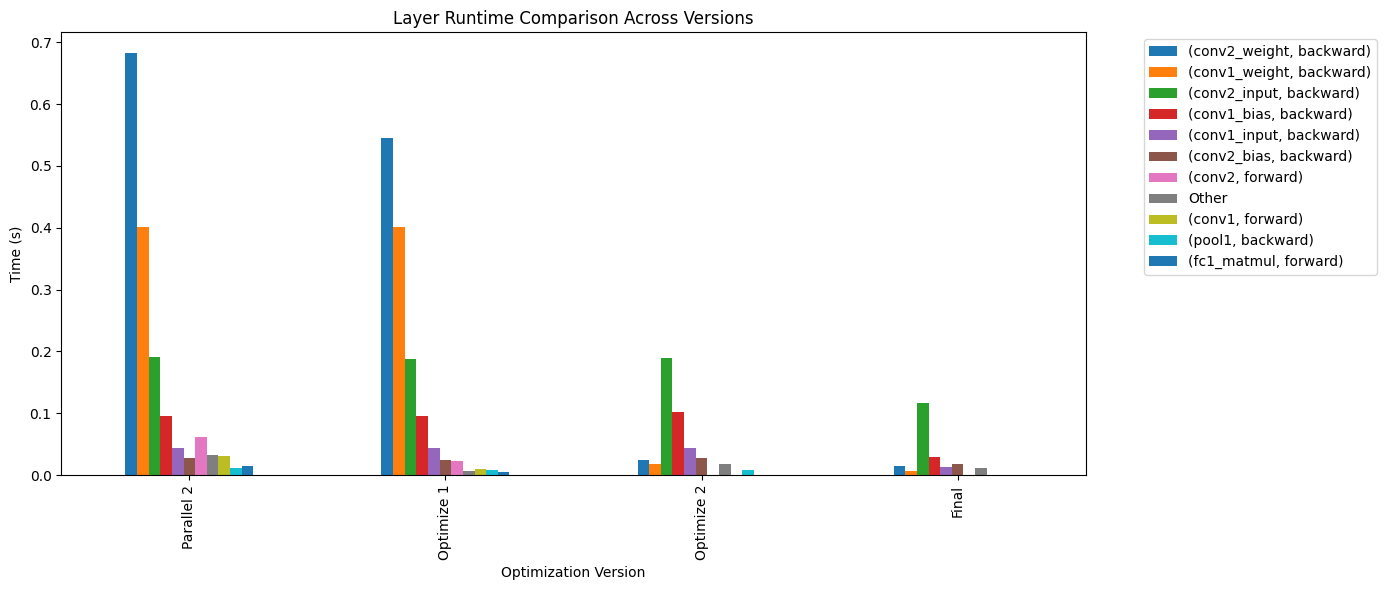

In [ ]:
layer_times_big_batch_plot.T.plot(
    kind="bar",
    figsize=(14,6)
)
plt.title("Layer Runtime Comparison Across Versions")
plt.ylabel("Time (s)")
plt.xlabel("Optimization Version")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Biểu đồ trên thể hiện thời gian chạy của từng layer trong bốn phiên bản tối ưu khác nhau (Parallel 2, Optimize 1, Optimize 2 và Final). Kết quả cho thấy:

* Ở hai phiên bản đầu (Parallel 2 và Optimize 1), thời gian thực thi còn khá lớn, trong đó các tác vụ `conv2_weight_backward`, `conv1_weight_backward` và `fc1_matmul_forward` chiếm nhiều thời gian nhất. Đây chính là các “điểm nghẽn” làm chậm quá trình huấn luyện.
* Sang phiên bản Optimize 2, thời gian của hầu hết các tác vụ đã giảm đáng kể, tuy nhiên `conv2_input_backward` và `conv1_bias_backward` vẫn còn chiếm khá nhiều.
* Phiên bản Final cho thấy hiệu quả tối ưu tốt nhất: tổng thời gian thực thi giảm mạnh, đa số các layer chỉ còn dưới 0.05 giây. Mặc dù `conv2_input_backward` vẫn là tác vụ tốn thời gian nhất, nhưng so với các phiên bản trước thì nó cũng đã được cải thiện rõ rệt.

Tóm lại, quá trình tối ưu từ Parallel 2 đến Final đã giúp giảm thời gian chạy rất nhiều. Final version đạt hiệu suất cao nhất, chứng minh các bước tối ưu đã xử lý thành công những bottleneck chính trong mô hình.


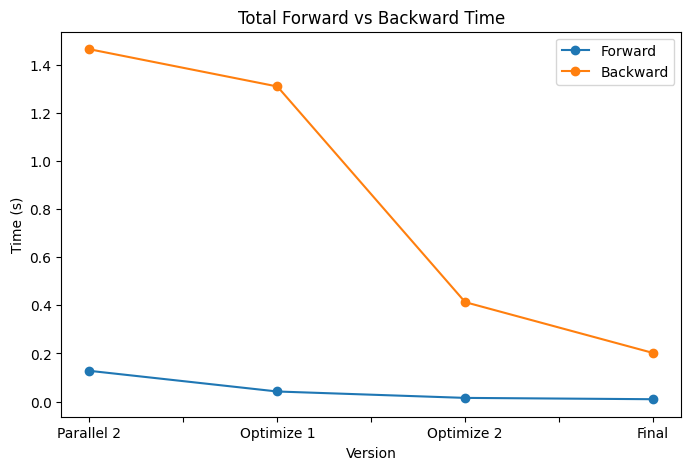

In [ ]:
# 3) Line chart: total forward/backward times
totals_big_batch = []
for name, df in versions_big_batch.items():
    forward_time = df[df["Pass"]=="forward"]["Time (s)"].sum()
    backward_time = df[df["Pass"]=="backward"]["Time (s)"].sum()
    totals_big_batch.append({"Version": name, "Forward": forward_time, "Backward": backward_time})

totals_df_big_batch = pd.DataFrame(totals_big_batch).set_index("Version")
totals_df_big_batch.plot(kind="line", marker="o", figsize=(8,5))
plt.title("Total Forward vs Backward Time")
plt.ylabel("Time (s)")
plt.show()

# Train and evaluate

Chiến lược huấn luyện:
 - Model **final** sẽ được huấn luyện trên toàn bộ tập train, sau mỗi epoch sẽ được evaluate trên tập validation
 - Early stopping: nếu sau 3 epoch mà accuracy trên tập validation không tăng thì quá trình train sẽ kết thúc
 - Sau mỗi epoch, learning rate sẽ giảm đi 5% nhằm giúp mô hình hội tụ

In [ ]:
def train(model, X_train, y_train, X_val, y_val,
          learning_rate=0.1, num_epochs=50, batch_size=32, lr_decay=0.95, patience=3):

    num_samples = X_train.shape[0]

    # History for visualize
    history = {
        "loss": [],
        "train_acc": [],
        "val_acc": []
    }

    best_val_acc = 0.0
    best_model = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        start_time = time.time()

        # Shuffle training data
        permutation = np.random.permutation(num_samples)
        X_shuffled = X_train[permutation]
        y_shuffled = y_train[permutation]

        epoch_loss = 0
        total_correct = 0
        total_samples = 0

        # ===================== TRAIN =====================
        num_batches = (num_samples + batch_size - 1) // batch_size

        for i in range(num_batches):
            # Get batch
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]

            # Forward
            predictions = model.forward(X_batch)

            # Loss
            loss = cross_entropy_loss(predictions, y_batch)
            epoch_loss += loss

            # Accuracy
            preds_class = np.argmax(predictions, axis=1)
            total_correct += np.sum(preds_class == y_batch)
            total_samples += len(y_batch)

            # Backward
            grad_output = cross_entropy_loss_backward(predictions, y_batch)
            grads = model.backward(grad_output)

            # Update weights
            model.update(grads, learning_rate)

        avg_loss = epoch_loss / num_batches
        train_acc = total_correct / total_samples

        # ===================== VALIDATION =====================
        val_correct = 0
        val_samples = 0
        num_val_batches = (X_val.shape[0] + batch_size - 1) // batch_size

        for j in range(num_val_batches):
            start_idx = j * batch_size
            end_idx = min((j + 1) * batch_size, X_val.shape[0])
            X_batch = X_val[start_idx:end_idx]
            y_batch = y_val[start_idx:end_idx]

            preds = model.forward(X_batch)
            preds_class = np.argmax(preds, axis=1)
            val_correct += np.sum(preds_class == y_batch)
            val_samples += len(y_batch)

        val_acc = val_correct / val_samples

        # Save history
        history["loss"].append(avg_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # Epoch stats
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Loss: {avg_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"LR: {learning_rate:.6f} | "
              f"Time: {epoch_time:.2f}s")

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model  # save the best model
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"⏹ Early stopping at epoch {epoch+1} (best val_acc={best_val_acc:.4f})")
                break

        # Learning rate decay
        learning_rate *= lr_decay

    return best_model, history


## Train mô hình trên toàn bộ tập train

In [ ]:
final_model = SimpleCNN_Final()

batch_size = 32

best_model, history = train(final_model, X_train, y_train, X_val, y_val, learning_rate=0.1, num_epochs=50, batch_size=batch_size, lr_decay=0.95, patience=3)

Epoch 1/50 | Loss: 0.9893 | Train Acc: 0.7239 | Val Acc: 0.9163 | LR: 0.100000 | Time: 32.42s
Epoch 2/50 | Loss: 0.1215 | Train Acc: 0.9637 | Val Acc: 0.9714 | LR: 0.095000 | Time: 32.75s
Epoch 3/50 | Loss: 0.0616 | Train Acc: 0.9839 | Val Acc: 0.7804 | LR: 0.090250 | Time: 34.31s
Epoch 4/50 | Loss: 0.0312 | Train Acc: 0.9912 | Val Acc: 0.9856 | LR: 0.085737 | Time: 32.28s
Epoch 5/50 | Loss: 0.0137 | Train Acc: 0.9965 | Val Acc: 0.9865 | LR: 0.081451 | Time: 41.20s
Epoch 6/50 | Loss: 0.0083 | Train Acc: 0.9979 | Val Acc: 0.9901 | LR: 0.077378 | Time: 32.66s
Epoch 7/50 | Loss: 0.0040 | Train Acc: 0.9993 | Val Acc: 0.9903 | LR: 0.073509 | Time: 33.04s
Epoch 8/50 | Loss: 0.0026 | Train Acc: 0.9995 | Val Acc: 0.9889 | LR: 0.069834 | Time: 34.31s
Epoch 9/50 | Loss: 0.0016 | Train Acc: 0.9999 | Val Acc: 0.9897 | LR: 0.066342 | Time: 32.54s
Epoch 10/50 | Loss: 0.0011 | Train Acc: 0.9999 | Val Acc: 0.9906 | LR: 0.063025 | Time: 33.48s
Epoch 11/50 | Loss: 0.0009 | Train Acc: 0.9999 | Val Acc: 0

**Quá trình học**

* **Loss giảm rất nhanh**: chỉ sau 3 epoch, loss đã từ \~0.98 rơi xuống 0.06, chứng tỏ mô hình học cực nhanh.
* **Val Accuracy cao và ổn định**: từ epoch 4 trở đi, validation accuracy gần như luôn >0.98, và đạt đỉnh \~0.9907 ở epoch 12.
* **Overfitting gần như không đáng kể**:

  * Train acc đạt 0.9999 - 1.0 rất sớm.
  * Val acc cũng giữ được mức cao (\~0.99), không có dấu hiệu giảm mạnh → mô hình tổng quát hóa tốt.

**Learning rate schedule**

* LR giảm dần mỗi epoch (từ 0.1 → 0.0487 ở epoch 15).
* Nhờ LR decay mà loss không “nhảy loạn” ở giai đoạn sau, giúp mô hình fine-tune dần thay vì bị dao động.

**Thời gian train**

* Mỗi epoch \~32–35s, khá ổn định (dao động nhỏ do load dữ liệu, random batch, hoặc khác biệt GPU scheduling).

**Early Stopping**

* Early stopping ở **epoch 15** (best val\_acc = 0.9907).
* Đây là điểm dừng hợp lý vì sau epoch 12–15, val\_acc dao động trong khoảng 0.989–0.9906 mà không tăng thêm. Nếu tiếp tục train thì gần như không có lợi.

<br>

**Tóm lại**:
* Mô hình của nhóm học **rất nhanh**, **ổn định**, **không overfit nặng** và đã đạt **độ chính xác cực cao (\~99%)** chỉ trong 15 epoch. Đây là một kết quả gần như tối ưu. Ngoài lề một chút, tốc độ học nhanh thế này thường xuất hiện khi:

  * Kiến trúc CNN + tối ưu CUDA đã rất mạnh và hợp dữ liệu.
  * Dataset được tiền xử lý tốt, ít nhiễu.
  * Learning rate schedule hợp lý.

## Visualize train history

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training history (loss, train_acc, val_acc).

    Parameters
    ----------
    history : dict
        A dictionary containing training history with keys 'loss',
        'train_acc', and 'val_acc'.
    """
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], label='Training Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

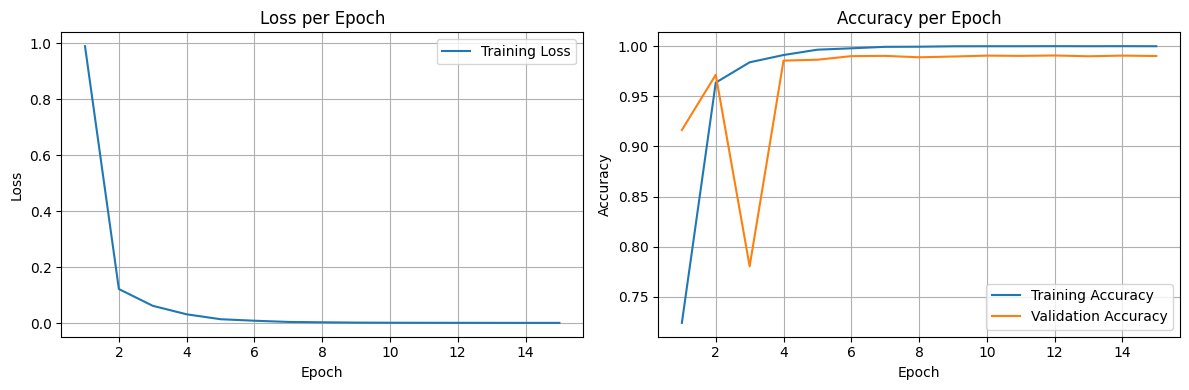

In [ ]:
plot_training_history(history)

## Save and load params

In [ ]:
def save_params(model, filepath):
    """
    Save model parameters (params_cpu) to a .npz file.
    """
    np.savez(filepath, **model.params_cpu)
    print(f"[INFO] Saved model parameters to {filepath}")


def load_params(model, filepath):
    """
    Load parameters from a .npz file into the model.
    Synchronizes both params_cpu and params_gpu.
    """
    data = np.load(filepath)
    for name in model.params_cpu.keys():
        model.params_cpu[name] = data[name]
        model.params_gpu[name].copy_to_device(model.params_cpu[name])
    print(f"[INFO] Loaded model parameters from {filepath}")

In [ ]:
save_params(best_model, "/content/drive/MyDrive/parallel_programming/best_params.npz")

[INFO] Saved model parameters to /content/drive/MyDrive/parallel_programming/best_params.npz


## Đánh giá mô hình

### Các metric được sử dụng

**1. Accuracy (Độ chính xác)**

* **Công thức:**

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

* **Định nghĩa bằng lời:** Accuracy cho biết tổng số dự đoán đúng (cả Positive lẫn Negative) so với toàn bộ mẫu.
* **Ý nghĩa:** Đây là metric cơ bản nhất, phản ánh xem “tổng thể mô hình có dự đoán đúng nhiều không”. Tuy nhiên, nếu dữ liệu bị lệch lớp (ví dụ có 95% mẫu thuộc 1 lớp), thì accuracy có thể “ảo tưởng” cao mà thực chất mô hình không giỏi.

<br>

**2. Precision (Độ chính xác dương)**

* **Công thức:**

$$
Precision = \frac{TP}{TP + FP}
$$

* **Precision** cho biết trong tất cả những mẫu mà mô hình dự đoán là **Positive**, thì có bao nhiêu cái thực sự đúng.
* **Ý nghĩa:** Precision cao tức là mô hình ít báo nhầm dương (false alarm thấp). Trong thực tế, Precision quan trọng khi cái giá của việc báo nhầm **rất cao** (ví dụ mô hình dự đoán “người này phạm tội” hoặc “người này bị bệnh nguy hiểm”).

<br>

**3. Recall (Độ bao phủ dương / Độ nhạy – Sensitivity)**

* **Công thức:**

$$
Recall = \frac{TP}{TP + FN}
$$

* Recall cho biết trong tất cả các mẫu thực sự là **Positive**, thì mô hình dự đoán đúng được bao nhiêu.
* **Ý nghĩa:** Recall cao nghĩa là mô hình ít bỏ sót. Trong y tế, đây là metric cực quan trọng vì bỏ sót bệnh nhân nguy hiểm sẽ gây hậu quả nặng nề, dù có thể chấp nhận báo nhầm thêm vài người.

<br>

**4. F1-Score**

* **Công thức:**

$$
F1 = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall}
$$

* F1 là trung bình điều hòa giữa Precision và Recall, nhấn mạnh sự cân bằng giữa 2 metric này.

* **Ý nghĩa:** Thích hợp khi dữ liệu bị mất cân bằng hoặc khi chúng ta muốn vừa **giảm bỏ sót** vừa **giảm báo nhầm**. Nếu Precision cao mà Recall thấp (hoặc ngược lại), thì F1 sẽ phạt mạnh → phản ánh khách quan hơn.

<br>

**5. AUROC (Area Under the ROC Curve)**

* **Công thức:**

$$
AUROC = \int_0^1 TPR(FPR) \, d(FPR)
$$

* Trong đó:

$$
TPR = \frac{TP}{TP + FN}, \quad FPR = \frac{FP}{FP + TN}
$$

* AUROC là diện tích dưới đường cong ROC, thể hiện khả năng mô hình phân biệt giữa Positive và Negative ở nhiều ngưỡng khác nhau.

* **Ý nghĩa:**
  * AUROC = 0.5 → mô hình đoán như random.
  * AUROC gần 1 → mô hình càng giỏi trong việc phân biệt 2 lớp.
  * Rất hay dùng trong các lĩnh vực y tế, tài chính, vì nó không phụ thuộc vào một ngưỡng duy nhất như accuracy.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, X_train, y_train):
    """Tính các metric: accuracy, precision, recall, f1, AUROC trên toàn bộ tập test"""

    probs = []
    preds = []
    batch_size = 128

    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        out = model.forward(X_batch)
        probs.append(out)
        preds.append(np.argmax(out, axis=1))

    y_pred = np.concatenate(preds)
    y_prob = np.concatenate(probs)
    y_true = y_train[:len(y_pred)]

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    try:
        if y_prob.shape[1] <= 50:
            auroc = roc_auc_score(y_true, y_prob, multi_class='ovo')
        else:
            auroc = "Too many classes to compute AUROC ({} classes)".format(y_prob.shape[1])
    except Exception as e:
        auroc = f"AUROC Error: {e}"

    print("\n---- Evaluation on Test Set ----")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"AUROC    : {auroc:.4f}")

    return y_pred, {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auroc": auroc
    }


In [ ]:
y_pred, metrics = evaluate_model(test_load_model, X_test, y_test)


---- Evaluation on Test Set ----
Accuracy : 0.9321
Precision: 0.9073
Recall   : 0.9009
F1-score : 0.9004
AUROC    : 0.9965


Kết quả evaluate trên tập test cho thấy mô hình hoạt động khá tốt khi phân loại **43 lớp**. Cụ thể:

* **Accuracy = 93.21%**: Tỉ lệ dự đoán đúng trên toàn bộ tập test đạt hơn 93%. Với một bài toán phân loại đa lớp lên đến 43 nhãn, đây là con số rất ấn tượng, chứng tỏ mô hình đã học được các đặc trưng quan trọng để phân biệt giữa nhiều loại lớp khác nhau.

* **Precision = 90.73%**: Precision trung bình trên 43 lớp đạt hơn 90%. Điều này nghĩa là khi mô hình đưa ra dự đoán cho một lớp bất kỳ, thì trong khoảng 10 dự đoán, có hơn 9 dự đoán chính xác. Nói cách khác, mô hình ít khi gán nhầm mẫu thuộc lớp khác sang lớp cần phân loại (giảm false positive).

* **Recall = 90.09%**: Recall trung bình cũng trên 90%, thể hiện rằng mô hình tìm lại được phần lớn các mẫu thuộc đúng lớp đó. Với 43 lớp, đạt được recall cao cho thấy mô hình không chỉ “nhớ” tốt các lớp phổ biến mà còn có khả năng nhận diện khá tốt các lớp ít xuất hiện (dù có thể vẫn còn một số lớp hiếm bị bỏ sót).

* **F1-score = 90.04%**: Đây là thước đo cân bằng giữa precision và recall. F1 cao chứng tỏ mô hình vừa hạn chế gán nhầm (precision cao), vừa hạn chế bỏ sót (recall cao). Đạt mức >90% trong phân loại đa lớp là một kết quả mạnh, thể hiện sự ổn định của mô hình trên toàn bộ các lớp.

* **AUROC = 0.9965**: Đây là một kết quả đặc biệt nổi bật. AUROC gần bằng 1 nghĩa là mô hình có khả năng phân biệt cực kỳ tốt giữa các lớp. Với bài toán đa lớp, AUROC thường được tính trung bình (macro/micro) qua tất cả cặp lớp, nên điểm số này cho thấy mô hình gần như phân tách rõ ràng biên giới quyết định giữa các nhãn.

<br>

**Nhận xét tổng quan**:

* Mô hình đã đạt được độ chính xác và độ tin cậy cao trên một bài toán phức tạp nhiều lớp.
* Precision và Recall đồng đều ở mức trên 90%, cho thấy mô hình không chỉ mạnh ở một vài lớp chính mà còn có tính tổng quát tốt trên toàn bộ 43 lớp.
* Điểm AUROC gần hoàn hảo cho thấy mô hình có khả năng phân biệt đặc trưng rất mạnh, thậm chí tốt hơn so với chỉ số Accuracy phản ánh.

### Confusion matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names=None, normalize=False, figsize=(12, 10), cmap="Blues"):
    """
    Plots the confusion matrix for multi-class classification (e.g., 43 classes).

    Parameters
    ----------
    y_true : array-like
        Ground truth labels.
    y_pred : array-like
        Predicted labels.
    class_names : list or None
        Names of the classes. If None, it will use numbers [0, 1, ..., n_classes-1].
    normalize : bool
        Whether to normalize the confusion matrix (by percentage).
    figsize : tuple
        Figure size for matplotlib.
    cmap : str
        Colormap for the heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]

    if class_names is None:
        class_names = np.arange(n_classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        fmt = ".2f"
    else:
        fmt = "d"

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=class_names, yticklabels=class_names,
                cbar=True)

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.tight_layout()
    plt.show()

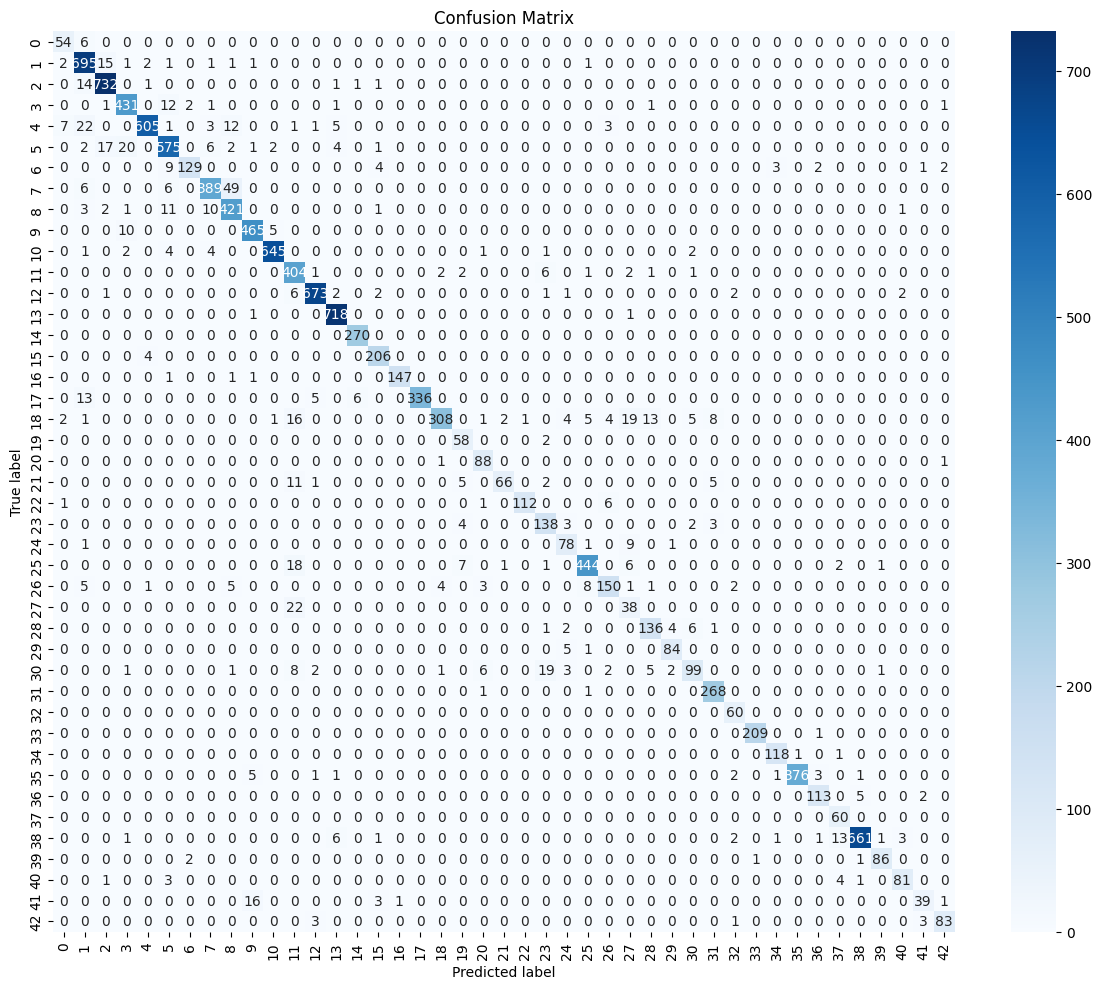

In [ ]:
plot_confusion_matrix(y_test, y_pred, class_names=None, normalize=False, figsize=(12, 10), cmap="Blues")

#### Nhận xét

- Hầu hết các ô trên đường chéo (true label = predicted label) có giá trị rất lớn so với các ô ngoài đường chéo.

 → Điều này cho thấy mô hình phân loại đúng đa số các trường hợp (accuracy cao).
- Một số nhãn có số lượng mẫu lớn hơn hẳn, như lớp `1`, `2`, `3`, `6`, `10`… có giá trị > 500–700, trong khi nhiều lớp khác chỉ vài chục, Điều này phản ánh dữ liệu bị mất cân bằng (class imbalance) → một số lớp có rất nhiều mẫu, số khác thì ít.
- Ở các lớp có số mẫu thấp (ví dụ lớp 40, 41, 42), số đúng chỉ khoảng vài chục → dễ thấy tỷ lệ nhầm lẫn cao hơn, là dấu hiệu điển hình khi dữ liệu huấn luyện bị mất cân bằng.
- Các dự đoán sai không tập trung nhiều vào một cặp cụ thể
   - Các ô ngoài đường chéo thường có giá trị rất nhỏ (0–10).
   - Không thấy hiện tượng “hai lớp hay bị nhầm lẫn lẫn nhau” một cách rõ rệt → tức là các đặc trưng mô hình học được khá tốt trong việc tách biệt giữa các lớp.


### In thử một số sample kèm label

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_test_samples(X_test, y_true, y_pred, class_names=None, n_samples=10, num_img_per_row=5):
    """
    Display some samples from the test set with true and predicted labels.

    Parameters
    ----------
    X_test : np.ndarray
        Test images, shape = (N, H, W, C) or (N, C, H, W).
    y_true : array-like
        Ground truth labels.
    y_pred : array-like
        Predicted labels.
    class_names : list or None
        List of class names (if None, print numbers).
    n_samples : int
        Number of samples to display.
    num_img_per_row : int
        Number of images per row.
    """
    n_samples = min(n_samples, len(X_test))
    indices = np.random.choice(len(X_test), n_samples, replace=False)

    n_rows = (n_samples + num_img_per_row - 1) // num_img_per_row
    plt.figure(figsize=(3*num_img_per_row, 3*n_rows))

    for i, idx in enumerate(indices):
        img = X_test[idx]
        # If the data is in (C, H, W) format, change it to (H, W, C)
        if img.ndim == 3 and img.shape[0] in [1, 3]:
            img = np.transpose(img, (1, 2, 0))

        true_label = y_true[idx]
        pred_label = y_pred[idx]

        if class_names is not None:
            true_text = class_names[true_label]
            pred_text = class_names[pred_label]
        else:
            true_text = str(true_label)
            pred_text = str(pred_label)

        plt.subplot(n_rows, num_img_per_row, i + 1)
        plt.imshow((img + 1) / 2 if img.min() < 0 else img)
        plt.axis("off")
        color = "green" if true_label == pred_label else "red"
        plt.title(f"T:{true_text}\nP:{pred_text}", fontsize=9, color=color, pad=2)

    # Reduce spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.show()

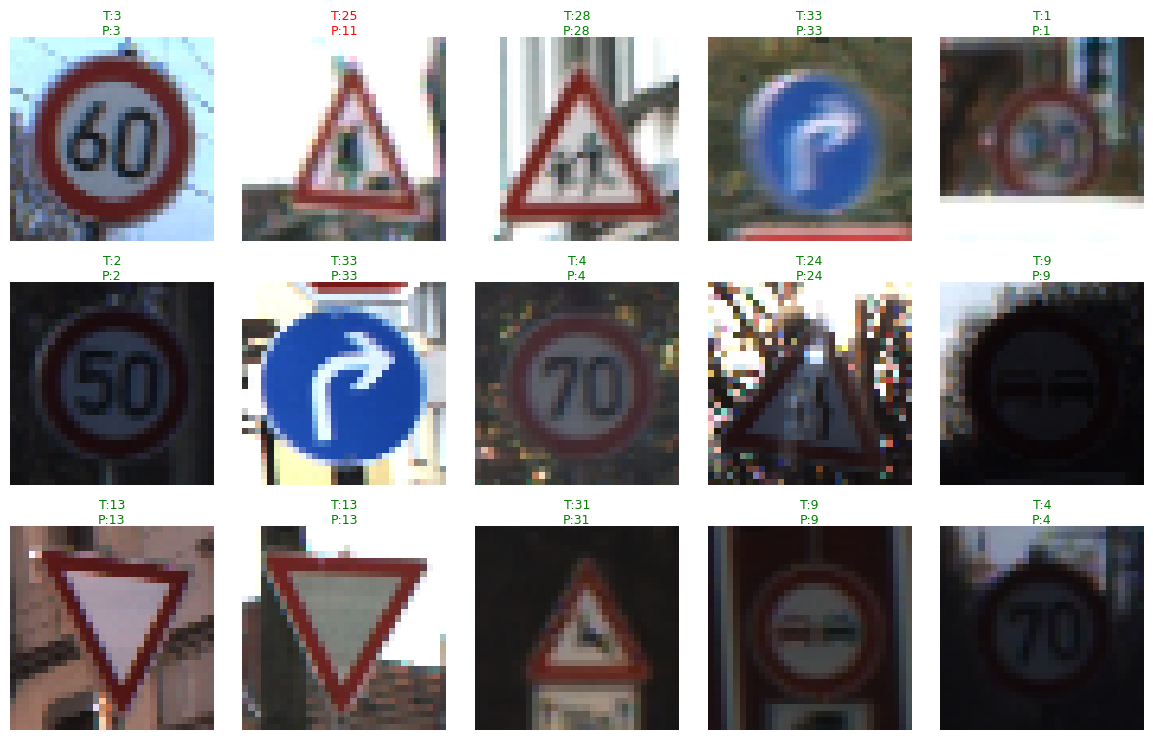

In [ ]:
show_test_samples(X_test, y_test, y_pred, n_samples=15)